In [1]:
# load usual python packages
import numpy as np
import scipy as sp
import pandas as pd
from datetime import datetime
from tqdm import tqdm
import time
import seaborn as sns
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.graphics.tsaplots import plot_acf
#library("forecast")
#library("ggplot2")
import itertools


from patsy import dmatrices



import statsmodels.api as sm

# for reading and displaying images
#from skimage.io import imread
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec
%matplotlib inline
%config InlineBackend.figure_format='retina'
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point


# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso #fewer coefficients than Ridge 
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_absolute_error




from tqdm import tqdm
import math

# load pytorch packages for deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.utils.data import Dataset, DataLoader
#from torch.utils.tensorboard import SummaryWriter
from torch.optim import Adam, SGD
#import torchvision

import xarray
import netCDF4
import sklearn
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import sys
import numpy
#numpy.set_printoptions(threshold=sys.maxsize)

date_today = datetime.now().strftime("%Y-%m-%d")
counter = 0

In [28]:
statsmodels.__version__

'0.9.0'

# Loading the data for Dengue fewer predictions 

Dengue fever is a mosquito-borne disease that occurs in the tropical and sub-tropical regions and the severity of the symptoms can vary from flu like to significant bleeding or even death. Since the desease is carried by mosquitoes its transmittion highly depends on the migration and survival of mosquitos, which in term depend on the climate in the area, especially the temperatue and precipitation as mosuitos thrive in moist and warm envrionments.

This section provides initial analysis of the data. The data contains two cities: San Juan, Puerto Rico and Iquitos, Peru. It is possible that the psread of teh fever follows different dynamics in the two respective cities, therefore, we start by separating them into two different datasets.

We will start by investigating the correlation between the temperature, the moisture and other available features with the number of reported cases in both of these locations. We will then develop two separate algorithms to predict cases in each city and then combine out predictions for the final submittion.

In [2]:
#loading data and merging the labels 
training_features = pd.read_csv("dengue_features_train.csv")
training_labels = pd.read_csv("dengue_labels_train.csv")
test_features = pd.read_csv("dengue_features_test.csv")#.dropna().reset_index(drop=True)
results_format = pd.read_csv("submission_format.csv")

training_set = pd.merge(training_features, training_labels, on=['city','weekofyear', 'year'])#.dropna().reset_index(drop=True)
#preprocessing the training set for predictions

#converting dates from str to datetime format
training_set['week_start_date'] = pd.to_datetime(training_set['week_start_date'])
test_features['week_start_date'] = pd.to_datetime(test_features['week_start_date'])


In [90]:
print ('San Jua')
sj_training_set = training_set[training_set['city'] == 'sj']
sj_test_features = test_features[test_features['city'] == 'sj']
sj_test_features['week_start_date'] = pd.to_datetime(sj_test_features['week_start_date'])
print("Training set {}".format(sj_training_set.shape))
print("Test set {}".format(sj_test_features.shape))

print ("Iquitos")
iq_training_set = training_set[training_set['city'] == 'iq']
iq_test_features = test_features[test_features['city'] =='iq']
iq_test_features['week_start_date'] = pd.to_datetime(iq_test_features['week_start_date'])

print("Training set {}".format(iq_training_set.shape))
print("Test set {}".format(iq_test_features.shape))

San Jua
Training set (936, 25)
Test set (260, 24)
Iquitos
Training set (520, 25)
Test set (156, 24)


C:\Users\19ver\Anaconda2\envs\Py35\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\19ver\Anaconda2\envs\Py35\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


It is obvious that there will be data missing from both the trainign features and the test features:


In [132]:
# Incomplete data check
pd.isnull(sj_training_set).any()

city                                     False
year                                     False
weekofyear                               False
week_start_date                          False
ndvi_ne                                   True
ndvi_nw                                   True
ndvi_se                                   True
ndvi_sw                                   True
precipitation_amt_mm                      True
reanalysis_air_temp_k                     True
reanalysis_avg_temp_k                     True
reanalysis_dew_point_temp_k               True
reanalysis_max_air_temp_k                 True
reanalysis_min_air_temp_k                 True
reanalysis_precip_amt_kg_per_m2           True
reanalysis_relative_humidity_percent      True
reanalysis_sat_precip_amt_mm              True
reanalysis_specific_humidity_g_per_kg     True
reanalysis_tdtr_k                         True
station_avg_temp_c                        True
station_diur_temp_rng_c                   True
station_max_t

In [ ]:
pd.isnull(sj_test_features).any()

We can either use a *dropna* function to get rid of the values in which case we'd lose 209 data smaples from the San Juan training set and 48 from Iquitos dataset. Instead we can fill in the missing values from adjascent values, which is not a bad approximationa as all the features have continious time-series values. 

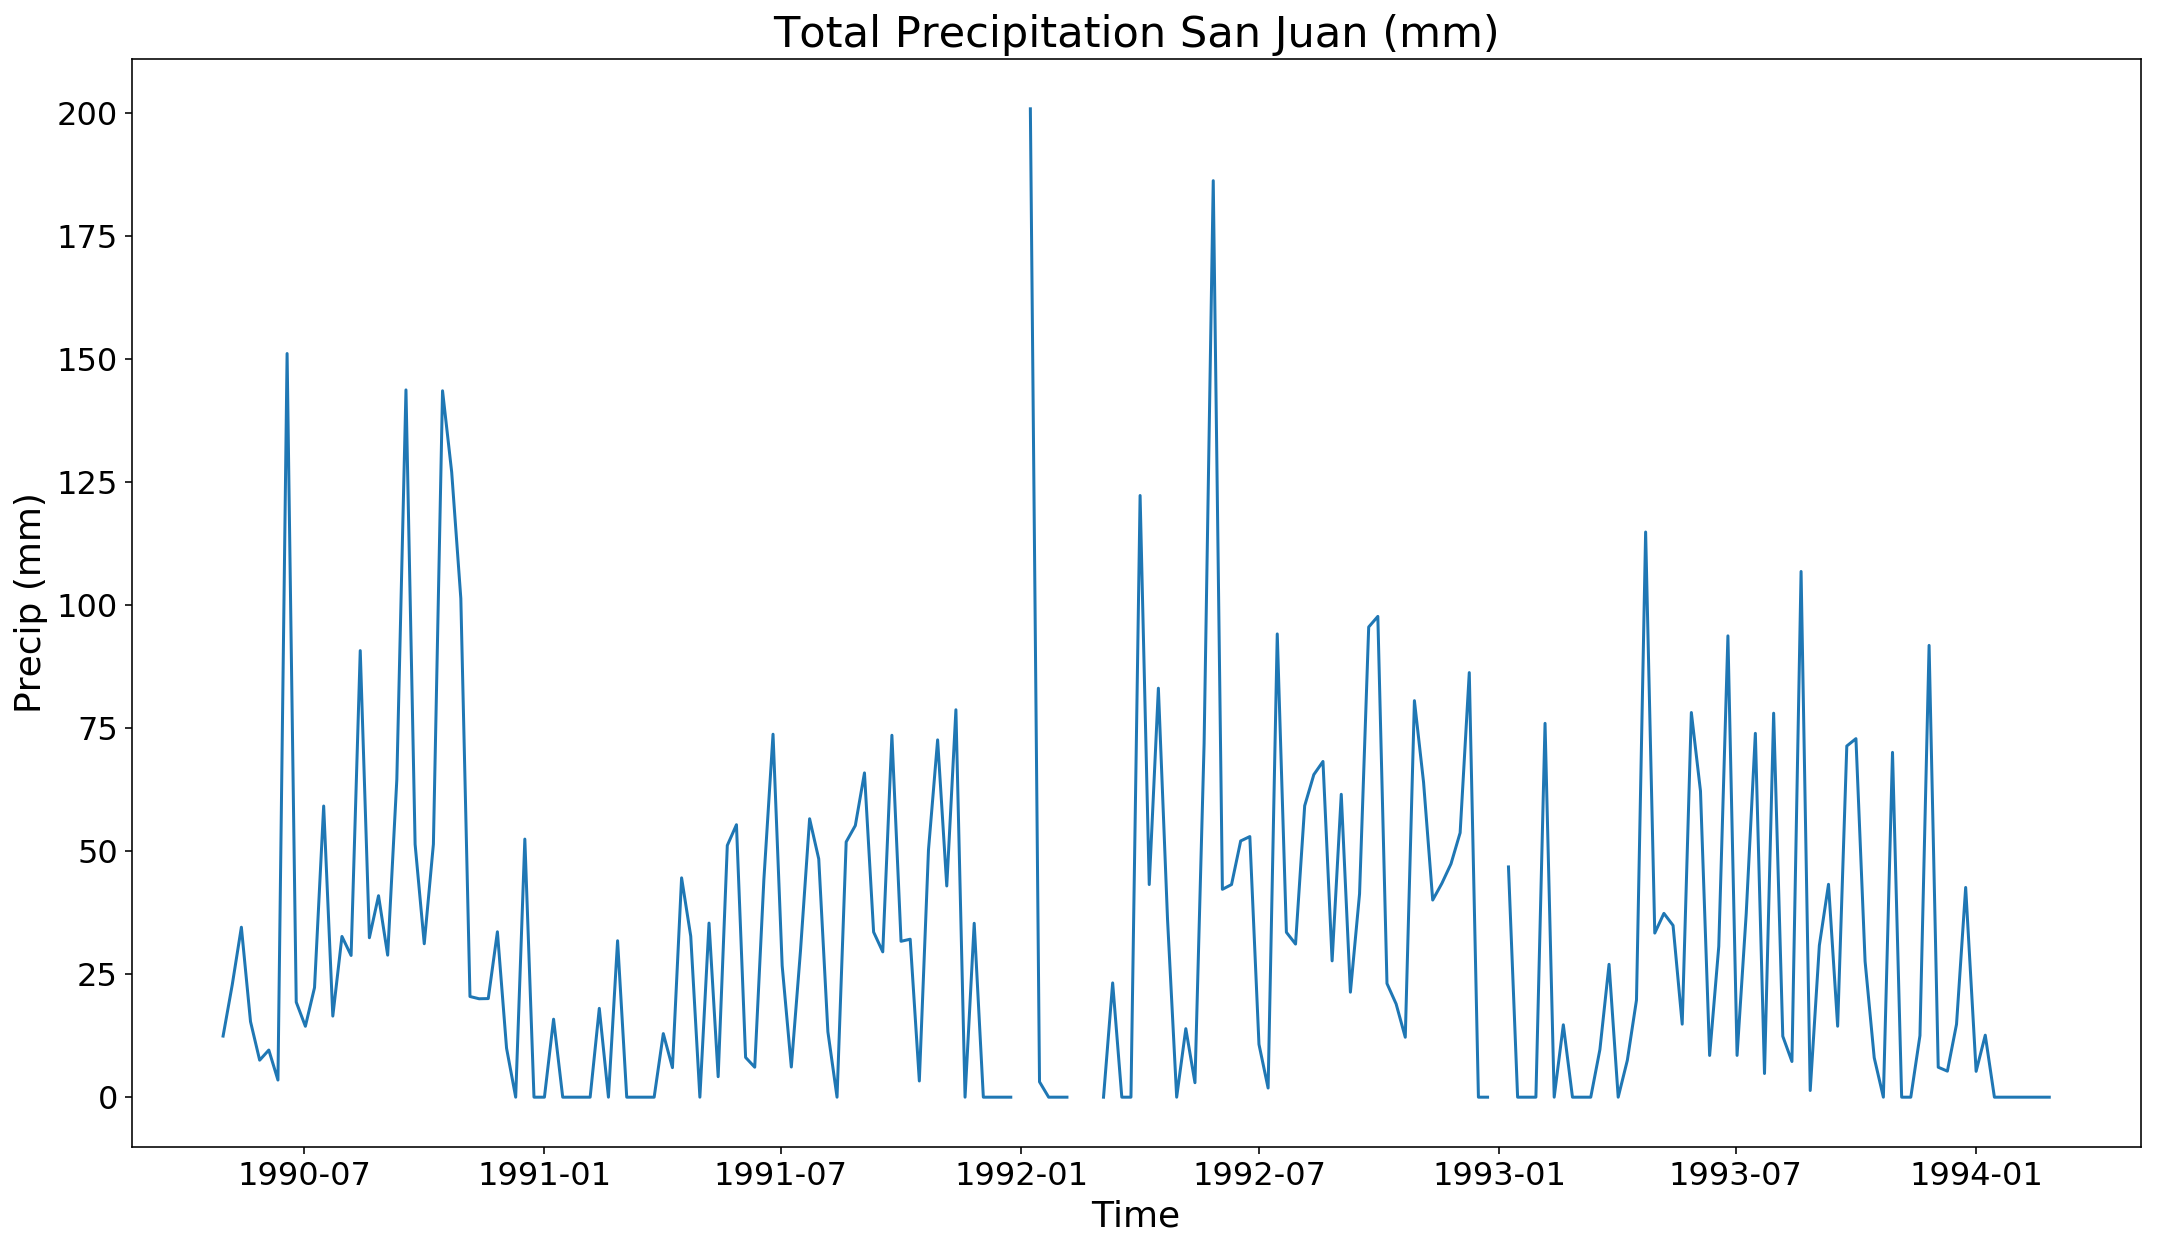

In [4]:
params = {
   'axes.labelsize': 18,# Set to size 8 to start with
   'font.size': 18,# Set to size 8 to start with
   'font.family': 'sans-serif', # Not given initially - only optional
   'font.serif': 'Arial', # Not given initially - only optional
   'legend.fontsize': 18,# Set to size 8 to start with
   'xtick.labelsize': 16,# Set to size 8 to start with
   'ytick.labelsize': 16, # Set to size 8 to start with
   'figure.figsize': [18, 10] # Set to [6,4] to start with 
} 
plt.rcParams.update(params)

plt.plot(sj_training_set['week_start_date'][:200],sj_training_set['precipitation_amt_mm'][:200])
plt.title("Total Precipitation San Juan (mm)")
plt.xlabel("Time")
plt.ylabel('Precip (mm)')
plt.show()

In [5]:
sj_training_set.fillna(method='ffill', inplace=True)
sj_test_features.fillna(method='ffill',inplace=True)

iq_training_set.fillna(method='ffill', inplace=True)
iq_test_features.fillna(method='ffill',inplace=True)

C:\Users\19ver\Anaconda2\envs\Py35\lib\site-packages\pandas\core\frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


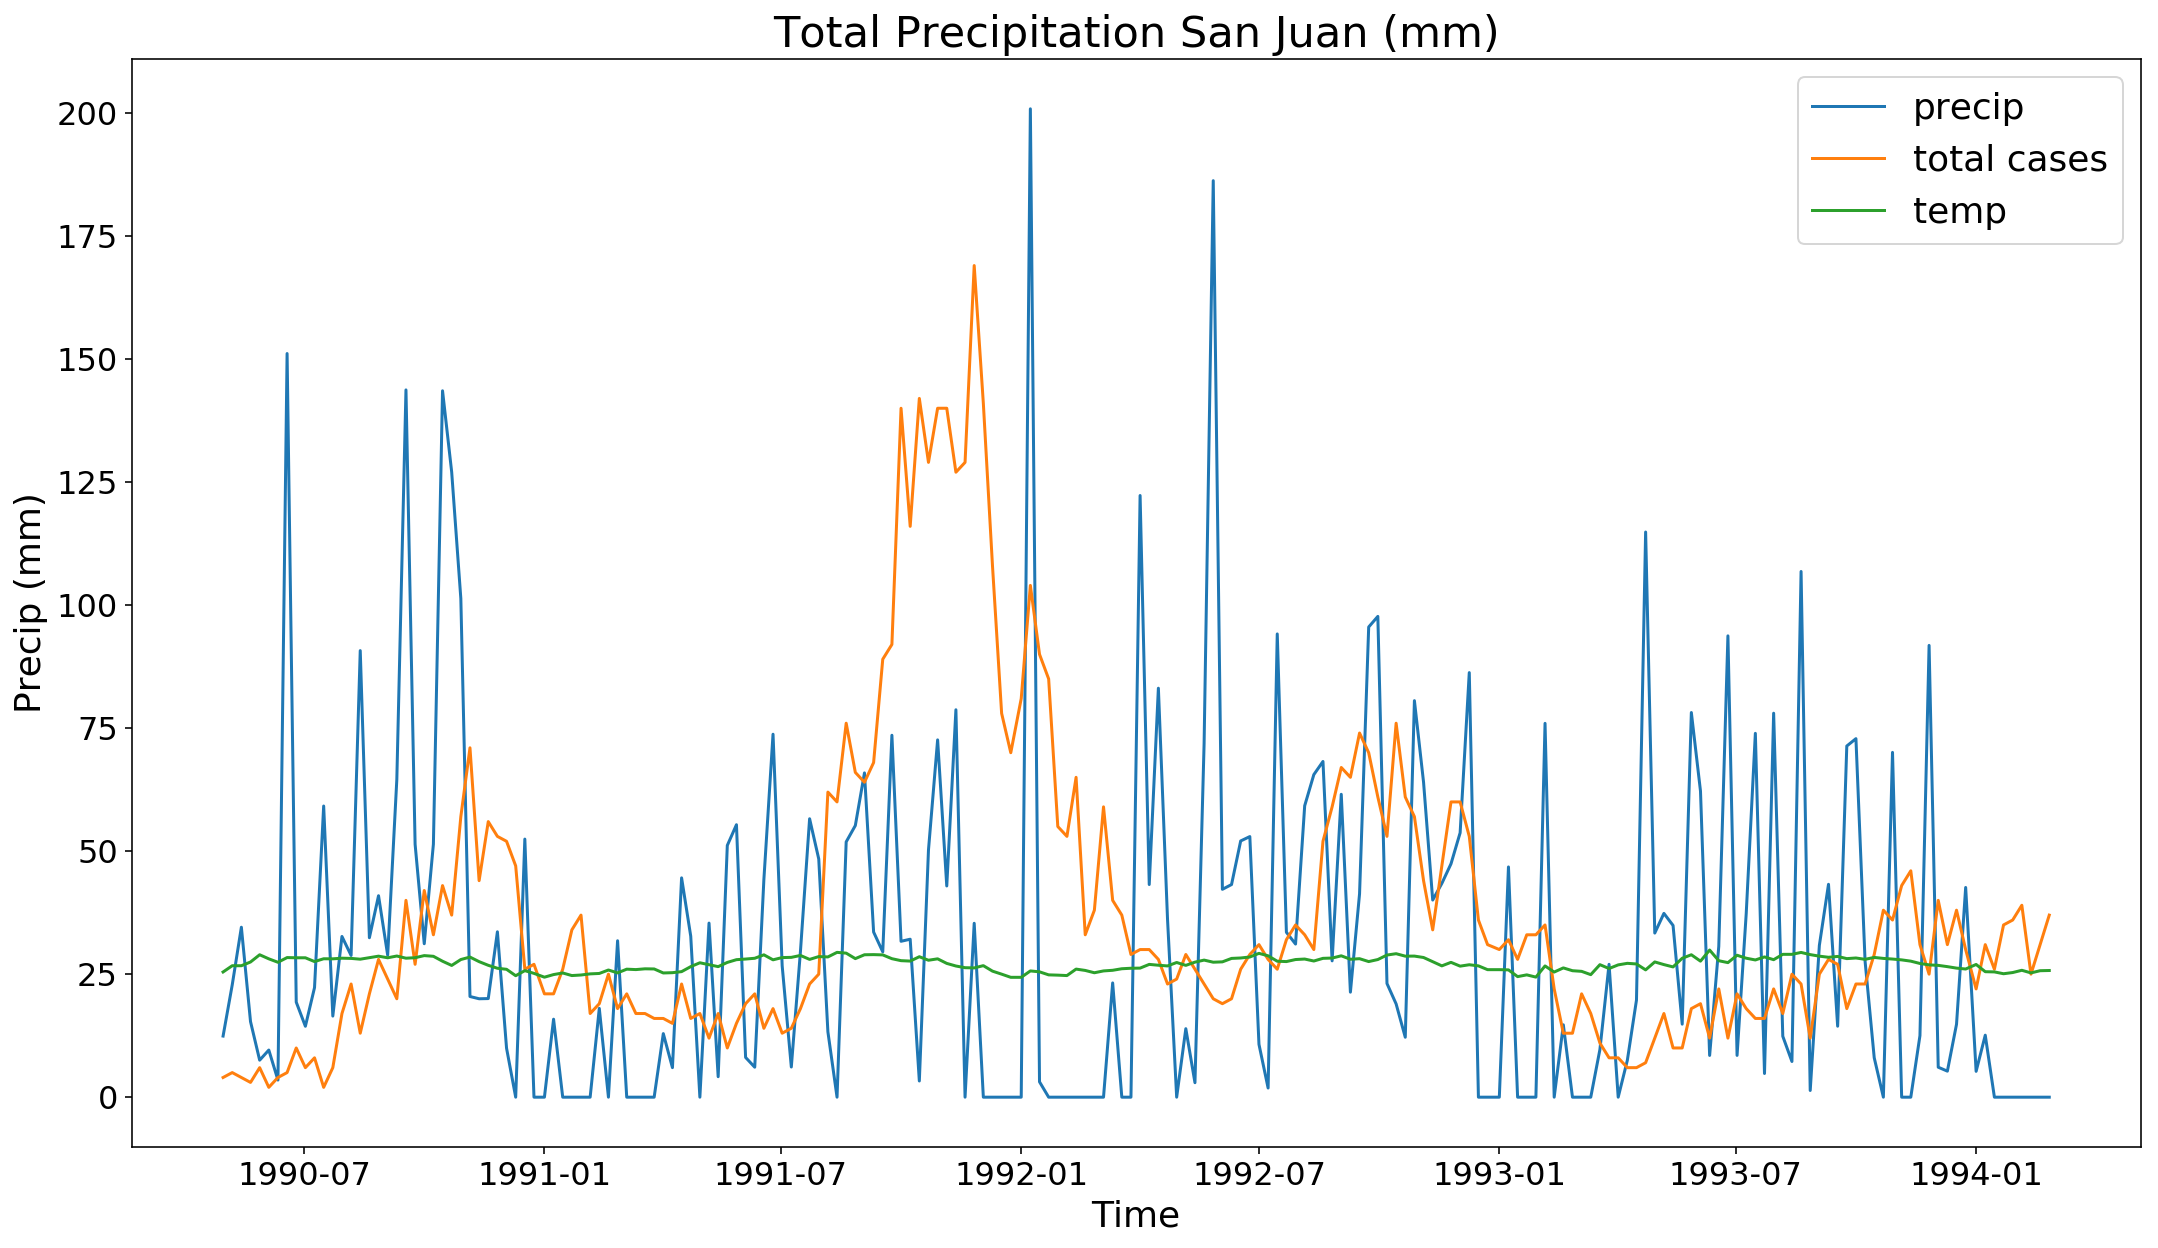

In [6]:
plt.plot(sj_training_set['week_start_date'][:200],sj_training_set['precipitation_amt_mm'][:200], label='precip')
plt.plot(sj_training_set['week_start_date'][:200],sj_training_set['total_cases'][:200], label='total cases')
plt.plot(sj_training_set['week_start_date'][:200],sj_training_set['station_avg_temp_c'][:200],label='temp')
plt.title("Total Precipitation San Juan (mm)")
plt.legend(loc='best')
plt.xlabel("Time")
plt.ylabel('Precip (mm)')
plt.show()

# Choosing the right fitting function for predictions 

When trying to predict an output *y* by fitting a complex function *f* on an input *x*, we need to choose a function that is able to represnts the complexity of the input features. We can also change our input in such a way that it is easier for the model to pick up on the most important correlations. 

First we look at the problem at hand. What the distribution of the data, that is the total number of cases in either of the cities. It is not categorical data, so we wont use classification models, but is it continuos? 

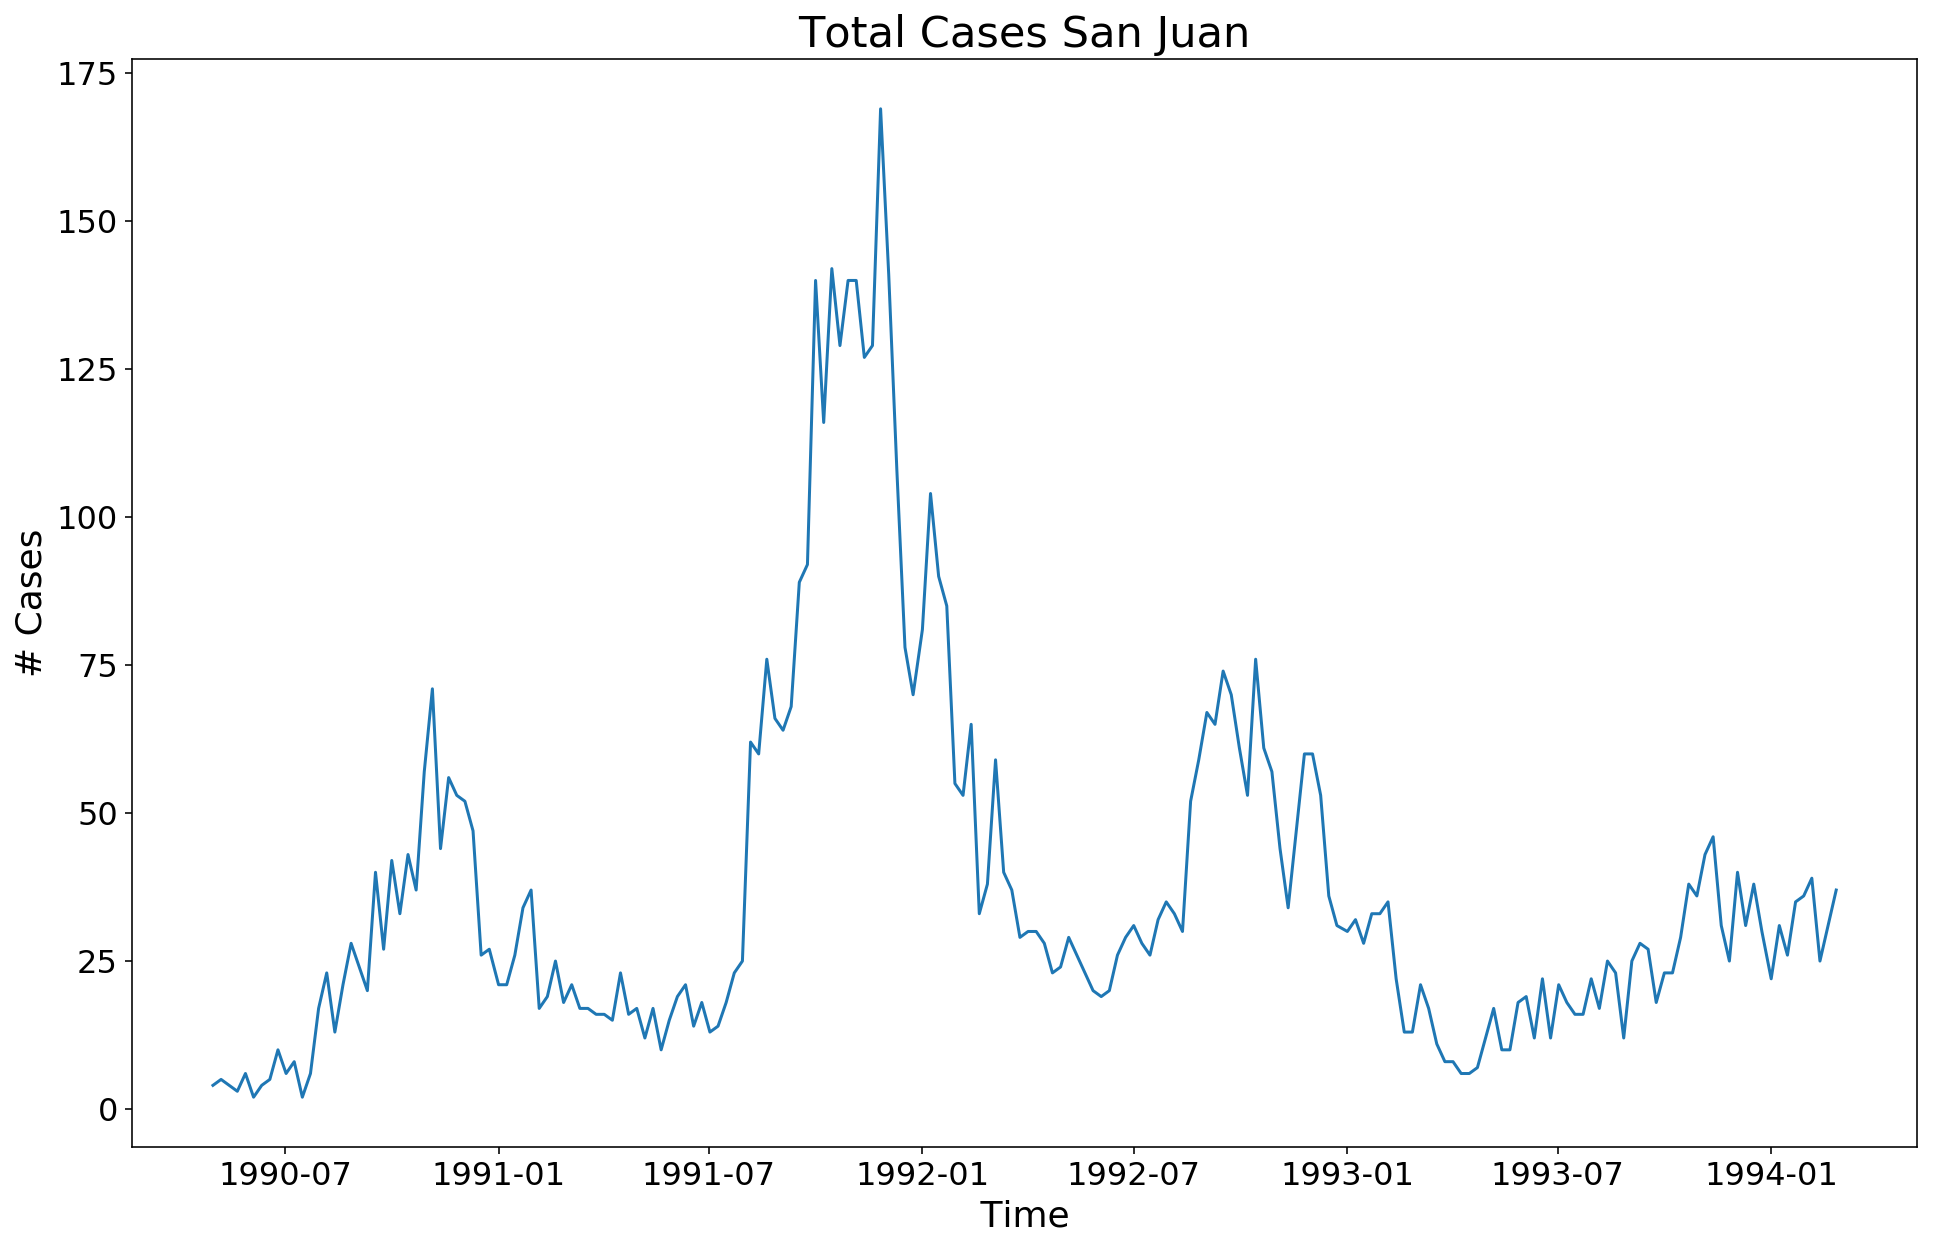

San Juan
 Mean: 34.2, Variance: 2637.2, Std: 51.4, max: 461


In [131]:
plt.plot(sj_training_set['week_start_date'][:200],sj_training_set['total_cases'][:200])
plt.title("Total Cases San Juan")
plt.xlabel(" Time ")
plt.ylabel('# Cases')
plt.show()

print ("San Juan")
print(" Mean: {}, Variance: {}, Std: {}, max: {}".format(round(np.mean(sj_training_set['total_cases']),1),
                                       round(np.var(sj_training_set['total_cases']),1), 
                                        round(np.std(sj_training_set['total_cases']),1),
                                                        max(sj_training_set['total_cases'])))

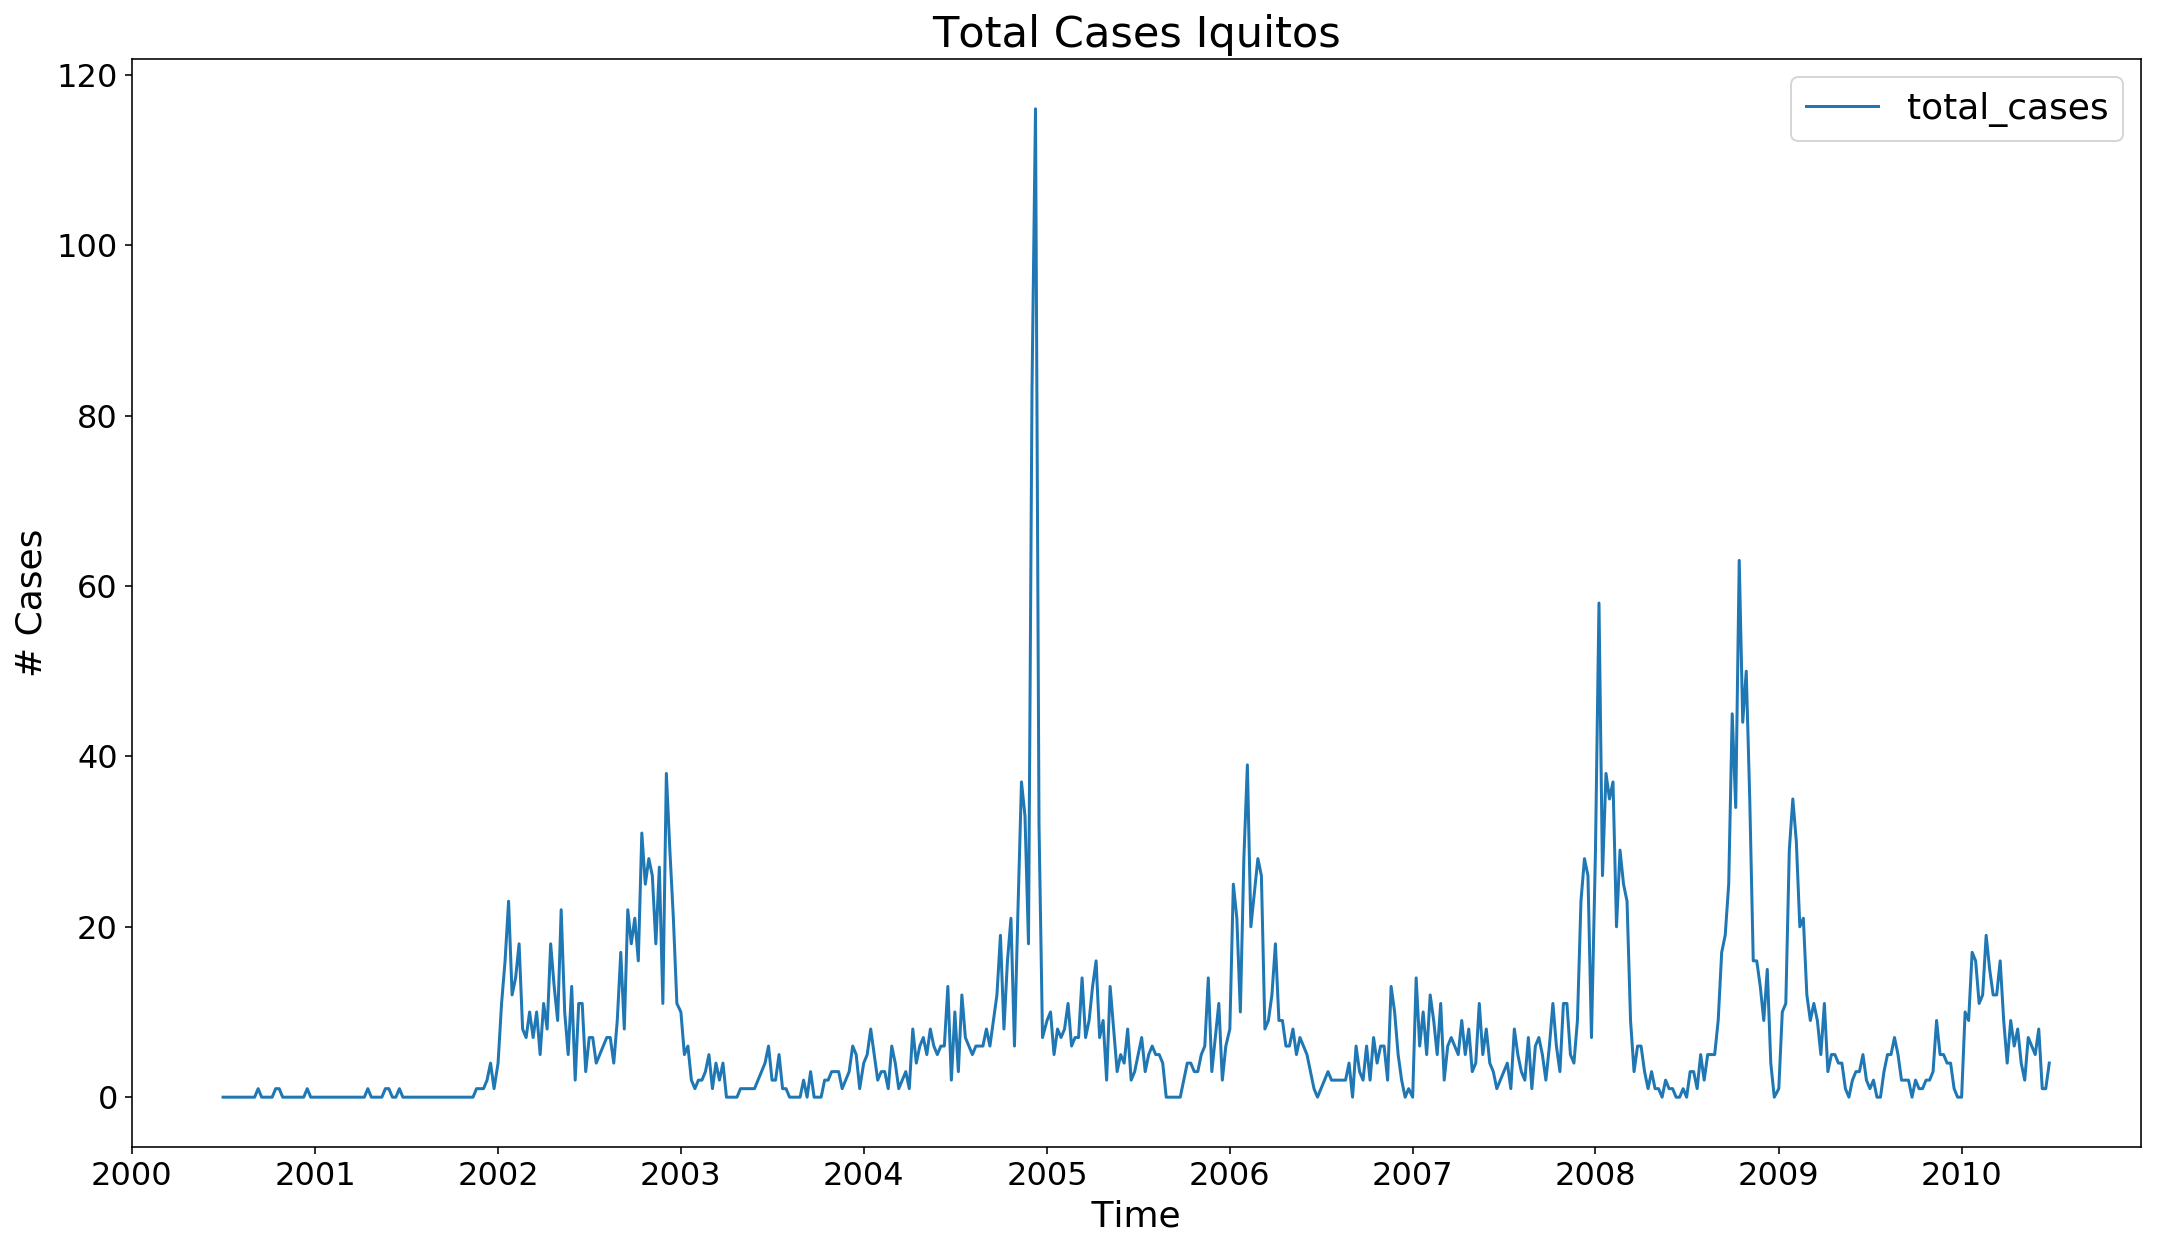

 Mean: 7.6, Variance: 115.7, Std: 10.8, Max: 116


In [8]:
plt.plot(iq_training_set['week_start_date'],iq_training_set['total_cases'])
plt.title("Total Cases Iquitos")
plt.xlabel(" Time ")
plt.ylabel('# Cases')
plt.legend()
plt.show()

print(" Mean: {}, Variance: {}, Std: {}, Max: {}".format(round(np.mean(iq_training_set['total_cases']),1),
                                       round(np.var(iq_training_set['total_cases']),1), 
                                        round(np.std(iq_training_set['total_cases']),1),
                                                        max(iq_training_set['total_cases'])))

It looks like the variance for eother of the city is a lot greater than the mean, for San Juan it is $ 50\sigma$ away and for Iquitos it is $10 \sigma$ away from the mean. The distribution that best fits this data pattern is Negative Binomial Distribution. Negative Binomial Regression is often used to model count based data such as the number of cyclists on the Brooklyn Bridge (https://towardsdatascience.com/negative-binomial-regression-f99031bb25b4). This is the Regression model that is going to be used for the Dengue Fever predictions.  

# Input data engineering

Another component of the predictive modelling expression that we can modulate in order to achieve the desired outcome, accurate predictiong of Dengue fever cases, is the input data. It is important to choose the right features to feed into algorithm to aid model learning. Need to check which available feature jave the most significant correlations with the number of Dengue cases.

In [9]:
sj_training_set.iloc[:,4:].head()

ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  precipitation_amt_mm  \
0  0.122600  0.103725  0.198483  0.177617                 12.42   
1  0.169900  0.142175  0.162357  0.155486                 22.82   
2  0.032250  0.172967  0.157200  0.170843                 34.54   
3  0.128633  0.245067  0.227557  0.235886                 15.36   
4  0.196200  0.262200  0.251200  0.247340                  7.52   

   reanalysis_air_temp_k  reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
0             297.572857             297.742857                   292.414286   
1             298.211429             298.442857                   293.951429   
2             298.781429             298.878571                   295.434286   
3             298.987143             299.228571                   295.310000   
4             299.518571             299.664286                   295.821429   

   reanalysis_max_air_temp_k  reanalysis_min_air_temp_k     ...       \
0                      299.8                      295.9     ...        
1                      300.9                      296.4     ...        
2                      300.5                      297.3     ...        
3                      301.4                      297.0     ...        
4                      301.9                      297.5     ...        

   reanalysis_relative_humidity_percent  reanalysis_sat_precip_amt_mm  \
0                             73.365714                         12.42   
1                             77.368571                         22.82   
2                             82.052857                         34.54   
3                             80.337143                         15.36   
4                             80.460000                          7.52   

   reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
0                              14.012857           2.628571   
1                              15.372857           2.371429   
2                              16.848571           2.300000   
3                              16.672857           2.428571   
4                              17.210000           3.014286   

   station_avg_temp_c  station_diur_temp_rng_c  station_max_temp_c  \
0           25.442857                 6.900000                29.4   
1           26.714286                 6.371429                31.7   
2           26.714286                 6.485714                32.2   
3           27.471429                 6.771429                33.3   
4           28.942857                 9.371429                35.0   

   station_min_temp_c  station_precip_mm  total_cases  
0                20.0               16.0            4  
1                22.2                8.6            5  
2                22.8               41.4            4  
3                23.3                4.0            3  
4                23.9                5.8            6  

[5 rows x 21 columns]

Text(0.5, 1.0, 'San Juan Feature Correlations')

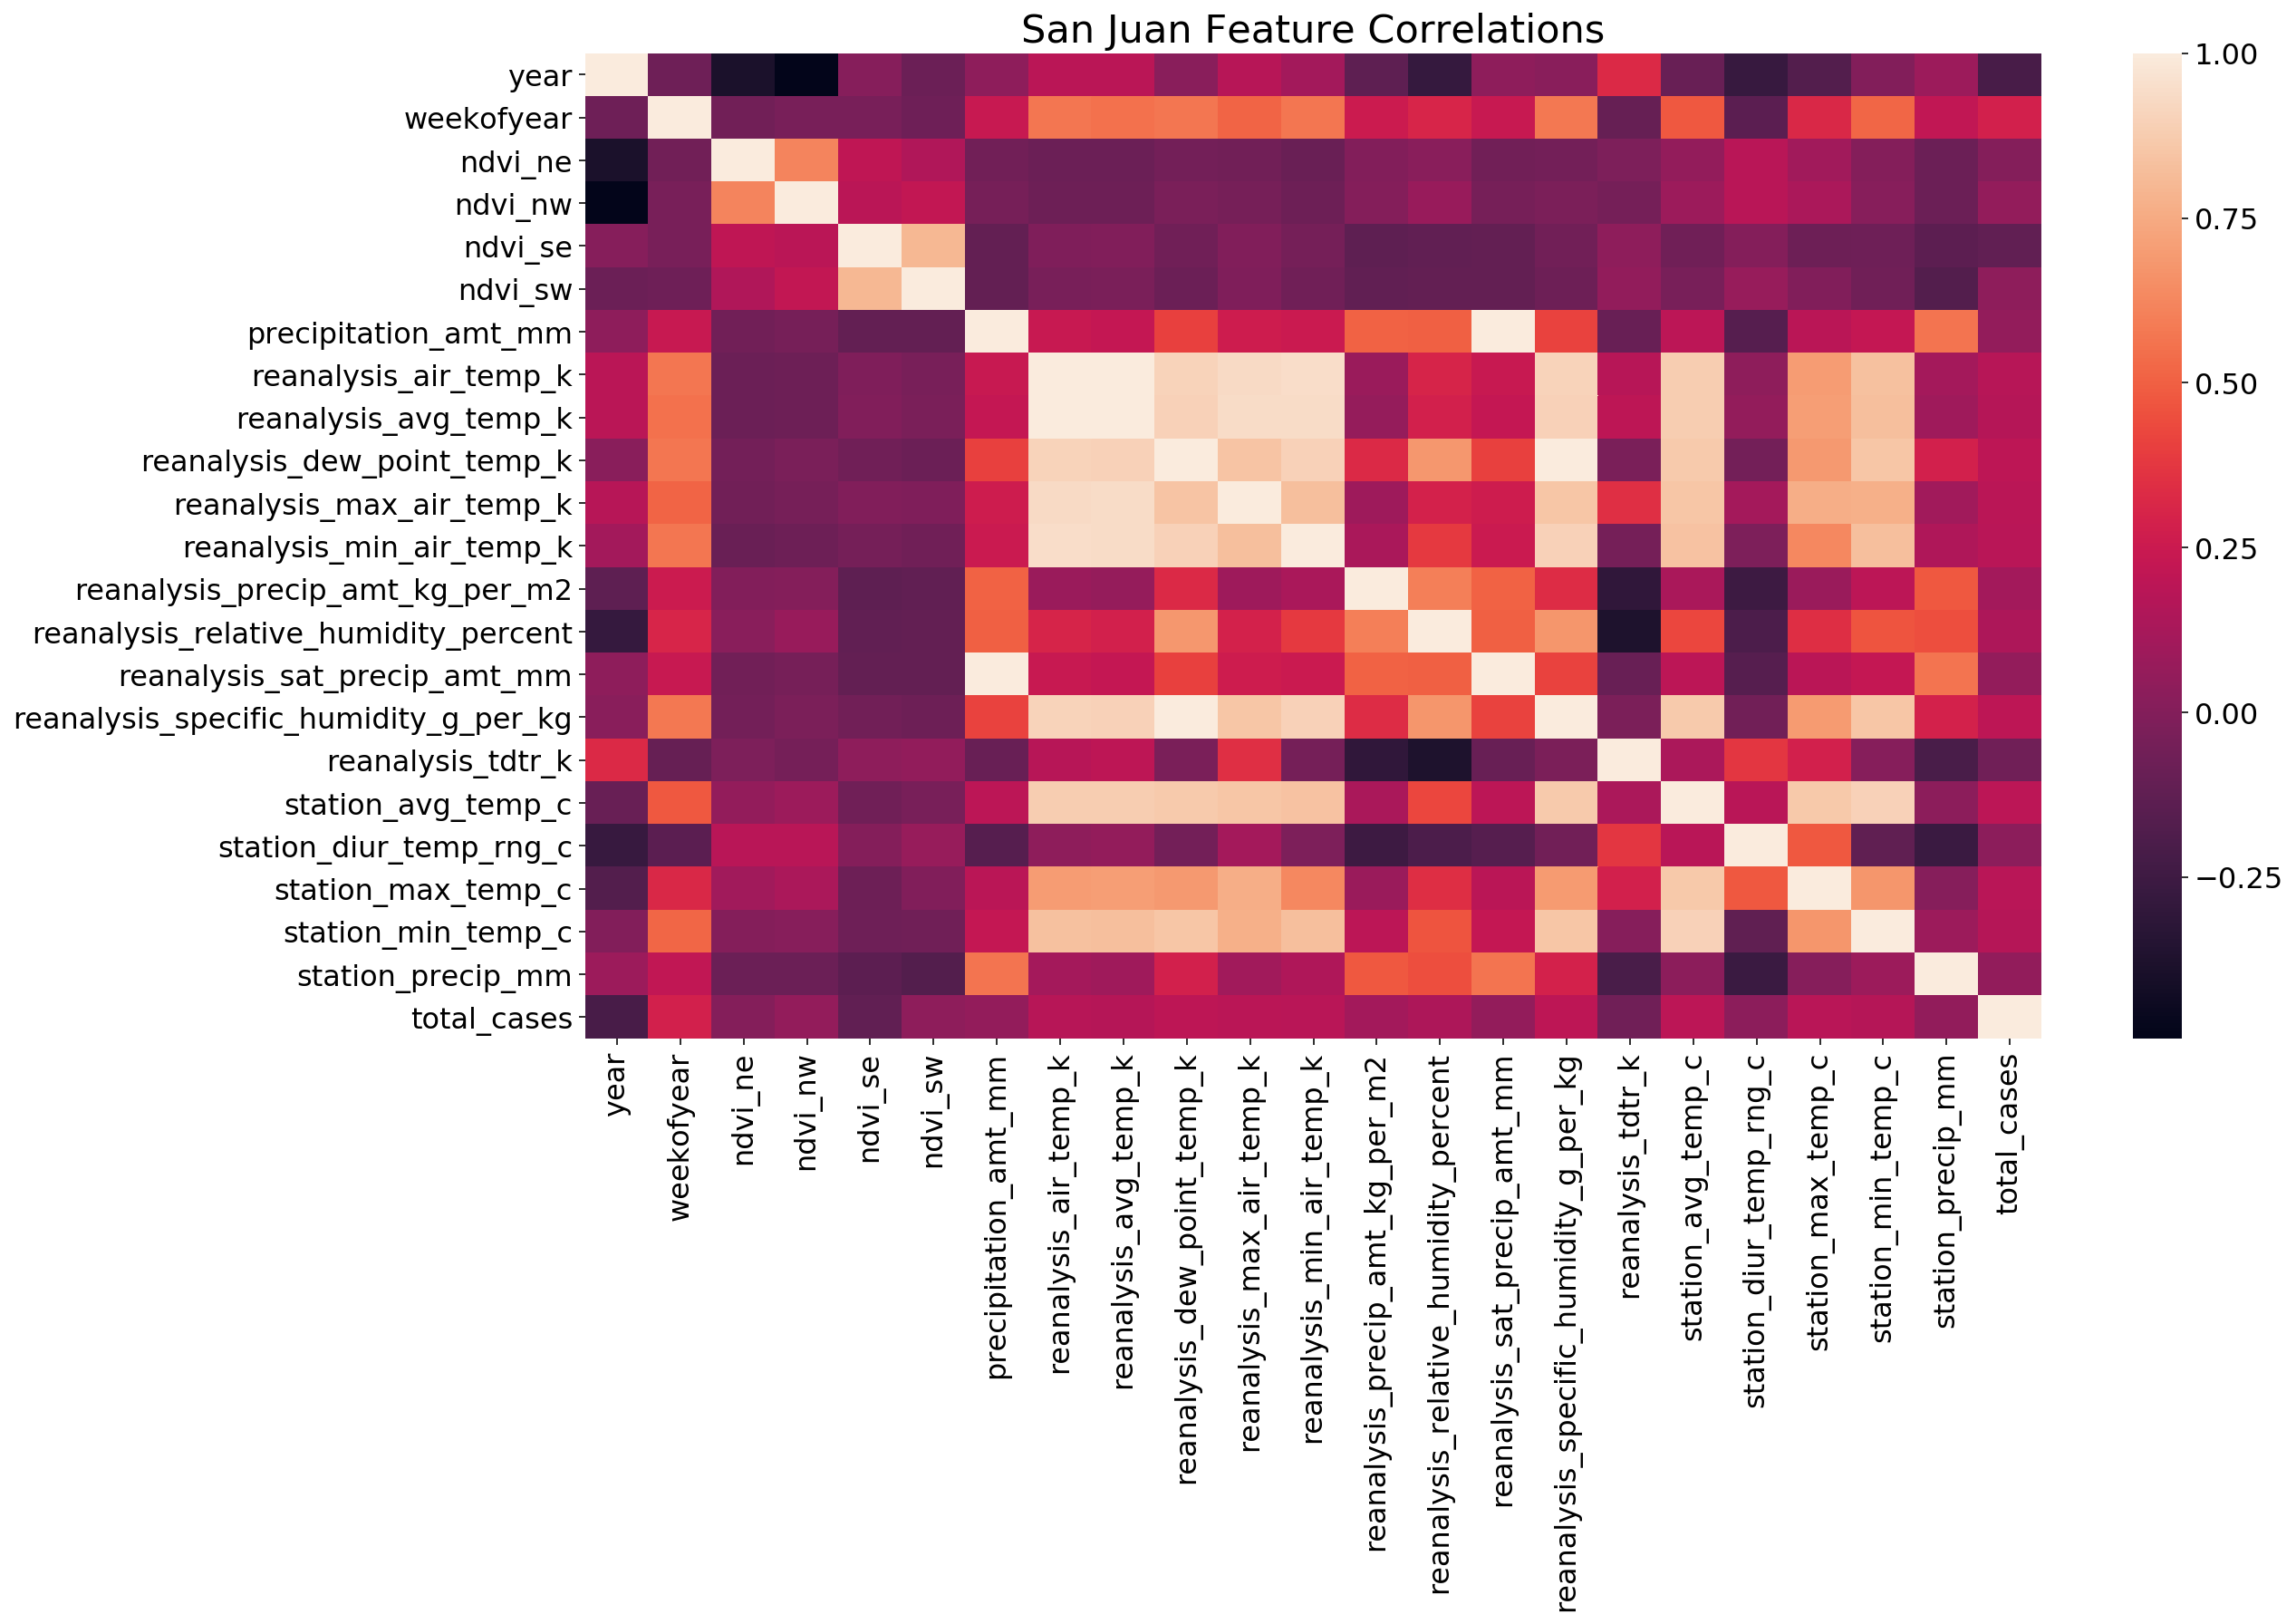

In [10]:
sns.heatmap(sj_training_set.corr())
plt.title("San Juan Feature Correlations")

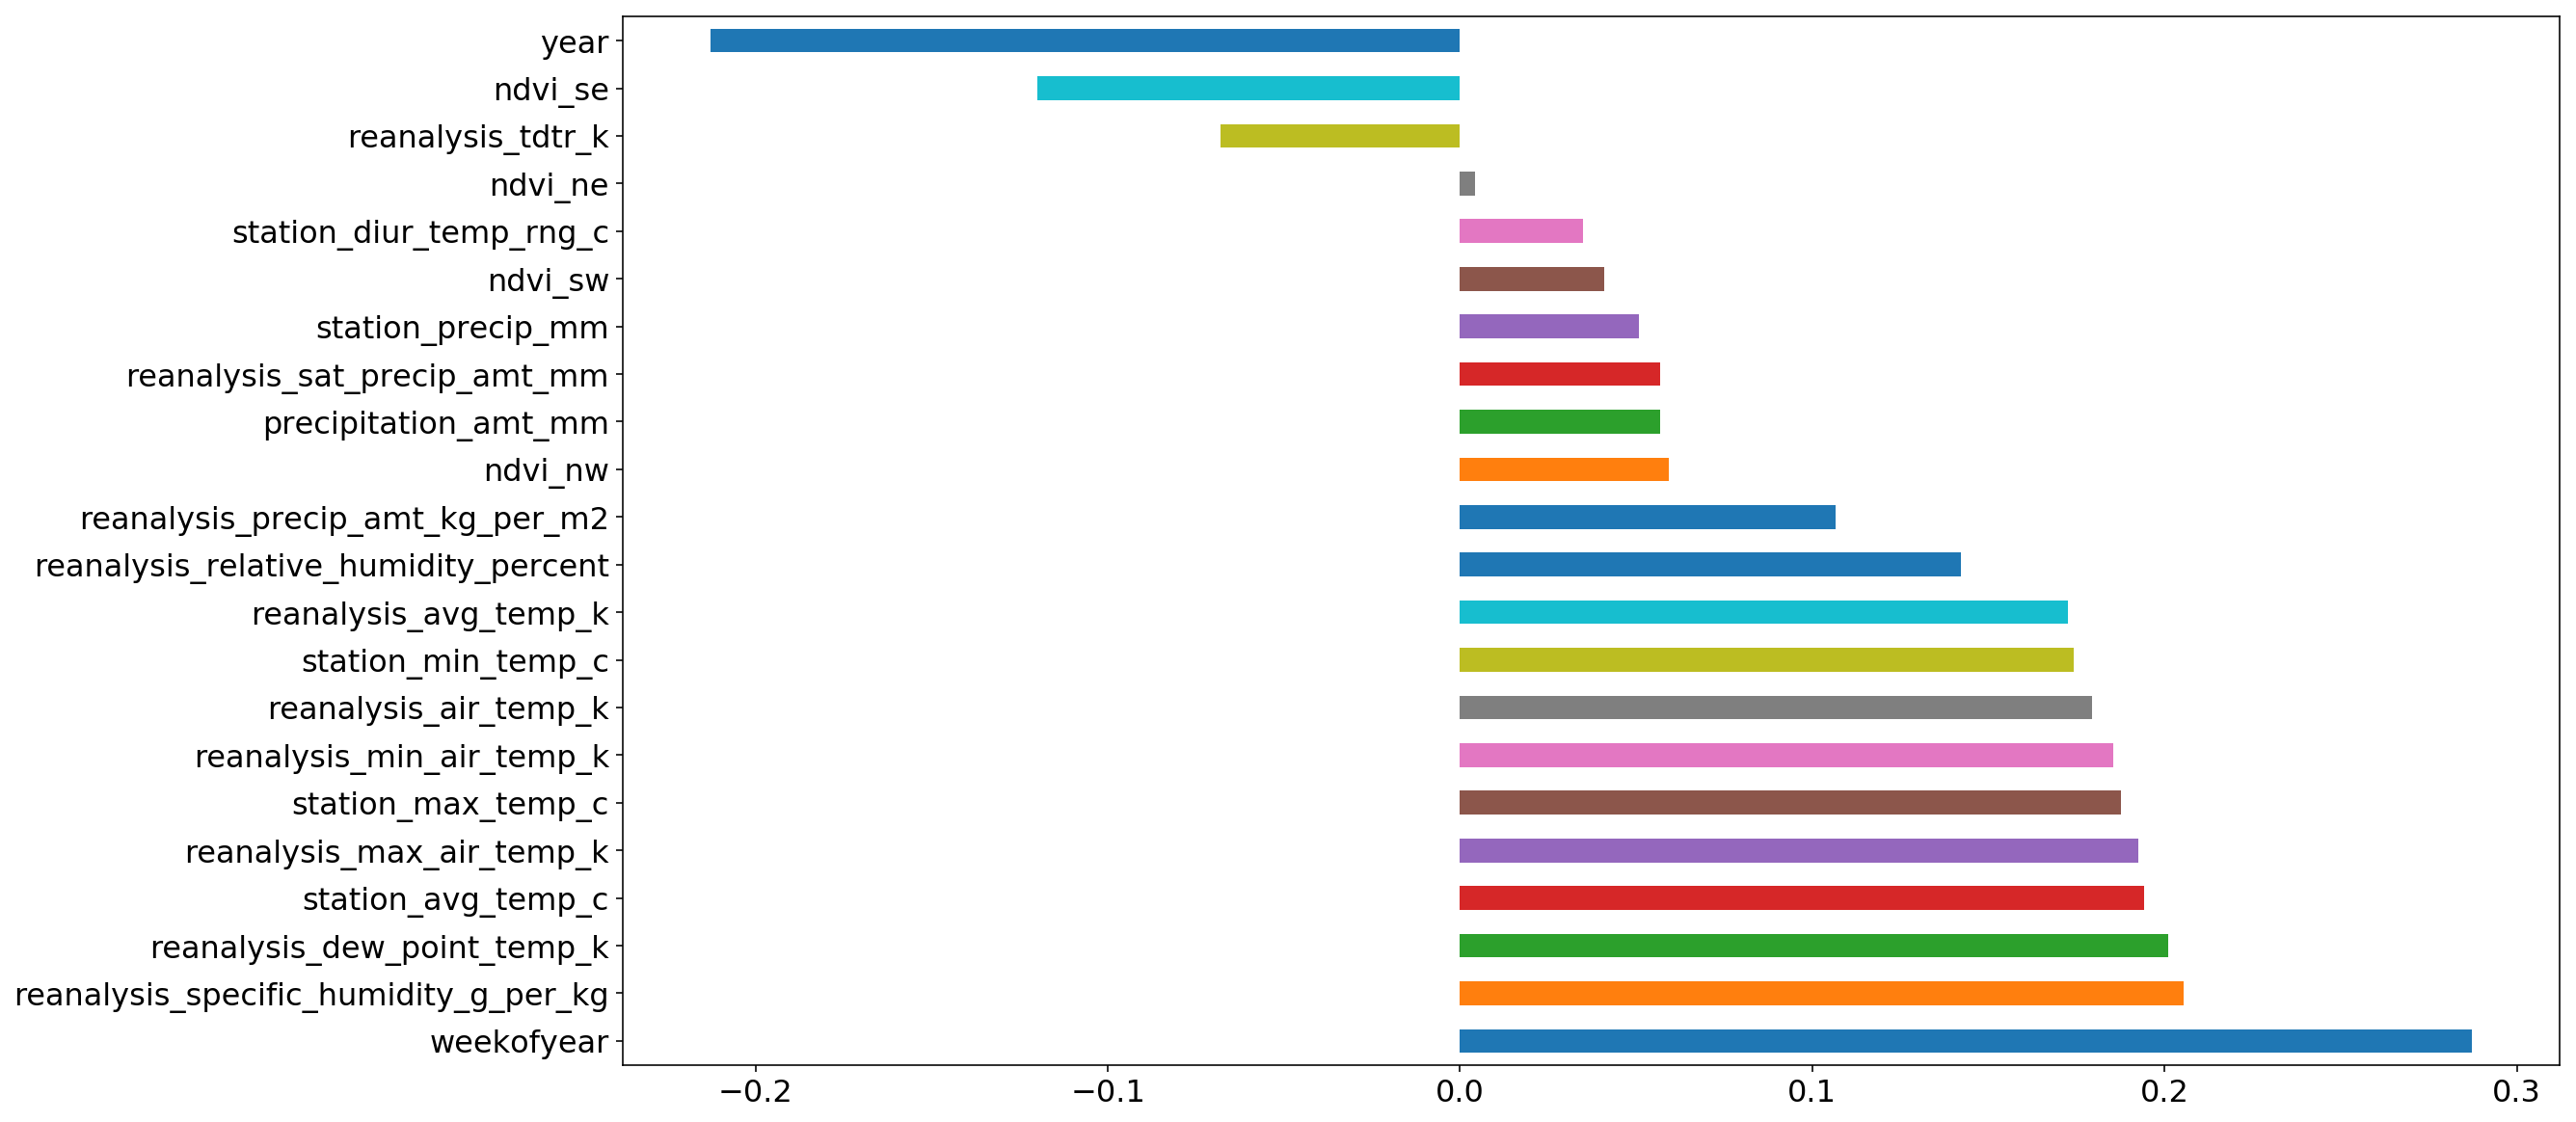

In [11]:
(sj_training_set.corr().total_cases.drop('total_cases').sort_values(ascending=False).plot.barh())

Looking at the plots there is no clear cycle on a time frame more than a year, so it makes sense to drop the `year` column for predictions. There is however a clear annual cycle, so we will keep the `weekofyear` feature however we would would to encode that with a cyclic encoding method in order to tell the algorithm that 52th week is as equally connected to the 1st week as it is connected to the 51st. See: (https://towardsdatascience.com/ml-intro-5-one-hot-encoding-cyclic-representations-normalization-6f6e2f4ec001). 

There are a few other features that have somewhat strong correlations with the total number of cases. It is not a surprise that humidity and temperate are positively correlated with the `total_cases` as we previsouly mentioned that those conditions are perfect for mosqito survival. We will take all correlations that have correlation coefficients above 0.1 which are:
    `reanalysis_precip_amt_kg_per_m2`
    `reanalysis_relative_humidity_percent`
    `reanalysis_avg_temp_k`
    `station_min_temp_c`
    `reanalysis_air_temp_k`
    `reanalysis_min_air_temp_k`
    `station_max_temp_c`
    `reanalysis_max_air_temp_k`
    `station_avg_temp_c`
    `reanalysis_dew_point_temp_k`
    `reanalysis_specific_humidity_g_per_kg`
    
The learning of some models can be improved by standartising the feature values to only vary between 0 and 1, thus reducing the learning parameter space. Specificaly when training a Neural Network, it will converge fatser when all the features that are presented to the model are on the same scale. We will use the scikit MinMaxScaler as it preserves the distribution shape of the original data (https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02). Looking at the distribution of data for both cities it is clear that the total number of cases follows an exponential with a positive skew. The MinMaxScaler also does not reduce the importance of outliers and exactly the outlier indicate the fever outbreaks.

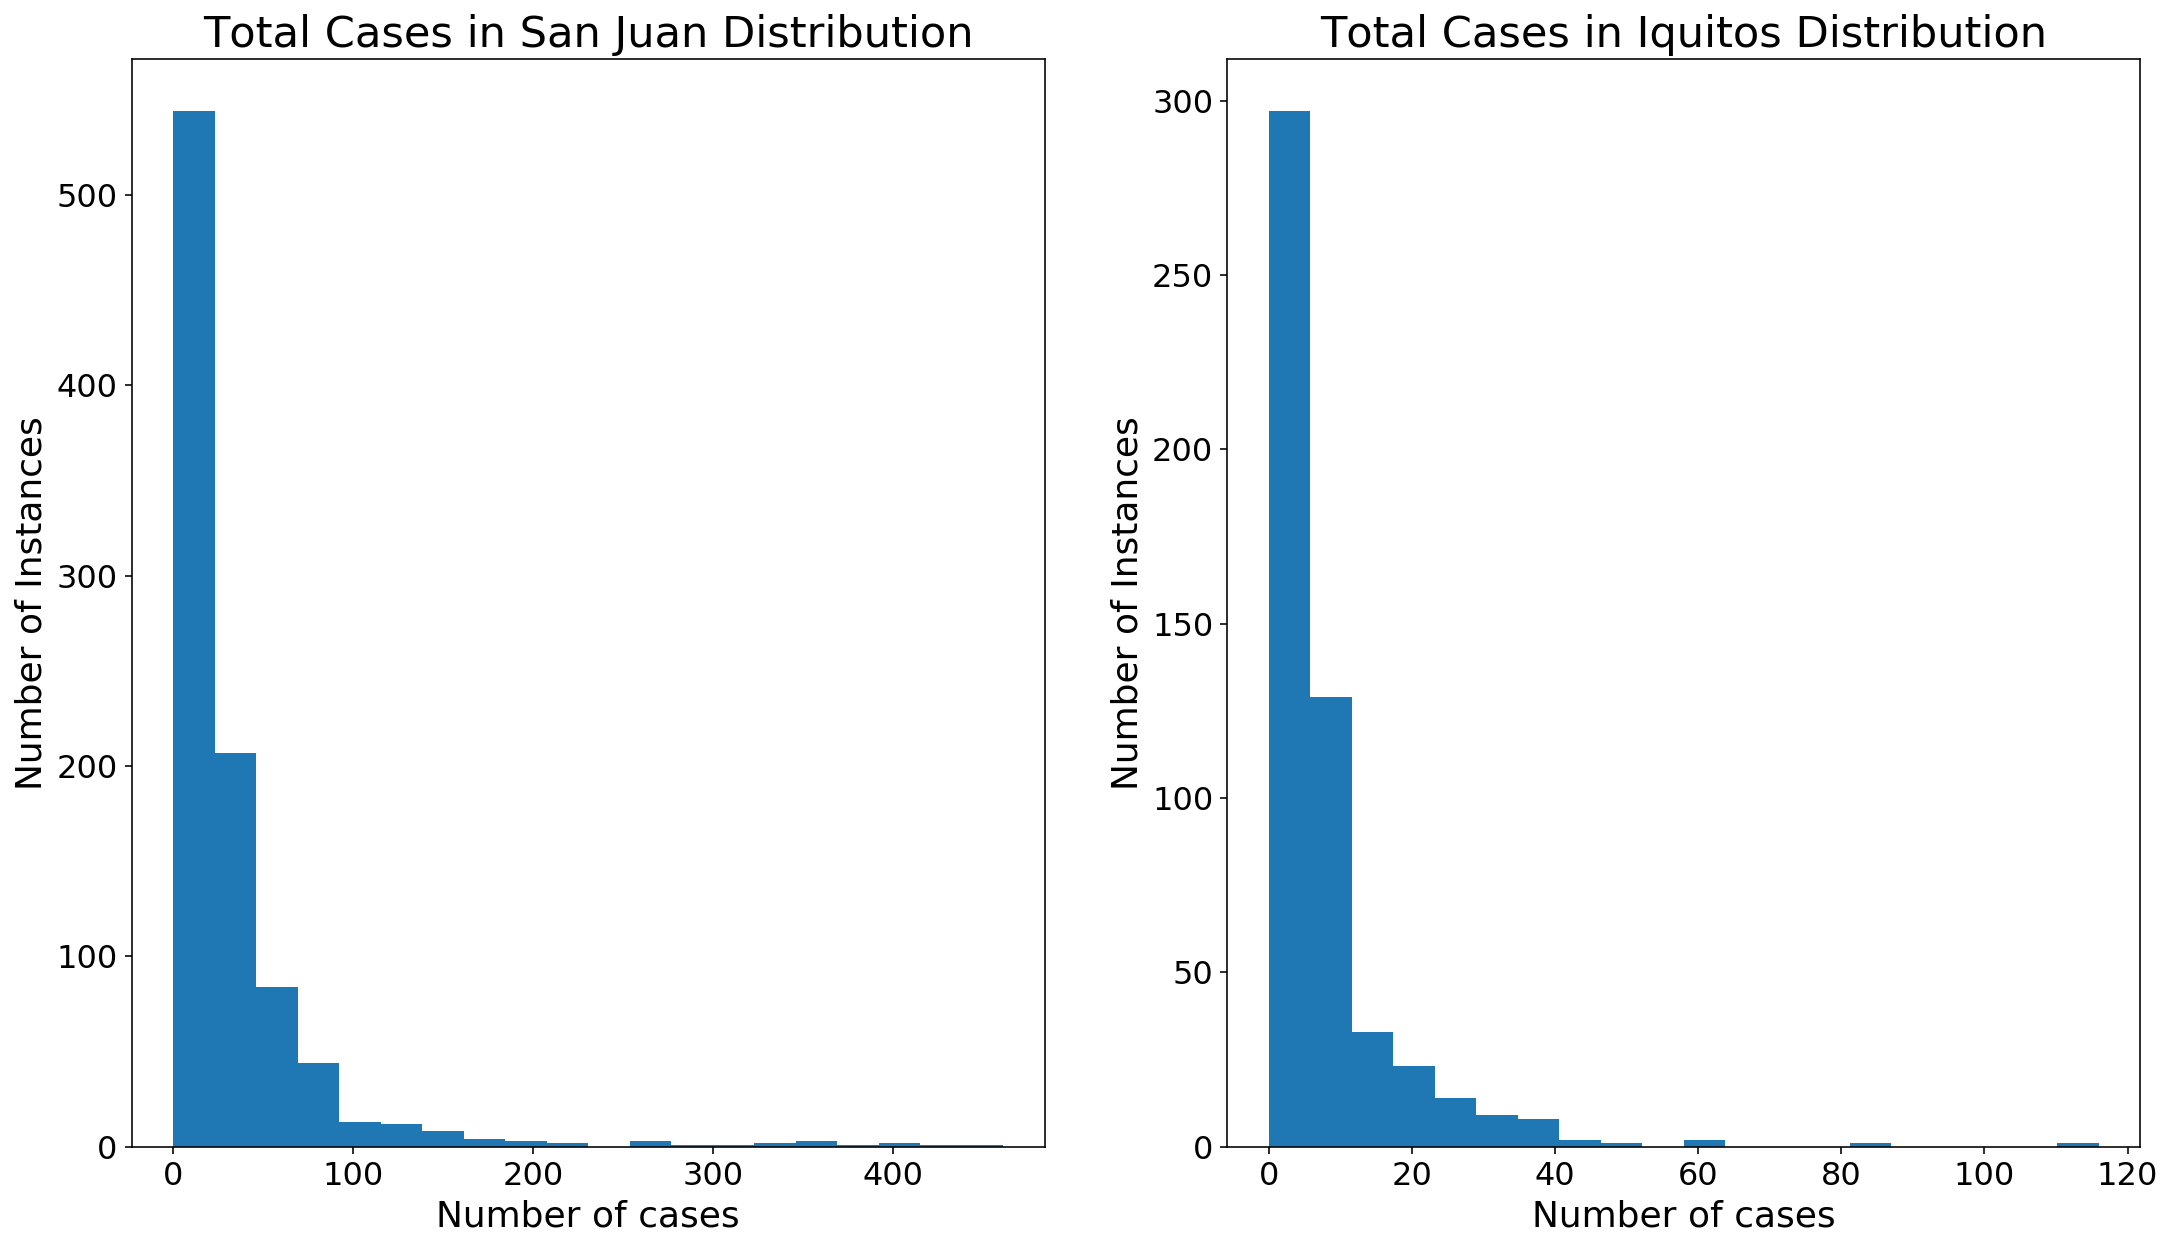

In [16]:
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.hist(sj_training_set['total_cases'],bins = 20)
ax1.set_title("Total Cases in San Juan Distribution")
ax1.set_xlabel("Number of cases")
ax1.set_ylabel('Number of Instances')

ax2 = fig.add_subplot(1,2,2)
ax2.hist(iq_training_set['total_cases'], bins = 20)
ax2.set_title("Total Cases in Iquitos Distribution")
ax2.set_xlabel("Number of cases")
ax2.set_ylabel('Number of Instances')
plt.show()

In [14]:
sj_training_set.columns

Index(['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'total_cases',
       'sin_weekofyear', 'cos_weekofyear'],
      dtype='object')

In [102]:
training_columns = [ 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'sin_weekofyear', 'cos_weekofyear']

#Cyclic Encoding the weeks of the year
sj_training_set['sin_weekofyear'] = np.sin(2*np.pi*(sj_training_set['weekofyear']/53))
sj_training_set['cos_weekofyear'] = np.cos(2*np.pi*(sj_training_set['weekofyear']/53))

sj_test_features['sin_weekofyear'] = np.sin(2*np.pi*(sj_test_features['weekofyear']/53))
sj_test_features['cos_weekofyear'] = np.cos(2*np.pi*(sj_test_features['weekofyear']/53))

iq_training_set['sin_weekofyear'] = np.sin(2*np.pi*(iq_training_set['weekofyear']/53))
iq_training_set['cos_weekofyear'] = np.cos(2*np.pi*(iq_training_set['weekofyear']/53))

iq_test_features['sin_weekofyear'] = np.sin(2*np.pi*(iq_test_features['weekofyear']/53))
iq_test_features['cos_weekofyear'] = np.cos(2*np.pi*(iq_test_features['weekofyear']/53))

X_sj = sj_training_set[training_columns]
Y_sj = sj_training_set['total_cases']
sj_test = sj_test_features[training_columns]

X_iq = iq_training_set[training_columns]
Y_iq = iq_training_set['total_cases']
iq_test = iq_test_features[training_columns]

C:\Users\19ver\Anaconda2\envs\Py35\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\19ver\Anaconda2\envs\Py35\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Users\19ver\Anaconda2\envs\Py35\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [48]:
# sUsing standart scaler
from sklearn.preprocessing import MinMaxScaler
sc_sj = MinMaxScaler()
sc_iq = MinMaxScaler()

non_transformed_features = 2

# uncomment for either scaled or non-scaled features
X_sj_transformed = np.array(pd.DataFrame(sc_sj.fit_transform(X_sj.iloc[:,:-non_transformed_features])).join(X_sj.iloc[:,-non_transformed_features:]))
#X_sj_transformed = np.array(X_sj)

Y_sj = np.array(Y_sj)

#sj_test_transformed = np.array(sj_test)
sj_test_transformed = np.array(pd.DataFrame(sc_sj.transform(sj_test.iloc[:,:-non_transformed_features])).join(sj_test.iloc[:,-non_transformed_features:]))

X_iq_transformed = pd.DataFrame(sc_iq.fit_transform(X_iq.iloc[:,:-non_transformed_features]))
X_iq_transformed['sin_weekofyear'] = np.array(X_iq.iloc[:,-2])
X_iq_transformed['cos_weekofyear'] = np.array(X_iq.iloc[:,-1])
X_iq_transformed = np.array(X_iq_transformed)

Y_iq = np.array(Y_iq)

iq_test_transformed = pd.DataFrame(sc_iq.transform(iq_test.iloc[:,:-non_transformed_features]))
iq_test_transformed['sin_weekofyear'] = np.array(iq_test.iloc[:,-2])
iq_test_transformed['cos_weekofyear'] = np.array(iq_test.iloc[:,-1])
iq_test_transformed = np.array(iq_test_transformed)

In [49]:
X_train_sj, X_test_sj = train_test_split(X_sj_transformed,test_size=0.25,shuffle=False)
Y_train_sj, Y_test_sj = train_test_split(Y_sj,test_size=0.25,shuffle=False)
print("San Juan")
print ("Shape Train: {}, Shape Test: {}".format(X_train_sj.shape, X_test_sj.shape))

X_train_iq, X_test_iq = train_test_split(X_iq_transformed,test_size=0.25,shuffle=False)
Y_train_iq, Y_test_iq = train_test_split(Y_iq,test_size=0.25,shuffle=False)
print("Iquitos")
print ("Shape Train: {}, Shape Test: {}".format(X_train_iq.shape, X_test_iq.shape))

San Juan
Shape Train: (702, 22), Shape Test: (234, 22)
Iquitos
Shape Train: (390, 22), Shape Test: (130, 22)


# Training Ridge Regression

One of the simplest regression algorithm that we can try to use for case number predictions. We want to make the use of cross-validation technique to accurate tune the model for better learning and check for overfitting. We split data into 3 chunks, 2 for training one for validation per fold. This is because each training set is required to be representative of the general pattern and thus a similar size to the test set.

In [51]:
cv_obj = TimeSeriesSplit(n_splits=3)

alpha_ridge =[0.001,0.01,0.1,1,10,100,1000,1500,10000,100000]
parameters_Ridge = {
    'alpha': alpha_ridge,
    'fit_intercept': [True, False],
    'max_iter':[10,100,1000,10000],
    'random_state':[100,1000,10000]
             }

In [52]:
%%time
#defines the regression object and wraps around this a GridSearchCV object, which defines that we run over the alpha parameters defined above
regr_sj = GridSearchCV(Ridge(),parameters_Ridge,cv=cv_obj,n_jobs=-1,refit=True)
# n_jobs = -1 says to use the maximum number of CPUs on the machine

# fitting the function does all the cross-validation and regression optimization 
regr_sj.fit(X_train_sj,Y_train_sj)

Y_pred_sj = regr_sj.best_estimator_.predict(X_test_sj)

# one might also want to test the predictions on the training dataset. Do we overfit in comparison to the test data?
Y_pred_train_sj = regr_sj.best_estimator_.predict(X_train_sj)

# to check what was the best estimnator just run
print("Best Alpha:{}".format(regr_sj.best_estimator_.alpha))
print("Best Fit Intercept: {}".format(regr_sj.best_estimator_.fit_intercept))
print("Best Max Iter: {}".format(regr_sj.best_estimator_.max_iter))

# saving results as a dataframe
results_ridge_sj = pd.DataFrame(regr_sj.cv_results_)
Y_sub_pred_sj = regr_sj.best_estimator_.predict(sj_test_transformed)

# use actual predictions and validate them
print('Correlation coefficient: {}'.format(np.corrcoef(Y_test_sj,Y_pred_sj)[0,1]))
print('Mean Square Error: {}'.format(mean_squared_error(Y_test_sj,Y_pred_sj)))
print('Mean Absolute Error: {}'.format(mean_absolute_error(Y_test_sj,Y_pred_sj)))

# this can be used to access how well does the model does prediction on the train set 
#print ('Correlation coefficient train: {}'.format(np.corrcoef(Y_pred_train_sj, Y_train_sj)[0,1]))
#print('Mean Absolute Error Train: {}'.format(mean_absolute_error(Y_train_sj,Y_pred_train_sj)))

Best Alpha:1500
Best Fit Intercept: False
Best Max Iter: 10
Correlation coefficient: 0.5644554206621448
Mean Square Error: 634.4818745038739
Mean Absolute Error: 17.384565522227813
Wall time: 1.98 s


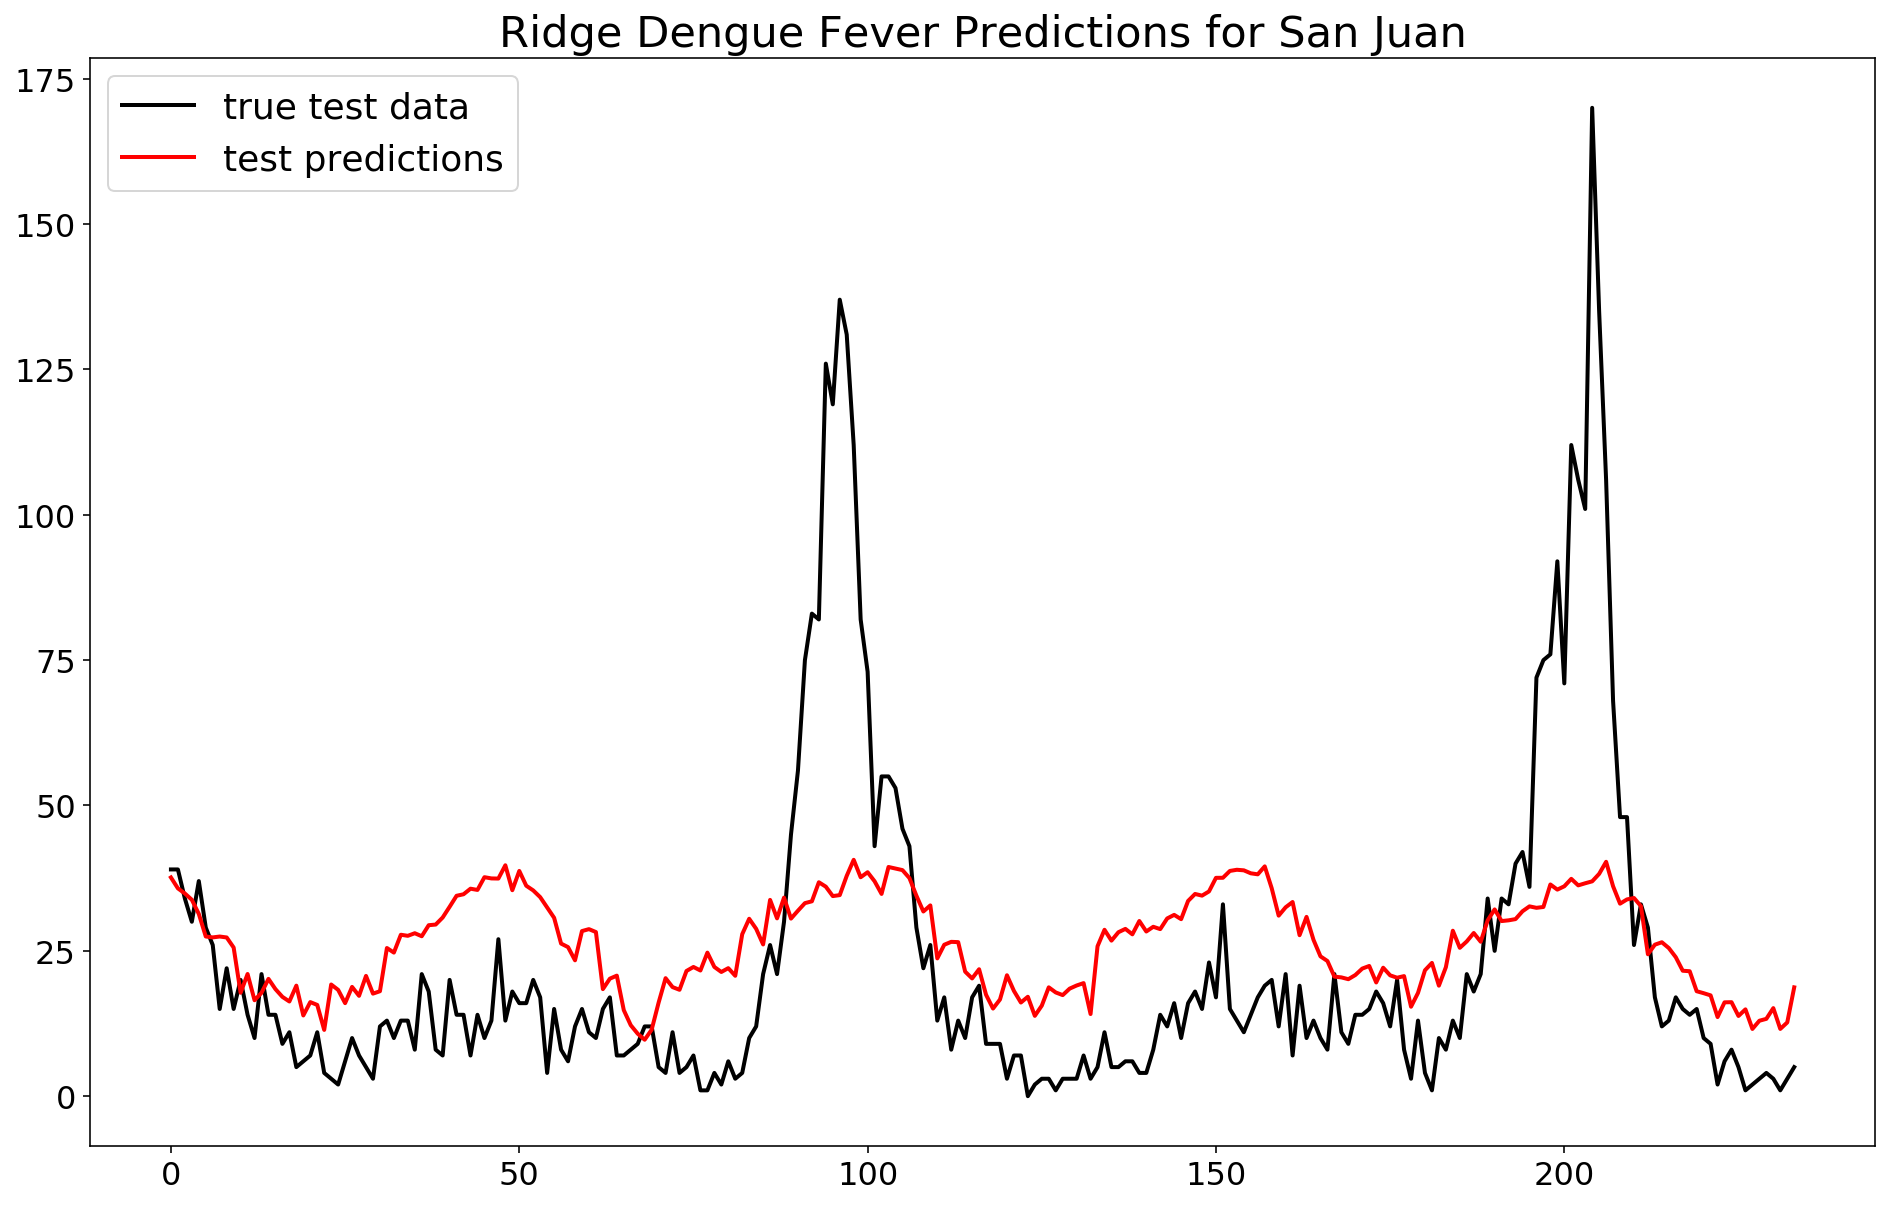

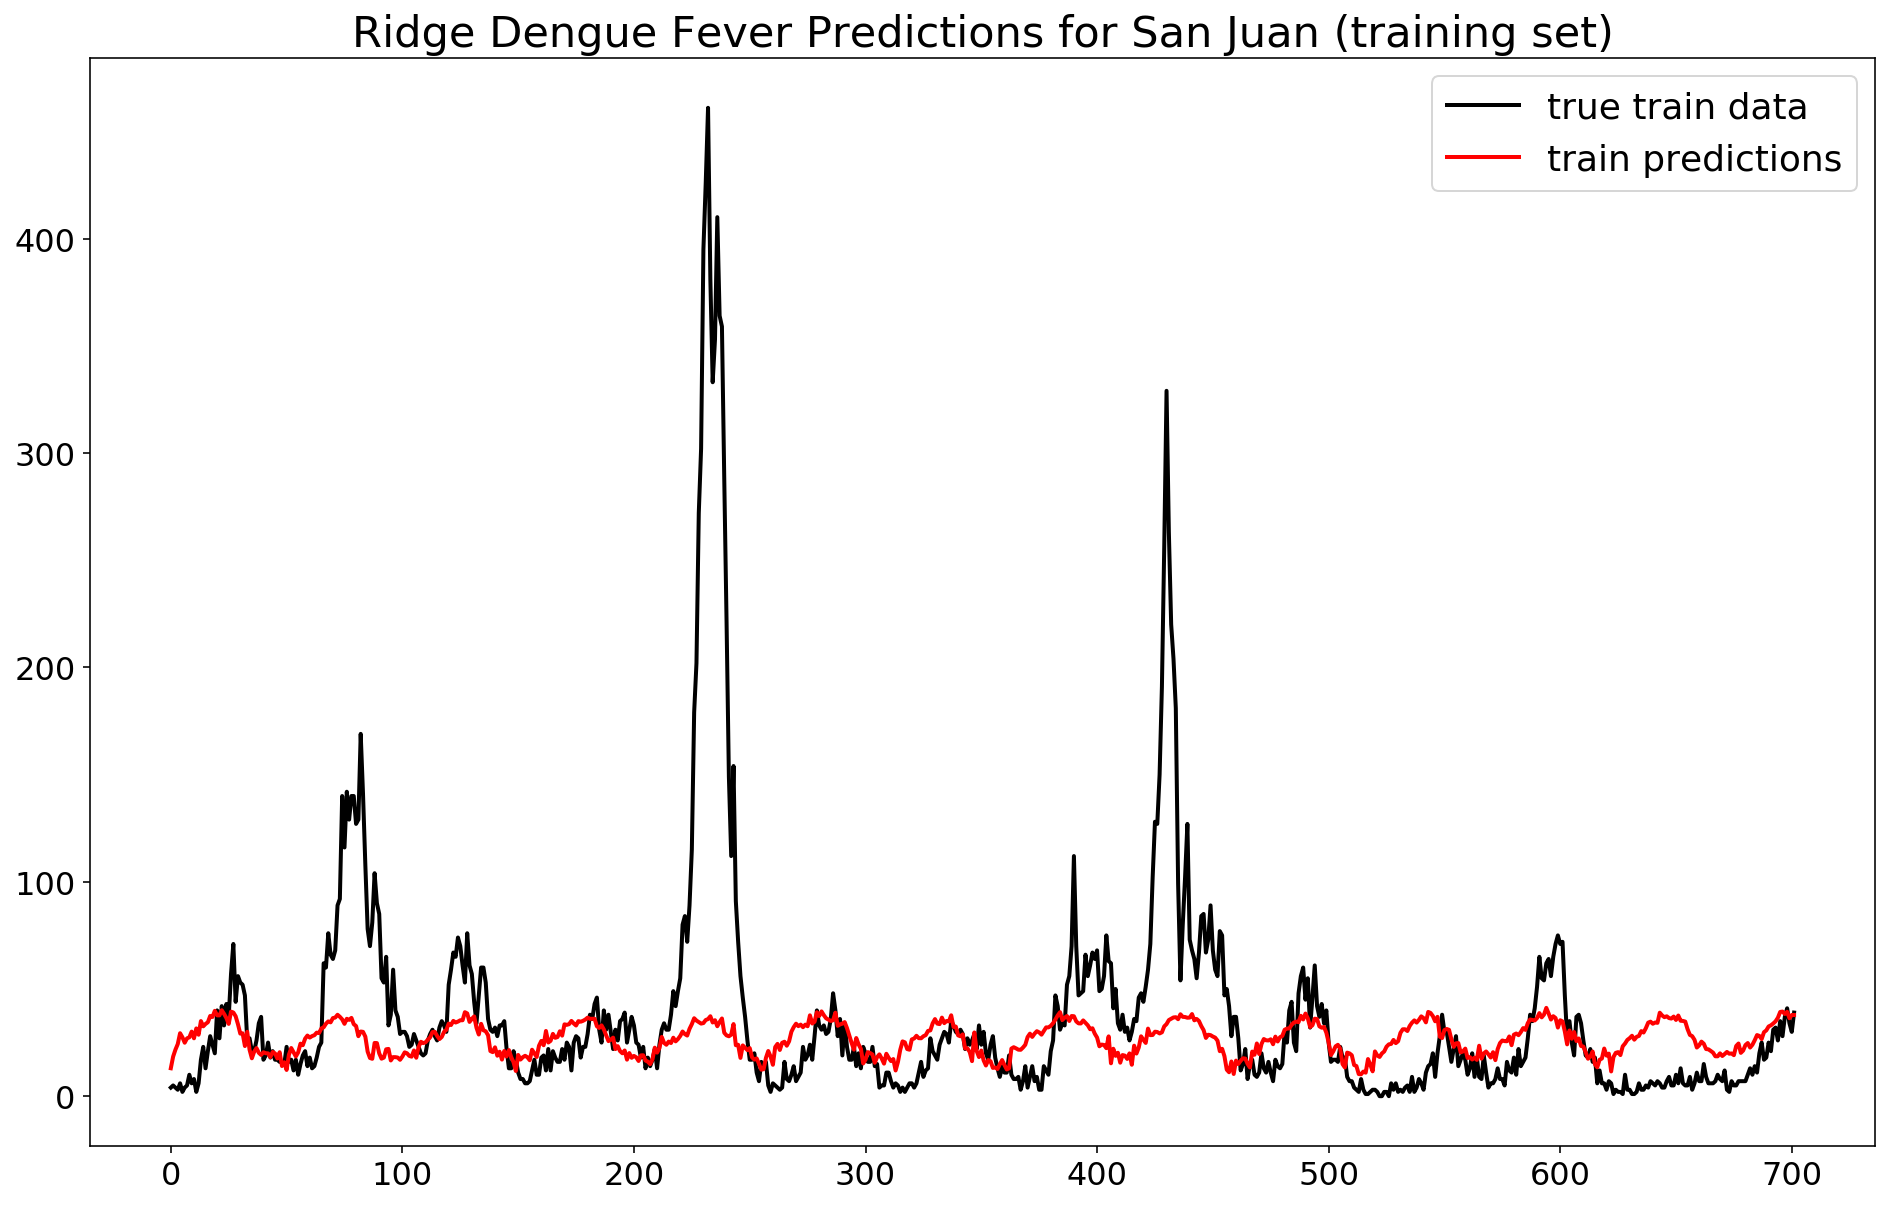

In [53]:
# Plot parameters: experiment with different values
params = {
   'axes.labelsize': 18,# Set to size 8 to start with
   'font.size': 18,# Set to size 8 to start with
   'font.family': 'sans-serif', # Not given initially - only optional
   'font.serif': 'Arial', # Not given initially - only optional
   'legend.fontsize': 18,# Set to size 8 to start with
   'xtick.labelsize': 16,# Set to size 8 to start with
   'ytick.labelsize': 16, # Set to size 8 to start with
   'figure.figsize': [16, 10] # Set to [6,4] to start with 
} 
plt.rcParams.update(params)
plt.plot(np.arange(0,len(Y_test_sj),1),Y_test_sj, color='k',label='true test data', linewidth=2)
plt.plot(np.arange(0,len(Y_test_sj),1), Y_pred_sj, color='r',label='test predictions', linewidth=2)
plt.legend(loc='best')
plt.title('Ridge Dengue Fever Predictions for San Juan')
#plt.savefig("Ridge_cyclic_encoding_variability_semi_seasonal_regionalAv.png")
plt.show()

plt.title('Ridge Dengue Fever Predictions for San Juan (training set)')
plt.plot(np.arange(0,len(Y_train_sj),1), Y_train_sj, color='k', label='true train data', linewidth=2)
plt.plot(np.arange(0,len(Y_train_sj),1), Y_pred_train_sj, color='r',label='train predictions', linewidth=2)
plt.legend(loc='best')
plt.show()

### Ridge predictions for Iquitos 

In [54]:
%%time
#defines the regression object and wraps around this a GridSearchCV object, which defines that we run over the alpha parameters defined above
regr_iq = GridSearchCV(Ridge(),parameters_Ridge,cv=cv_obj,n_jobs=-1,refit=True)
# n_jobs = -1 says to use the maximum number of CPUs on the machine

# fitting the function does all the cross-validation and regression optimization 
regr_iq.fit(X_train_iq,Y_train_iq)

Y_pred_iq = regr_iq.best_estimator_.predict(X_test_iq)

# one might also want to test the predictions on the training dataset. Do we overfit in comparison to the test data?
Y_pred_train_iq = regr_iq.best_estimator_.predict(X_train_iq)

# to check what was the best estimnator just run
print("Best Alpha:{}".format(regr_iq.best_estimator_.alpha))
print("Best Fit Intercept: {}".format(regr_iq.best_estimator_.fit_intercept))
print("Best Max Iter: {}".format(regr_iq.best_estimator_.max_iter))

# saving results as a dataframe
results_ridge_iq = pd.DataFrame(regr_iq.cv_results_)
Y_sub_pred_iq = regr_iq.best_estimator_.predict(iq_test_transformed)

# use actual predictions and validate them
print('Correlation coefficient: {}'.format(np.corrcoef(Y_test_iq,Y_pred_iq)[0,1]))
print('Mean Square Error: {}'.format(mean_squared_error(Y_test_iq,Y_pred_iq)))
print('Mean Absolute Error: {}'.format(mean_absolute_error(Y_test_iq,Y_pred_iq)))

#print ('Correlation coefficient train: {}'.format(np.corrcoef(Y_pred_train_iq, Y_train_iq)[0,1]))
#print('Mean Absolute Error Train: {}'.format(mean_absolute_error(Y_train_iq,Y_pred_train_iq)))

Best Alpha:100
Best Fit Intercept: True
Best Max Iter: 10
Correlation coefficient: 0.4540970665185601
Mean Square Error: 152.10584305283265
Mean Absolute Error: 7.365719058384325
Wall time: 639 ms


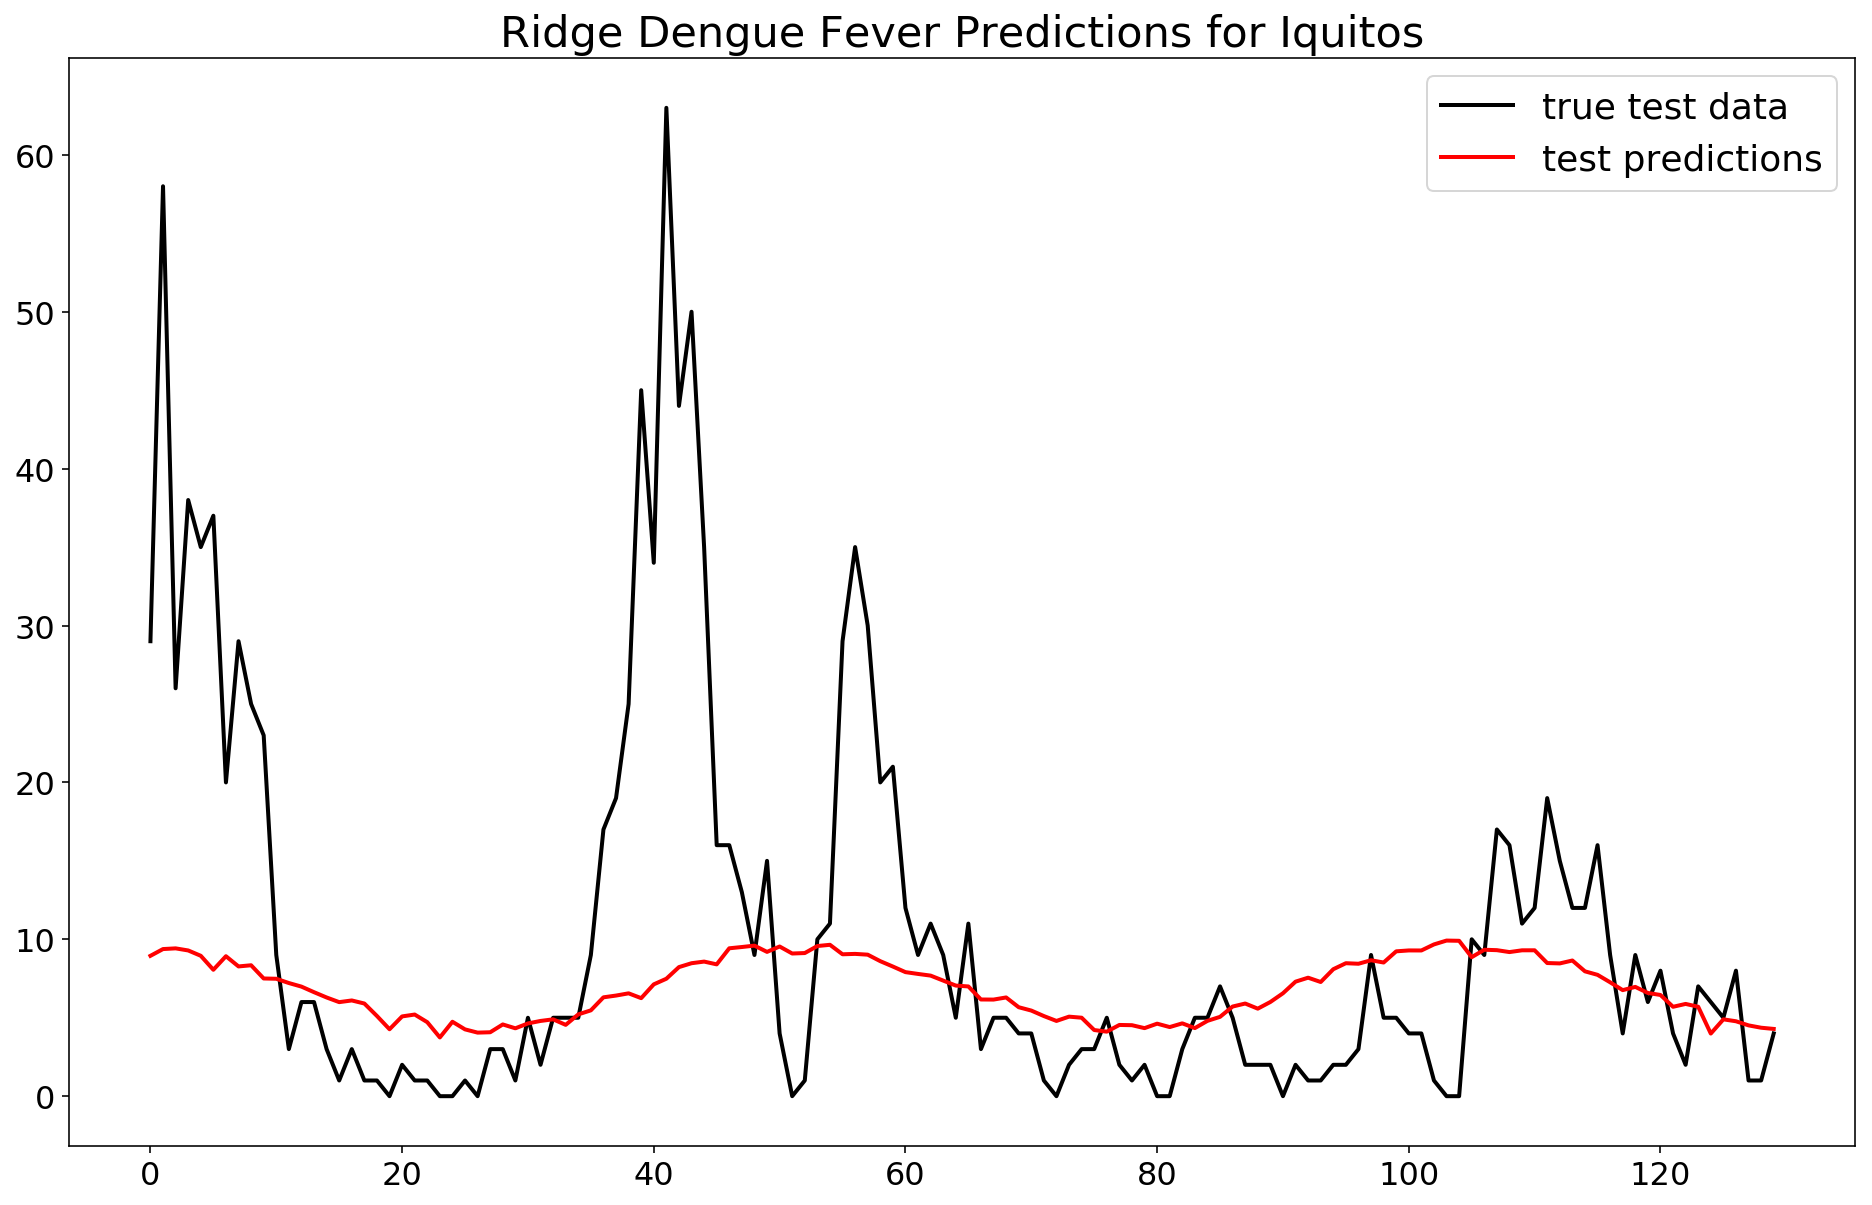

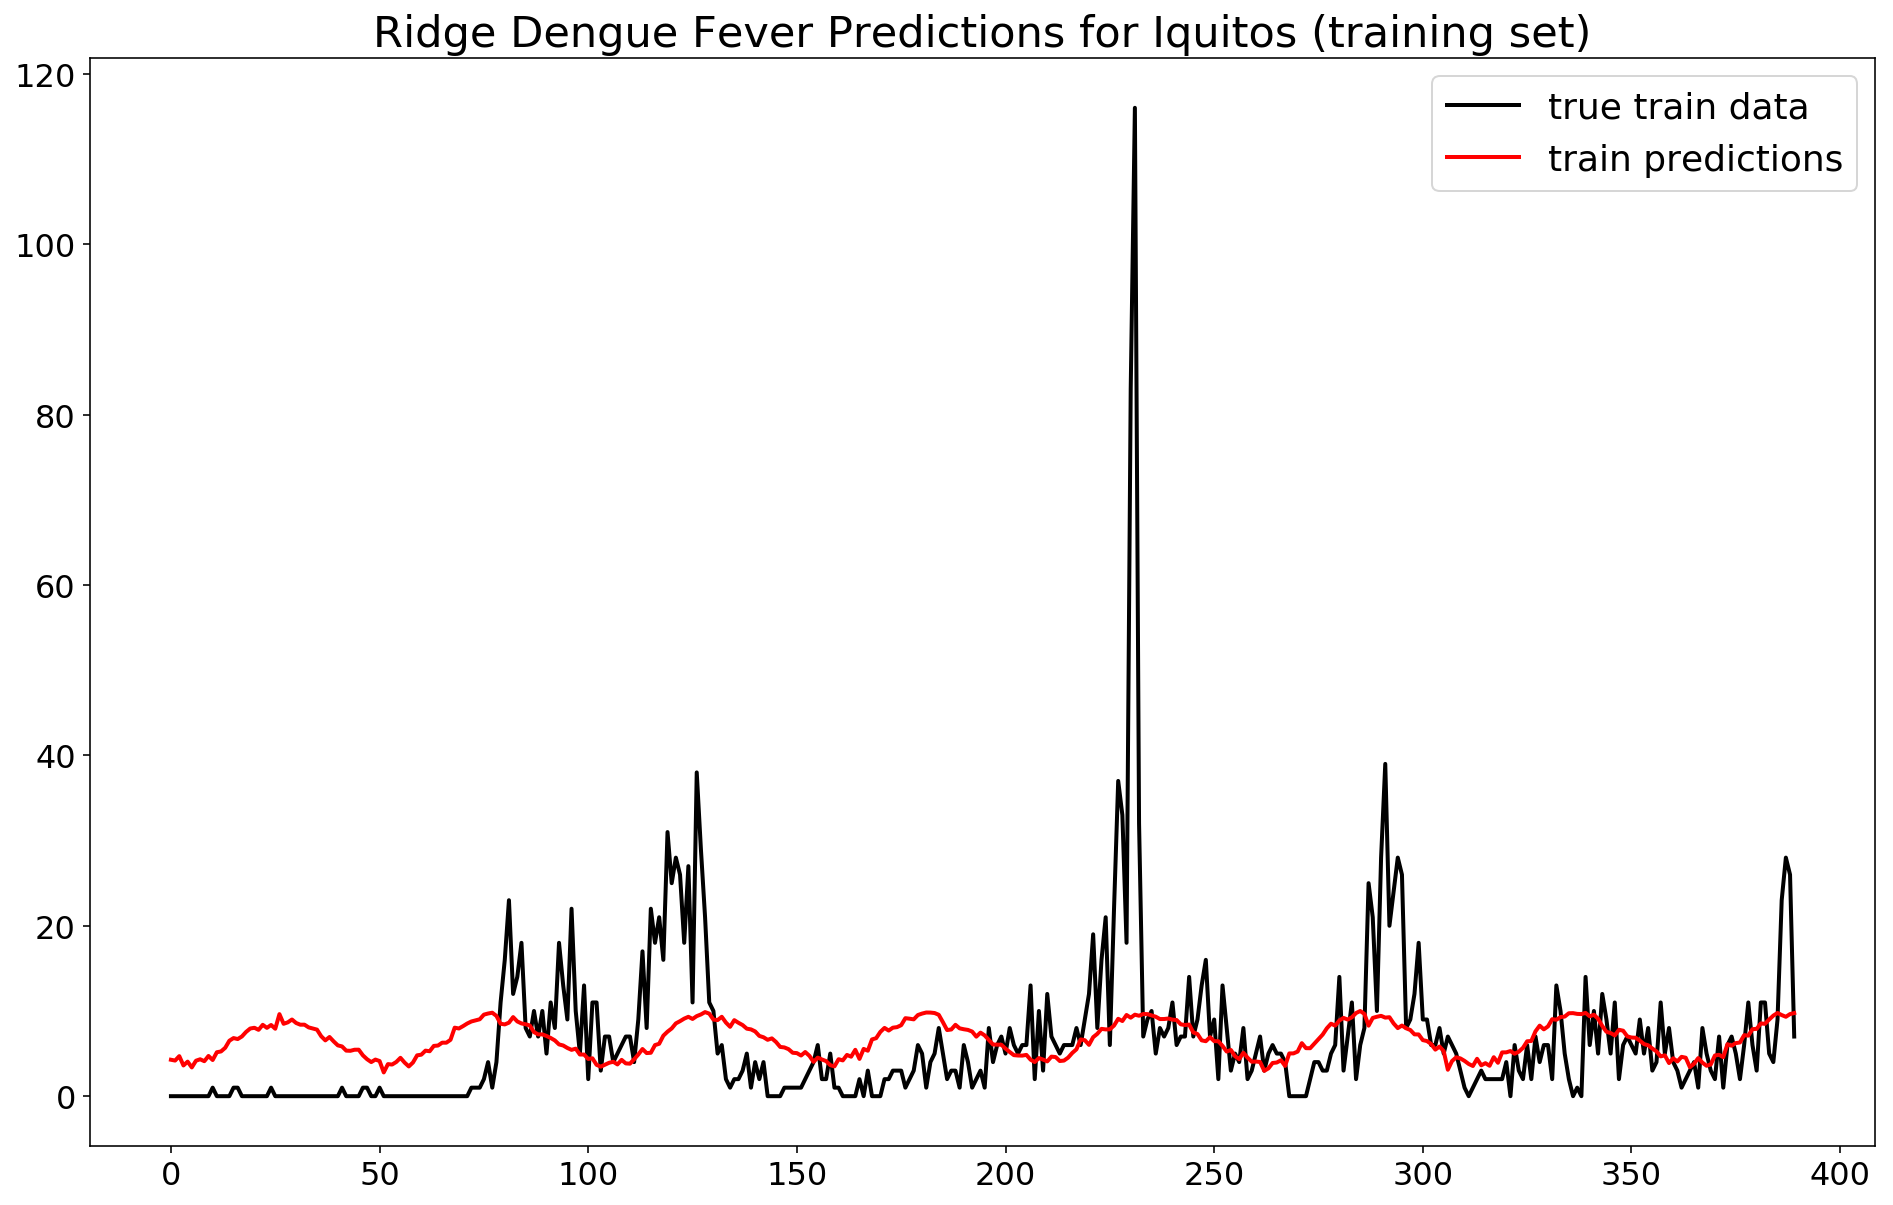

In [55]:
plt.rcParams.update(params)
plt.plot(np.arange(0,len(Y_test_iq),1),Y_test_iq, color='k',label='true test data', linewidth=2)
plt.plot(np.arange(0,len(Y_test_iq),1), Y_pred_iq, color='r',label='test predictions', linewidth=2)
plt.legend(loc='best')
plt.title('Ridge Dengue Fever Predictions for Iquitos')
#plt.savefig("Ridge_cyclic_encoding_variability_semi_seasonal_regionalAv.png")
plt.show()

plt.title('Ridge Dengue Fever Predictions for Iquitos (training set)')
plt.plot(np.arange(0,len(Y_train_iq),1), Y_train_iq, color='k', label='true train data', linewidth=2)
plt.plot(np.arange(0,len(Y_train_iq),1), Y_pred_train_iq, color='r',label='train predictions', linewidth=2)
plt.legend(loc='best')
plt.show()

In [76]:
results_format['total_cases'] = np.concatenate(((np.round(Y_sub_pred_sj)),np.round(list(Y_sub_pred_iq))), axis=None).astype(int)

date_today = datetime.now().strftime("%Y-%m-%d")
counter += 1

results_format.to_csv('Dengue_results_for_submittion_Ridge ' + date_today + " attempt " + str(counter) , index=False)

We can see that Ridge Regression does perform well on either of the cities. Looking at the predictions for the training sets it is clear that the model captures teh seasonal trend. The model however struggles to understand the more complicated outbreak trend. It may be due to the fact tha the model is not complex enough and therefore it may not be able to understand the contribution of every feature. The overall MAE score on the submittion data set was 26.2.

# Training Random Forest Regression

We would like to attempt fitting a Random Forest as this model has more complexity and is able to fit more complicated problems. We still make us of the cross-validation defined in the previous section.

In [56]:
num_of_est = [5,10,50,100,1000,10000]
parameters_RF = {
     'n_estimators': num_of_est,
     'max_depth': [1,2,3], # how many branches a tree has 
     'min_samples_split': [2,5], #how many samples you need to create a branch (low number = overfitting )
     'min_samples_leaf': [2,3], # limits how many examples can be at the end of the leaf 
     'max_features': ['auto'], #max steps (70% of the time series)
     'bootstrap': [False],
              }

### Random Forest Predictions for San Juan 

In [57]:
%%time
regr_rf_sj = GridSearchCV(RandomForestRegressor(),parameters_RF,cv=cv_obj,n_jobs=-1,refit=True)

regr_rf_sj.fit(X_train_sj,Y_train_sj)

Y_pred_rf_sj = regr_rf_sj.best_estimator_.predict(X_test_sj)

# Do we overfit in comparison to the test data?
Y_pred_train_rf_sj = regr_rf_sj.best_estimator_.predict(X_train_sj)

print("Best number of Estimators: {}".format(regr_rf_sj.best_estimator_.n_estimators))
print("Best Max Dept: {}".format(regr_rf_sj.best_estimator_.max_depth))
print("Best Min Samples Split: {}".format(regr_rf_sj.best_estimator_.min_samples_split))
print("Best Min Samples Leaf: {}".format(regr_rf_sj.best_estimator_.min_samples_leaf))

results_random_forest = pd.DataFrame(regr_rf_sj.cv_results_)
print('Test:')
print('Correlation coefficient: {}'.format(np.corrcoef(Y_test_sj,Y_pred_rf_sj)[0,1]))
#print('Mean Square Error: {}'.format(mean_squared_error(Y_test_sj,Y_pred_rf_sj)))
print('Mean Absolute Error: {}'.format(mean_absolute_error(Y_test_sj,Y_pred_rf_sj)))

print("Train:")
print('Correlation coefficient train: {}'.format(np.corrcoef(Y_train_sj, Y_pred_train_rf_sj)[0,1]))
print('Mean Absolute Error: {}'.format(mean_absolute_error(Y_pred_train_rf_sj,Y_train_sj)))
feature_importances_sj = pd.DataFrame(regr_rf_sj.best_estimator_.feature_importances_, index = (X_sj.columns), columns=['importance']).sort_values('importance', ascending=False)

Best number of Estimators: 10
Best Max Dept: 3
Best Min Samples Split: 2
Best Min Samples Leaf: 3
Test:
Correlation coefficient: 0.38235669386967824
Mean Absolute Error: 22.53322841579576
Train:
Correlation coefficient train: 0.8322626513679525
Mean Absolute Error: 19.715229048684797
Wall time: 5min 51s


Looking at the feature importance for Random Forest can give us a better idea of what are the most contributing features are to the algorithm performance. They are ranked in the order of the most important to the least important. We will look at the top 10. We can see that the temperature and humidity features are important, whether precipitation is not important at all. This is not a suprising result since we said earlier that humidity and temperature aid mosquito life-cycle. Vegetation index in South East and South West directions of the city centroid were the two most important features.

In [58]:
feature_importances_sj.head(10)

importance
ndvi_se                                  0.554944
ndvi_sw                                  0.241497
sin_weekofyear                           0.078837
reanalysis_specific_humidity_g_per_kg    0.047521
cos_weekofyear                           0.039524
reanalysis_air_temp_k                    0.018839
reanalysis_avg_temp_k                    0.018839
station_precip_mm                        0.000000
station_min_temp_c                       0.000000
station_max_temp_c                       0.000000

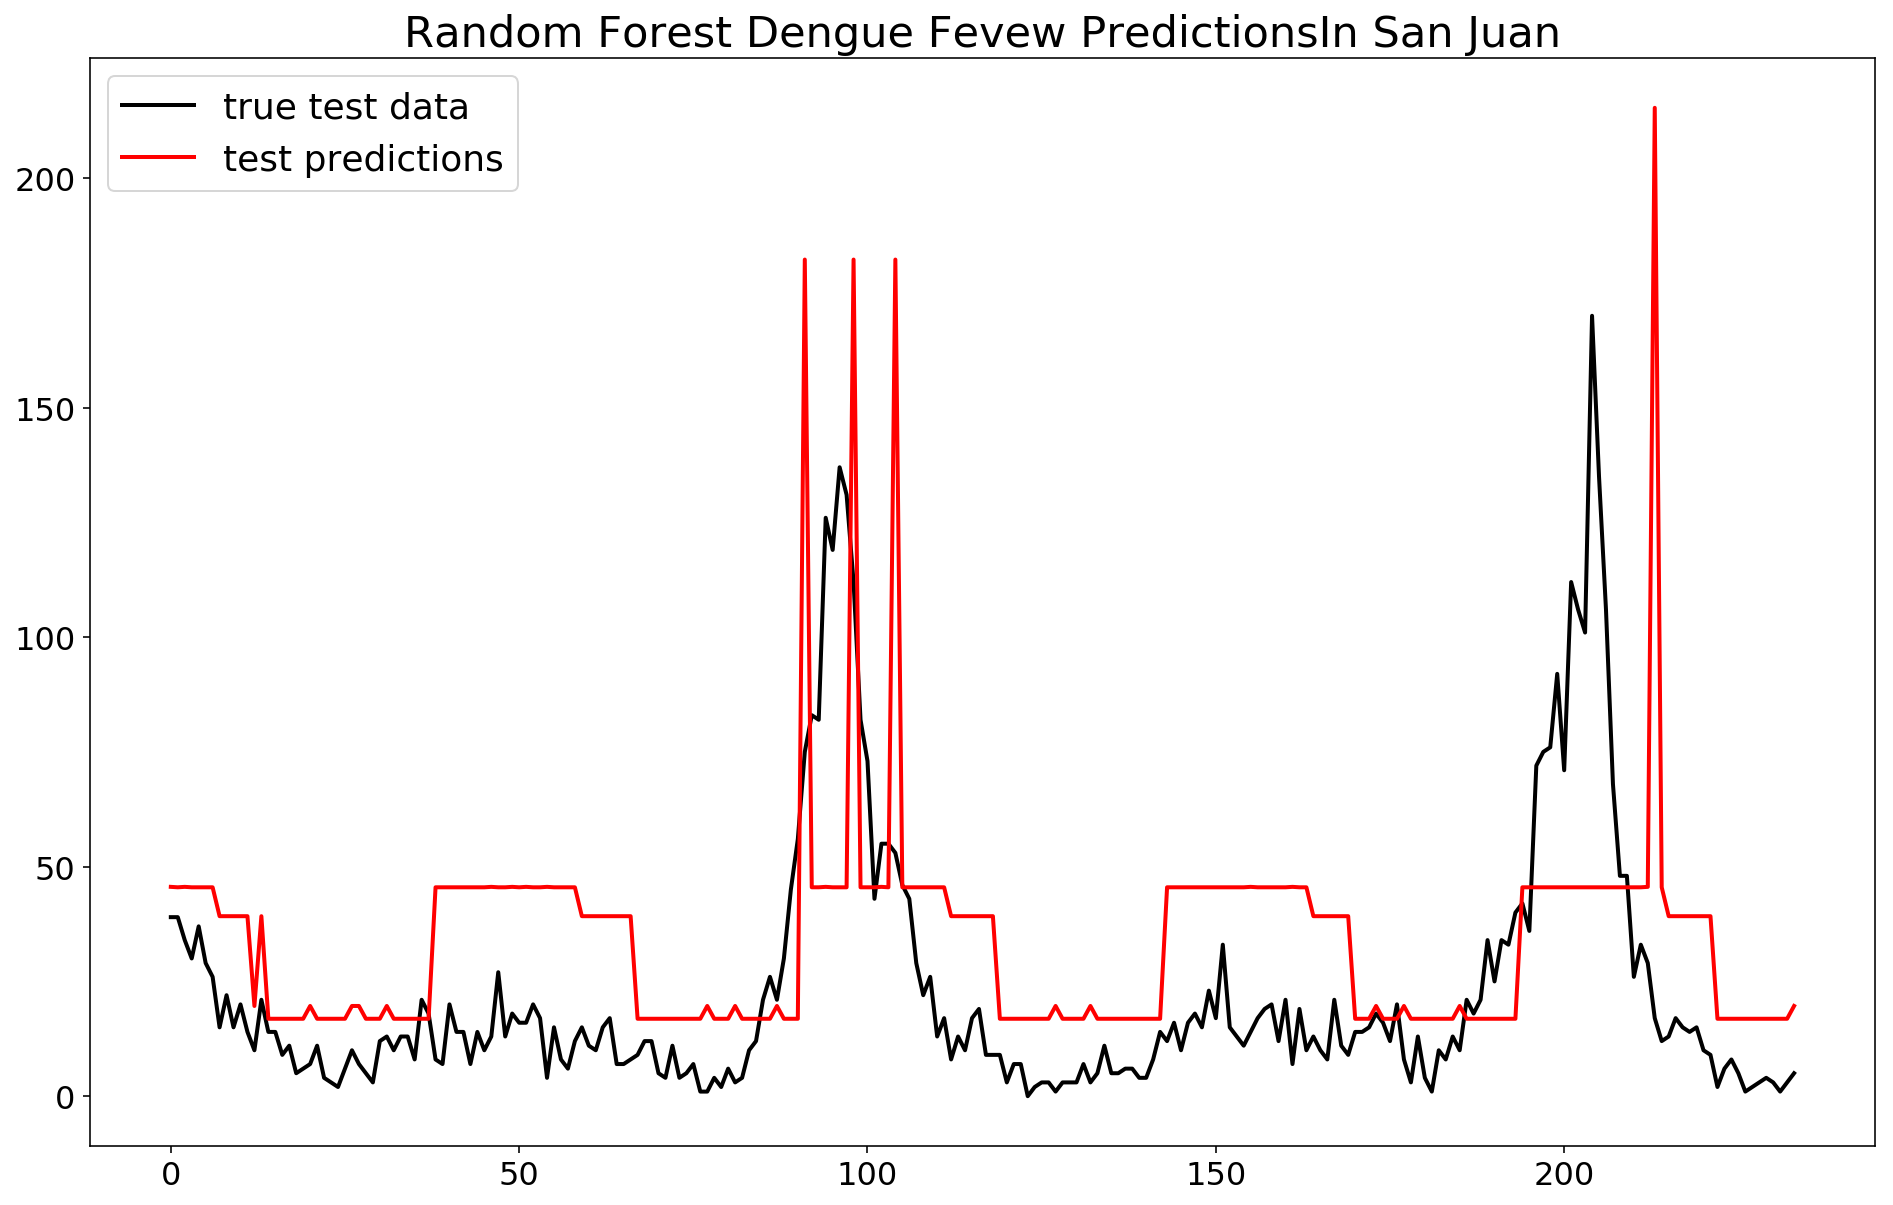

In [59]:
# Plot parameters: experiment with different values
params = {
   'axes.labelsize': 18,# Set to size 8 to start with
   'font.size': 18,# Set to size 8 to start with
   'font.family': 'sans-serif', # Not given initially - only optional
   'font.serif': 'Arial', # Not given initially - only optional
   'legend.fontsize': 18,# Set to size 8 to start with
   'xtick.labelsize': 16,# Set to size 8 to start with
   'ytick.labelsize': 16, # Set to size 8 to start with
   'figure.figsize': [16, 10] # Set to [6,4] to start with 
} 
plt.rcParams.update(params)
plt.plot(np.arange(0,len(Y_test_sj),1),Y_test_sj, color='k',label='true test data', linewidth=2)
plt.plot(np.arange(0,len(Y_test_sj),1), Y_pred_rf_sj, color='r',label='test predictions', linewidth=2)
plt.legend(loc='best')
plt.title('Random Forest Dengue Fevew PredictionsIn San Juan')
#plt.savefig("Random_forest_cyclic_encoding_variability_semi_seaonal_regionalAv.png")
plt.show()

### Random Forest Predictions for Iquitos

In [77]:
%%time
regr_rf_iq = GridSearchCV(RandomForestRegressor(),parameters_RF,cv=cv_obj,n_jobs=-1,refit=True)

regr_rf_iq.fit(X_train_iq,Y_train_iq)

Y_pred_rf_iq = regr_rf_iq.best_estimator_.predict(X_test_iq)

# Do we overfit in comparison to the test data?
Y_pred_train_rf_iq = regr_rf_iq.best_estimator_.predict(X_train_iq)

print("Best number of Estimators: {}".format(regr_rf_iq.best_estimator_.n_estimators))
print("Best Max Dept: {}".format(regr_rf_iq.best_estimator_.max_depth))
print("Best Min Samples Split: {}".format(regr_rf_iq.best_estimator_.min_samples_split))
print("Best Min Samples Leaf: {}".format(regr_rf_iq.best_estimator_.min_samples_leaf))

results_random_forest = pd.DataFrame(regr_rf_iq.cv_results_)
print('Iquitos Test:')
print('Correlation coefficient: {}'.format(np.corrcoef(Y_test_iq,Y_pred_rf_iq)[0,1]))
print('Mean Square Error: {}'.format(mean_squared_error(Y_test_iq,Y_pred_rf_iq)))
print('Mean Absolute Error: {}'.format(mean_absolute_error(Y_test_iq,Y_pred_rf_iq)))

print("Iquitos Train:")
print('Correlation coefficient train: {}'.format(np.corrcoef(Y_train_iq, Y_pred_train_rf_iq)[0,1]))
print('Mean Absolute Error: {}'.format(mean_absolute_error(Y_pred_train_rf_iq,Y_train_iq)))
feature_importances_iq = pd.DataFrame(regr_rf_iq.best_estimator_.feature_importances_, index = (X_iq.columns), columns=['importance']).sort_values('importance', ascending=False)

Best number of Estimators: 10000
Best Max Dept: 1
Best Min Samples Split: 2
Best Min Samples Leaf: 2
Iquitos Test:
Correlation coefficient: 0.08899210904097518
Mean Square Error: 168.24035392515313
Mean Absolute Error: 7.99564036345413
Iquitos Train:
Correlation coefficient train: 0.30853941561468695
Mean Absolute Error: 5.392426310122193
Wall time: 5min 1s


In [79]:
feature_importances_iq.head(10)

importance
reanalysis_specific_humidity_g_per_kg         1.0
ndvi_ne                                       0.0
ndvi_nw                                       0.0
sin_weekofyear                                0.0
station_precip_mm                             0.0
station_min_temp_c                            0.0
station_max_temp_c                            0.0
station_diur_temp_rng_c                       0.0
station_avg_temp_c                            0.0
reanalysis_tdtr_k                             0.0

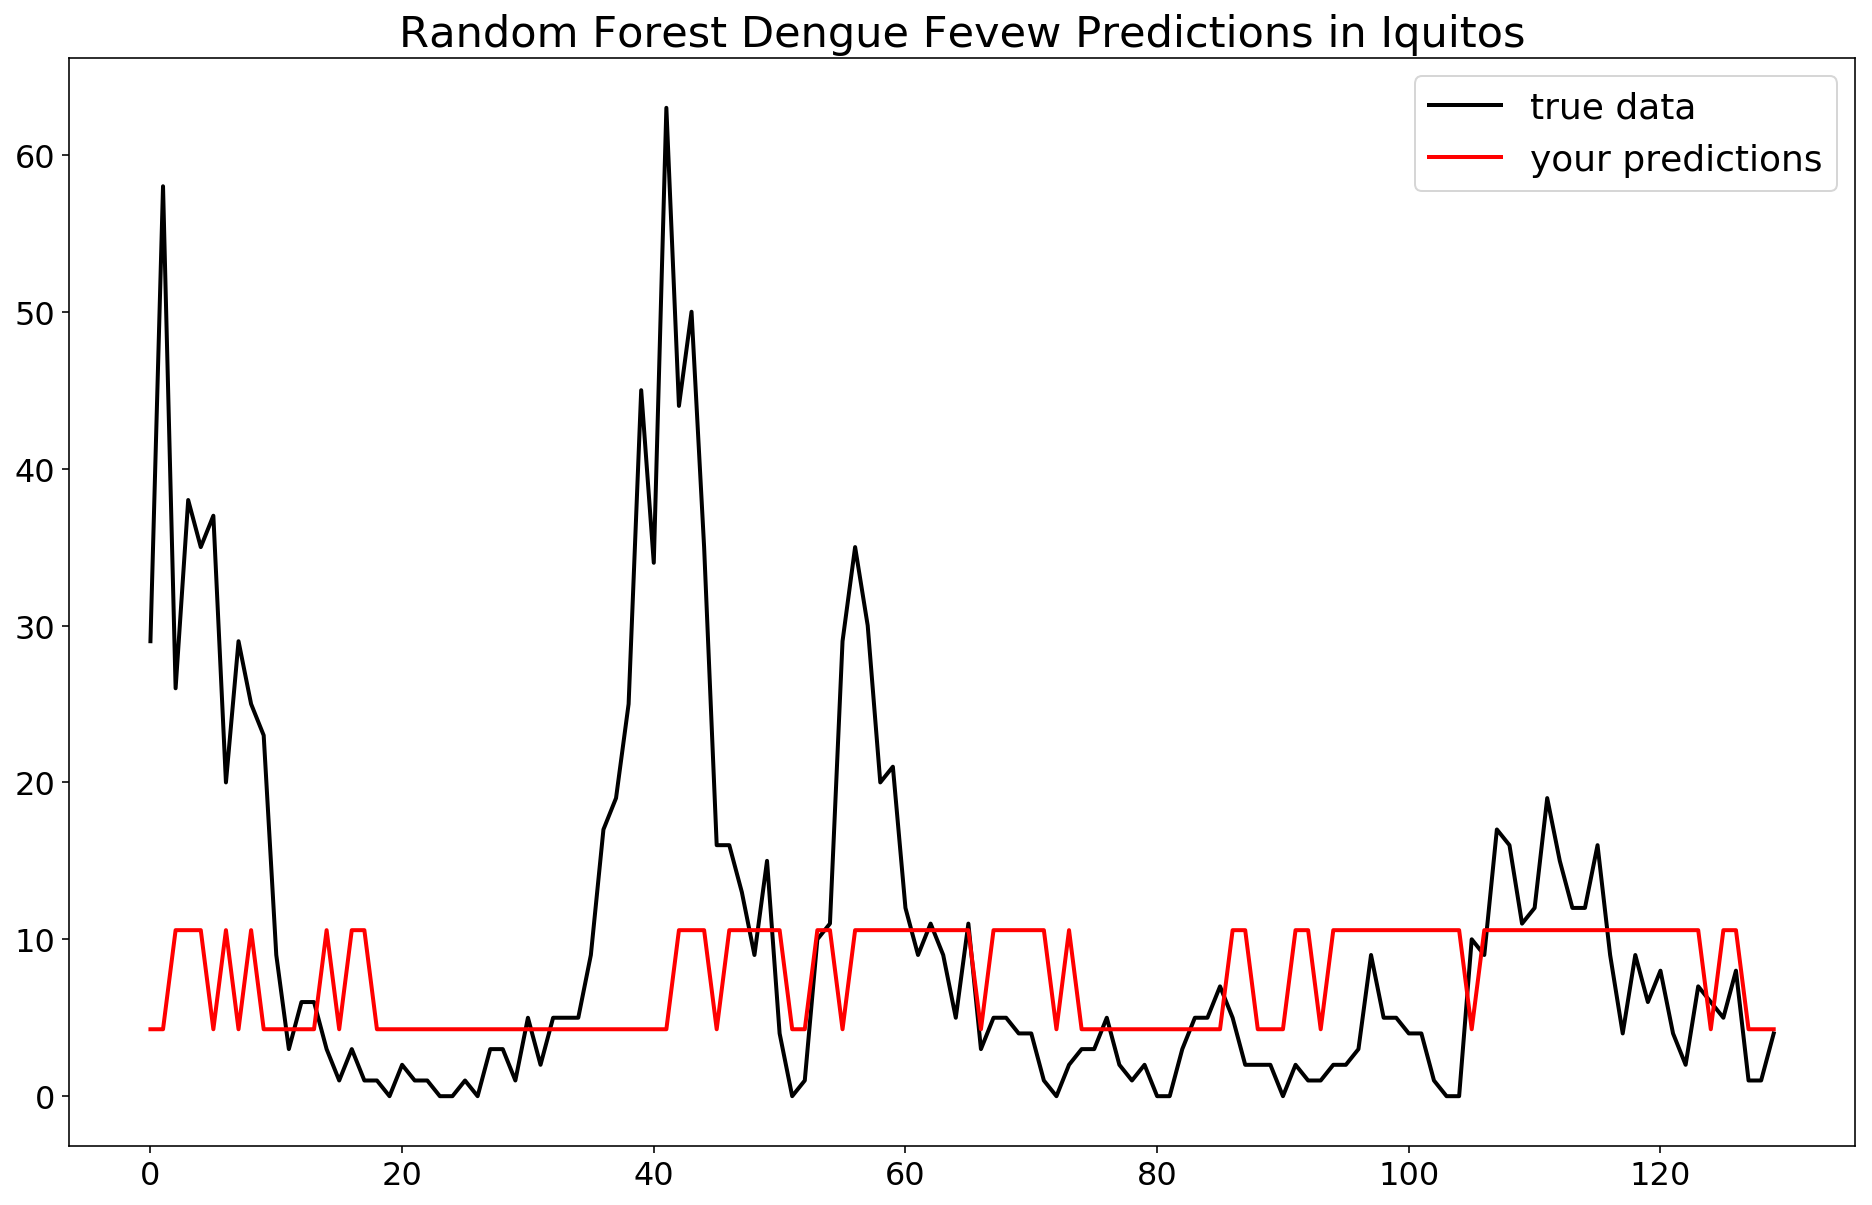

In [78]:
# Plot parameters: experiment with different values
params = {
   'axes.labelsize': 18,# Set to size 8 to start with
   'font.size': 18,# Set to size 8 to start with
    
   'font.family': 'sans-serif', # Not given initially - only optional
   'font.serif': 'Arial', # Not given initially - only optional
   'legend.fontsize': 18,# Set to size 8 to start with
   'xtick.labelsize': 16,# Set to size 8 to start with
   'ytick.labelsize': 16, # Set to size 8 to start with
   'figure.figsize': [16, 10] # Set to [6,4] to start with 
} 
plt.rcParams.update(params)
plt.plot(np.arange(0,len(Y_test_iq),1),Y_test_iq, color='k',label='true data', linewidth=2)
plt.plot(np.arange(0,len(Y_test_iq),1), Y_pred_rf_iq, color='r',label='your predictions', linewidth=2)
plt.legend(loc='best')
plt.title('Random Forest Dengue Fevew Predictions in Iquitos')
#plt.savefig("Random_forest_cyclic_encoding_variability_semi_seaonal_regionalAv.png")
plt.show()

We can see that Random Forest picks up on the correlations between the total number of cases and the temperature and humidity in San Juan and and the correlation between total cases and humidity in Iquitos. The model also clearly sees the seasonal trend. It is also seen from the graphs that Random forest prediction are rather smooth, at least smoother than the actual data. The model picks up on the peaks for the outbreaks in San Juan (but not in Iquitos), but sometimes it lags behind the the actual peaks, which is expected since it takes about a week for a mosquitos to go from an egg to a fully-grown mosquito. The total MAE score for this models predictions on the submission data set was : 29.6. Which was worse than for Ridge regression, mostly due to it smoother nature of prediction.

# Predicting Dengue with Negative Binomial Regression Model

Looking at the similar type of problem, ie predicting the number of cyclists on the Brooklyn Bridge, we decided to try a Negative Binomial Regression model to the data. It tries to predict the count based values with the assumption that variance can be modeled as a power law deviation from the mean, thus saying that the variance can be so much larger than the mea, which is certainly true for out problem during an outbreak.

The Negative Binomial defines the variance, $\sigma^2$ in terms of the mean, $\mu$ and a $\alpha$ parameter:
$$\sigma^2 = \mu + \alpha*\mu^p$$
where $p$ value is fitted by the algorithm and $\alpha$ parameter is the one we need to initially set ourselves. The Negative Binomial model is defined by the `statsmodels.genmod.families.family` and the $\alpha$ is defaulted to 1, but this is not the correct value for every dataset. 

The calculation of $\alpha$ can be done via the *auxiliary Ordinary Least Squares(OLS) regression without a constant* method proposed by the Cameron and Triverdi 2013 in their book, *Regression Analysis of Count Data*. It uses the least squares approach to finding the regression constants, (i.e. $m$ and $c$ in $y = mx + c$). This method estimates $\alpha$ as follows:
$$\frac{(y_i-\lambda_i)^2 - y_i}{\lambda_i} = \alpha \times \lambda_i + 0 $$
where the intercent constant is set to zero, $y_i$ is the $i^{\textrm{th}}$ outcome and $\lambda_i$ is the $i^{\textrm{th}}$ rate. To find $\lambda_i$ a Poisson regression model can be fit to our data set, this will give us a complete rate vector $\mathbf{\lambda} = [\lambda_1, \lambda_2, \lambda_3, ..., \lambda_n]$, $n$ being the number of observations in teh data set.


## San Juan Predictions 

In [103]:
X_sj_transformed = pd.DataFrame(sc_sj.fit_transform(X_sj.iloc[:,:-non_transformed_features]),columns=X_sj.columns[:-non_transformed_features]).join(X_sj.iloc[:,-non_transformed_features:])

X_sj_transformed['total_cases'] = Y_sj

sj_submittion = pd.DataFrame(sc_sj.transform(sj_test.iloc[:,:-non_transformed_features]),columns=X_sj.columns[:-non_transformed_features]).join(sj_test.iloc[:,-non_transformed_features:])

In [82]:
# setting up regression expression in pastry notation 
expr = """ total_cases ~ 1 + reanalysis_specific_humidity_g_per_kg + reanalysis_dew_point_temp_k + 
            station_min_temp_c + station_avg_temp_c + sin_weekofyear + 
            cos_weekofyear"""
#define time shift
fitted_columns = training_columns#['sin_month', 'cos_month', 'sin_weekofyear', 'reanalysis_dew_point_temp_k',
                  #'cos_weekofyear', 'reanalysis_specific_humidity_g_per_kg', 'station_max_temp_c']

# splitting into train and test
#sj_train_df = sj.iloc[0:697,:] 
#sj_test_df = sj.iloc[697:,:]

sj_train_df=X_sj_transformed.iloc[:697,:]
sj_test_df= X_sj_transformed.iloc[697:,:]

#fitting the Poisson 
y_train_nb2, x_train_nb2 = dmatrices(expr, sj_train_df, return_type='dataframe')
y_test_nb2, x_test_nb2 = dmatrices(expr, sj_test_df, return_type='dataframe')

In [83]:
poissn_training_results = sm.GLM(y_train_nb2,x_train_nb2, family = sm.families.Poisson()).fit()
#print("Fitting summary:" , poissn_training_results.summary())
#print ("Fitted rates:", poissn_training_results.mu)
sj_train_df['lambda_rate'] = poissn_training_results.mu

sj_train_df['aux_ols_dep'] = (((sj_train_df['total_cases'] - sj_train_df['lambda_rate'])**2 
                               - sj_train_df['total_cases'])/sj_train_df['lambda_rate'])

ols_expr = """ aux_ols_dep ~ lambda_rate - 1 """
aux_olsr_results = smf.ols(ols_expr, sj_train_df).fit()
print("Alpha Parameter:", aux_olsr_results.params[0])

#aux_olsr_results.tvalues

#training_results_nb2 = sm.GLM(y_train_nb2, x_train_nb2, family = sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()
training_results_nb2 = sm.GLM(y_train_nb2, x_train_nb2, family = sm.families.NegativeBinomial(alpha=1e-8)).fit()

#Y_pred_nb2 = regr_nb2.best_estimator_.predict(X_test)
pred_nb2 = training_results_nb2.get_prediction(x_test_nb2)

#predicting on training dataset
pred_train_nb2 = training_results_nb2.get_prediction(x_train_nb2)
y_ppred_train_nb2 = (pred_train_nb2.summary_frame())['mean']
prediction_summary_frame = pred_nb2.summary_frame()

#print( prediction_summary_frame)


#print('Correlation coefficient: {}'.format(np.corrcoef(Y_test,Y_pred_nb2)[0,1]))
#print('Mean Square Error: {}'.format(mean_squared_error(Y_test,Y_pred_nb2)))
#print('Mean Absolute Error: {}'.format(mean_absolute_error(Y_test,Y_pred_nb2)))

y_pred_nb2 = prediction_summary_frame['mean']
print('Mean Absolute Error: {}'.format(mean_absolute_error(sj_test_df['total_cases'],y_pred_nb2)))
print('Correlation coefficient: {}'.format(np.corrcoef(sj_test_df['total_cases'],y_pred_nb2)[0,1]))

Alpha Parameter: 1.2325915047024187
Mean Absolute Error: 23.03882203832344
Correlation coefficient: 0.4365108867185384


C:\Users\19ver\Anaconda2\envs\Py35\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\19ver\Anaconda2\envs\Py35\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


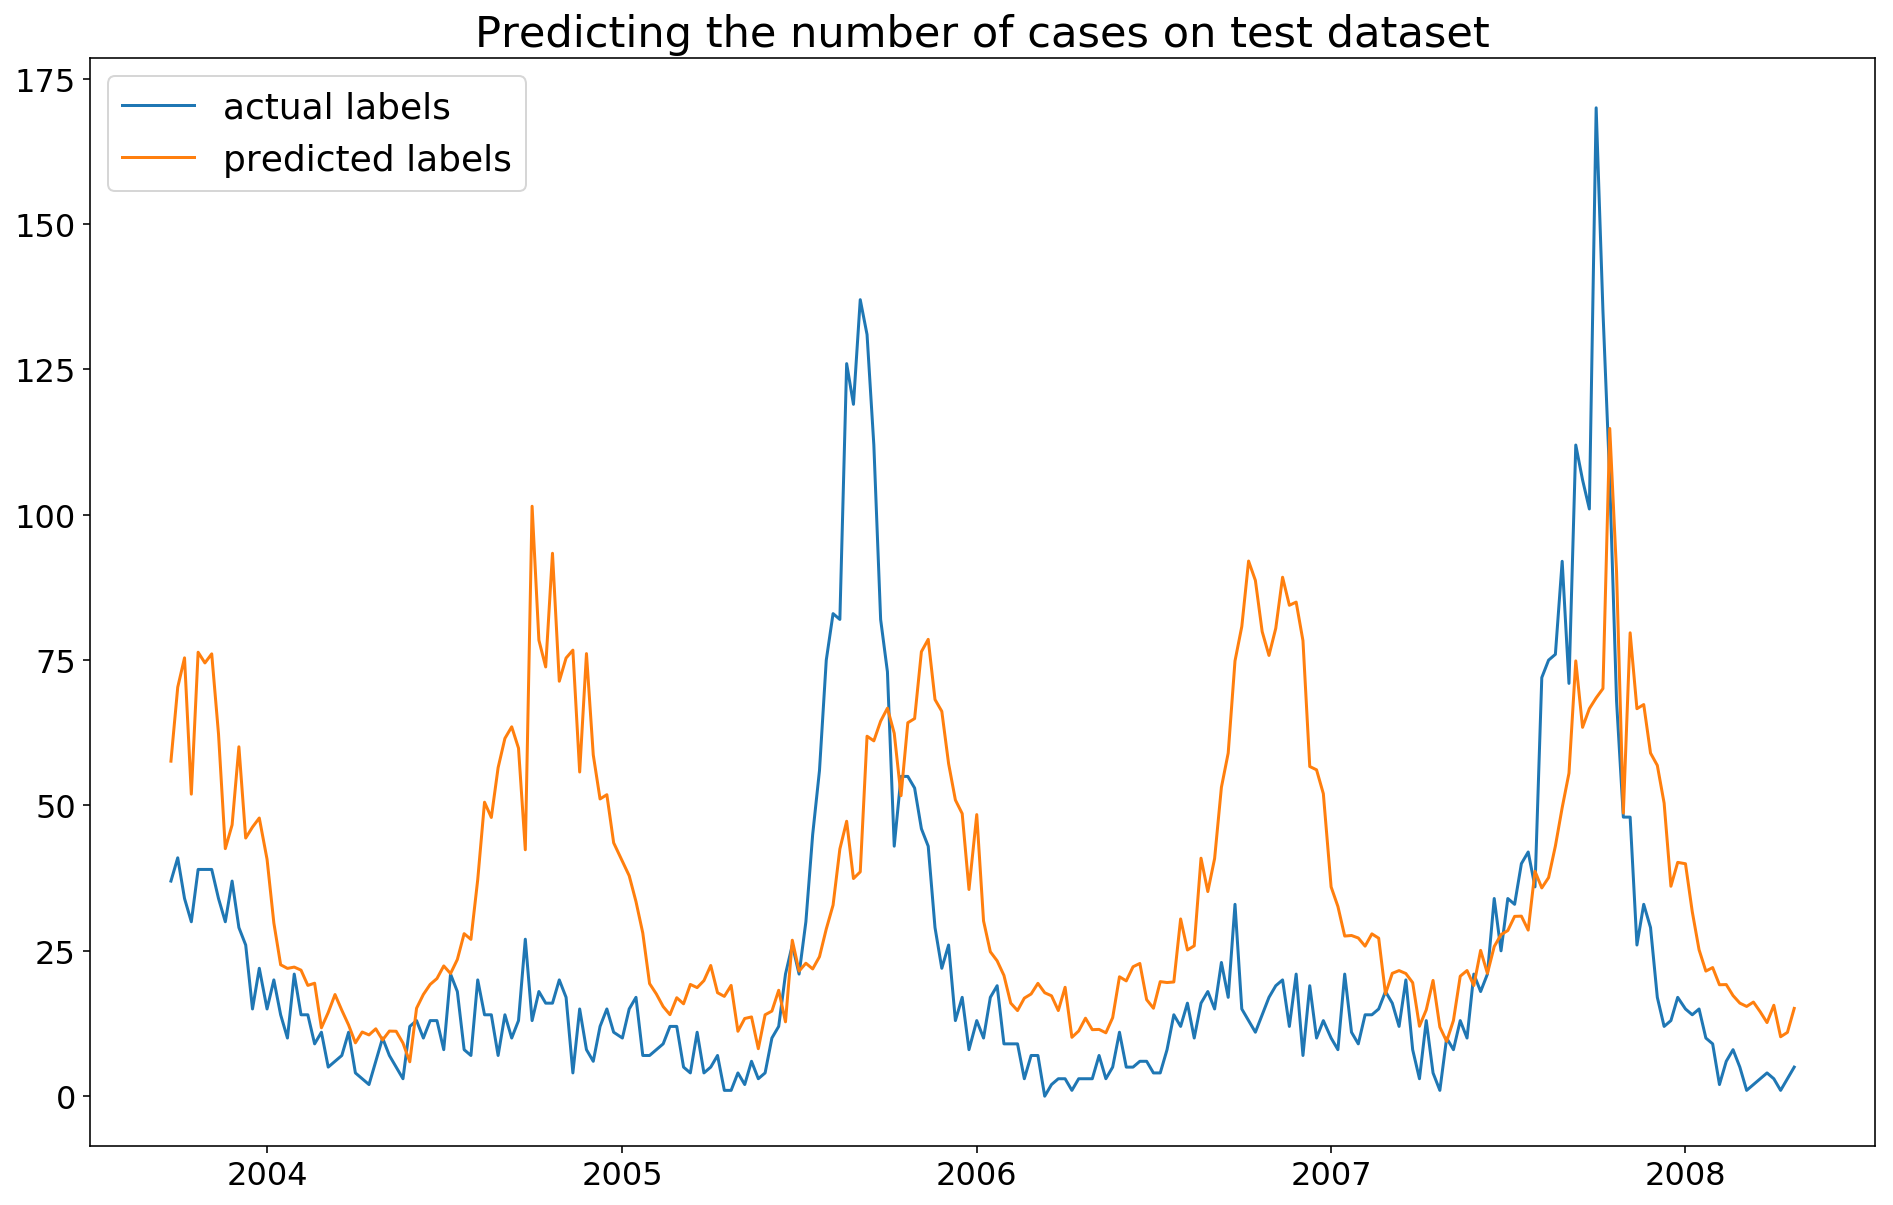

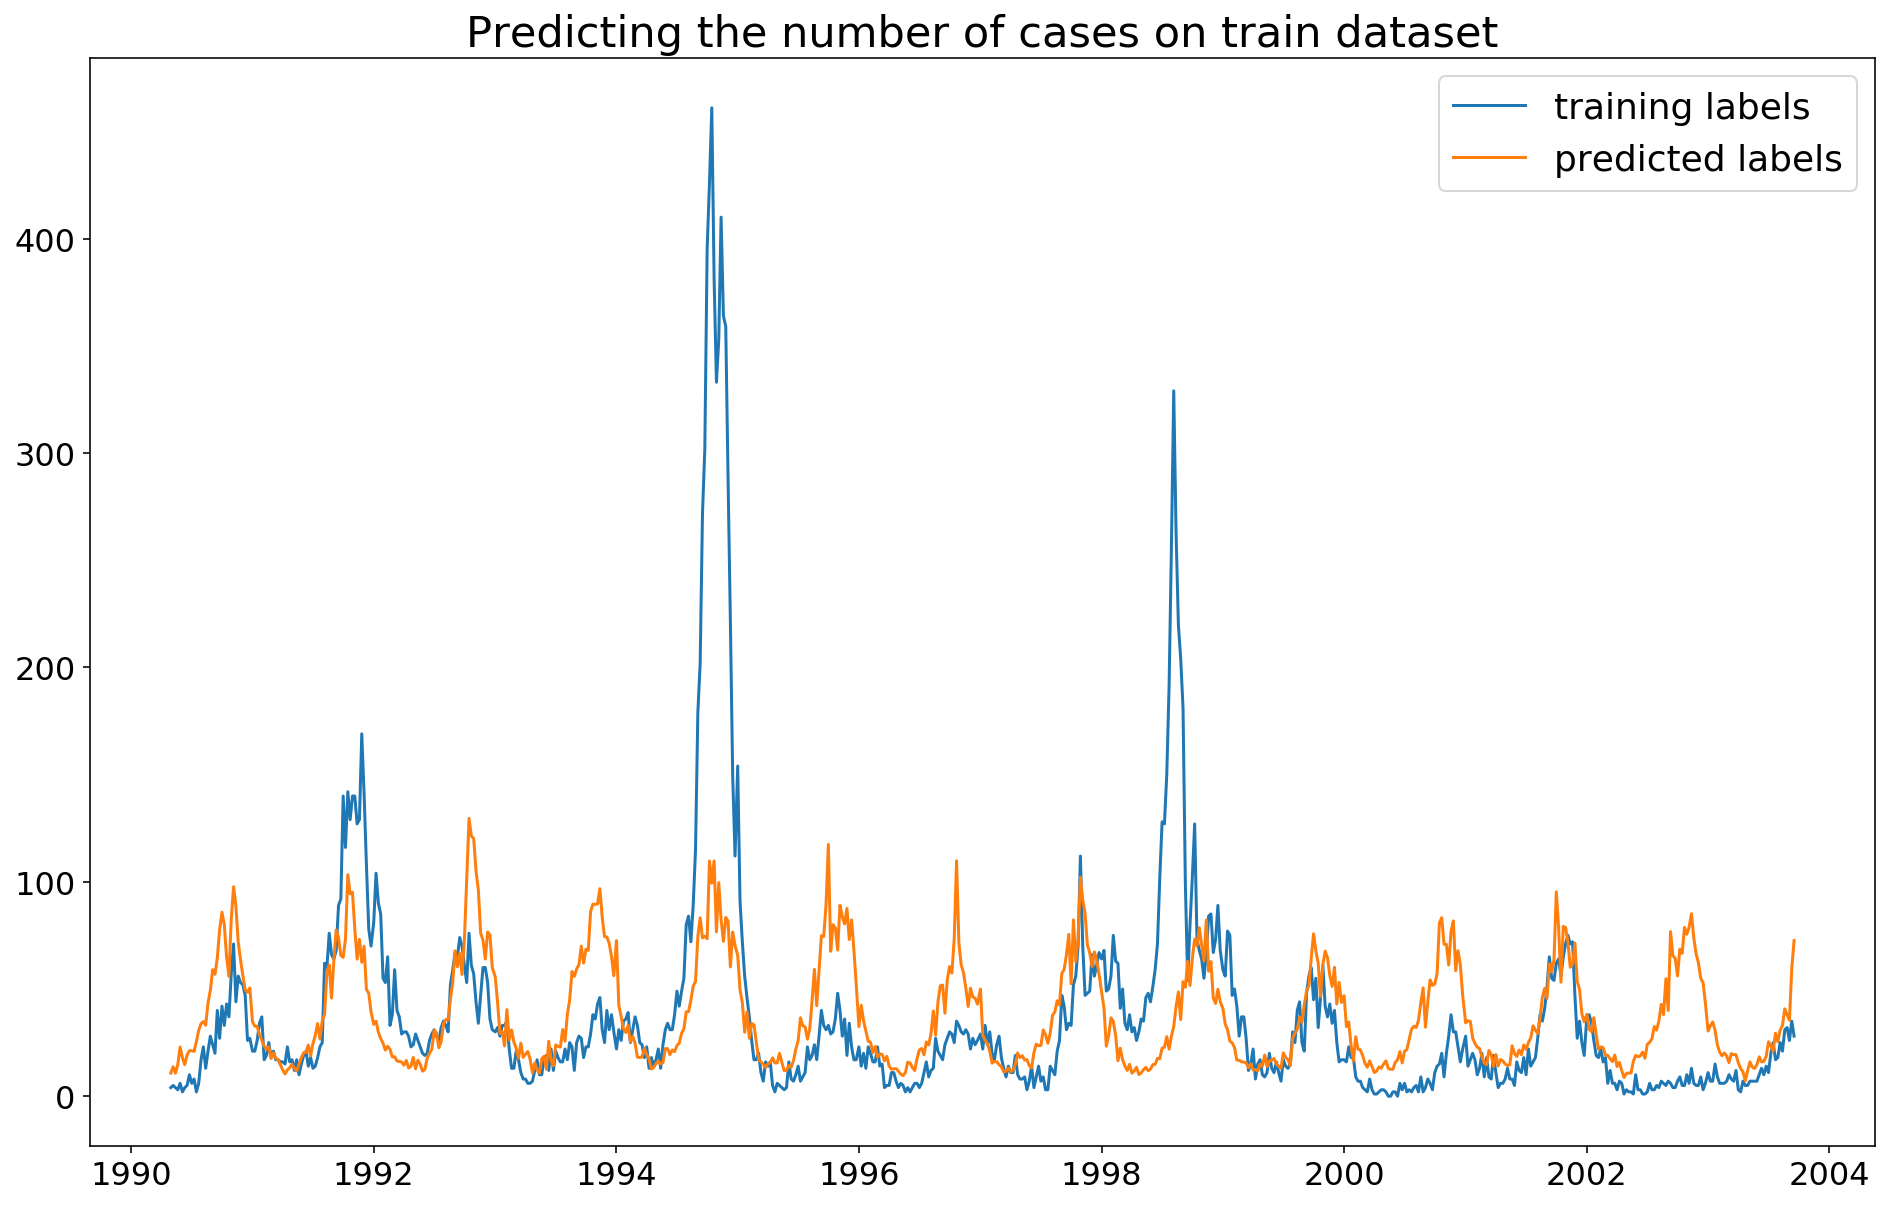

In [85]:
# Plot parameters: experiment with different values
params = {
   'axes.labelsize': 18,# Set to size 8 to start with
   'font.size': 18,# Set to size 8 to start with
   'font.family': 'sans-serif', # Not given initially - only optional
   'font.serif': 'Arial', # Not given initially - only optional
   'legend.fontsize': 18,# Set to size 8 to start with
   'xtick.labelsize': 16,# Set to size 8 to start with
   'ytick.labelsize': 16, # Set to size 8 to start with
   'figure.figsize': [16, 10] # Set to [6,4] to start with 
} 
plt.rcParams.update(params)

plt.title("Predicting the number of cases on test dataset")
plt.plot(sj_training_set['week_start_date'][697:], sj_test_df['total_cases'], label='actual labels')
plt.plot(sj_training_set['week_start_date'][697:], y_pred_nb2, label='predicted labels')
plt.legend(loc='best')
plt.show()

plt.title("Predicting the number of cases on train dataset")
plt.plot(sj_training_set['week_start_date'][:697], sj_train_df['total_cases'], label='training labels')
plt.plot(sj_training_set['week_start_date'][:697], y_ppred_train_nb2, label='predicted labels')
plt.legend(loc='best')
plt.show()


In [105]:
sj_submittion['total_cases'] = 0
sj_test_y, sj_sub_test_x = dmatrices(expr, sj_submittion, return_type='dataframe')
submittion_resutls_sj = training_results_nb2.get_prediction(sj_sub_test_x)
pred_sum_frame_sub_sj = submittion_resutls_sj.summary_frame()
sub_sj_pred = pred_sum_frame_sub_sj['mean']

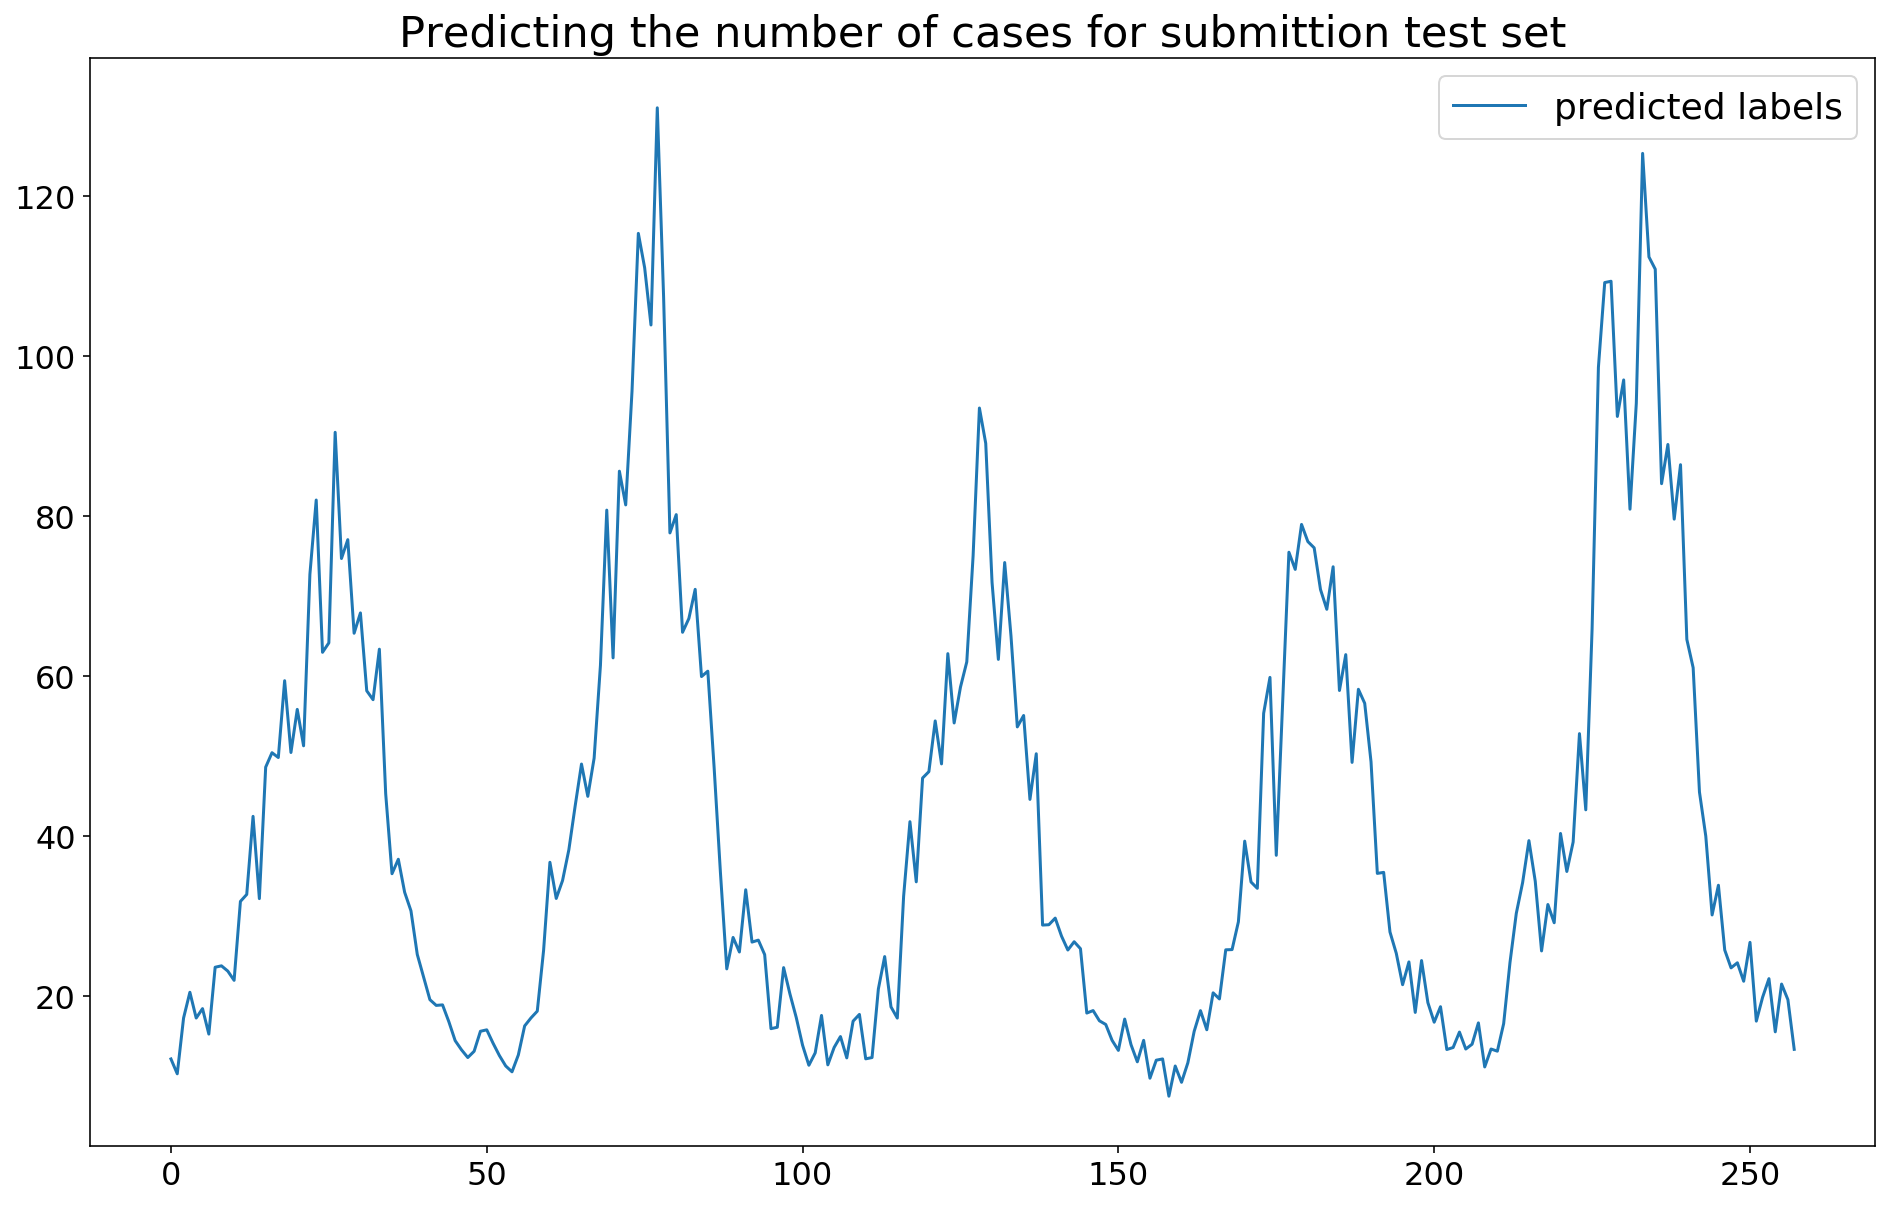

In [109]:
plt.title("Predicting the number of cases for submittion test set")
#plt.plot(sj_training_set['week_start_date'][:697], sj_train_df['total_cases'], label='training labels')
plt.plot(np.arange(len(sj_test_features))[:len(sub_sj_pred)], sub_sj_pred, label='predicted labels')
plt.legend(loc='best')
plt.show()

## Iquitos predictions

In [118]:
X_iq_transformed = pd.DataFrame(sc_iq.fit_transform(X_iq.iloc[:,:-non_transformed_features]),columns=X_iq.columns[:-non_transformed_features])
X_iq_transformed['sin_weekofyear'] = np.array(X_iq.iloc[:,-2])
X_iq_transformed['cos_weekofyear'] = np.array(X_iq.iloc[:,-1])
X_iq_transformed['total_cases'] = np.array(Y_iq)

iq_submittion = pd.DataFrame(sc_iq.transform(iq_test.iloc[:,:-non_transformed_features]),columns=X_iq.columns[:-non_transformed_features])
iq_submittion['sin_weekofyear'] = np.array(iq_test.iloc[:,-2])
iq_submittion['cos_weekofyear'] = np.array(iq_test.iloc[:,-1])

In [126]:
# setting up regression expression in pastry notation 
expr_iq = """ total_cases ~ 1 + reanalysis_specific_humidity_g_per_kg + reanalysis_dew_point_temp_k + 
            station_min_temp_c + station_avg_temp_c + sin_weekofyear + 
            cos_weekofyear"""
fitted_columns = training_columns#['sin_month', 'cos_month', 'sin_weekofyear', 'reanalysis_dew_point_temp_k',
                  #'cos_weekofyear', 'reanalysis_specific_humidity_g_per_kg', 'station_max_temp_c']

# splitting into train and test
#sj_train_df = sj.iloc[0:697,:] 
#sj_test_df = sj.iloc[697:,:]

iq_train_df=X_iq_transformed.iloc[:380,:]
iq_test_df= X_iq_transformed.iloc[380:,:]

#fitting the Poisson 
y_train_nb2_iq, x_train_nb2_iq = dmatrices(expr_iq, iq_train_df, return_type='dataframe')
y_test_nb2_iq, x_test_nb2_iq = dmatrices(expr_iq, iq_test_df, return_type='dataframe')

In [127]:
poissn_training_results_iq = sm.GLM(y_train_nb2_iq, x_train_nb2_iq, family = sm.families.Poisson()).fit()
#print("Fitting summary:" , poissn_training_results.summary())
#print ("Fitted rates:", poissn_training_results.mu)
iq_train_df['lambda_rate'] = np.array(poissn_training_results_iq.mu)

iq_train_df['aux_ols_dep'] = (((iq_train_df['total_cases'] - iq_train_df['lambda_rate'])**2 
                               - iq_train_df['total_cases'])/iq_train_df['lambda_rate'])

ols_expr = """ aux_ols_dep ~ lambda_rate - 1 """
aux_olsr_results_iq = smf.ols(ols_expr, iq_train_df).fit()
print("Alpha Parameter:", aux_olsr_results_iq.params[0])

#aux_olsr_results.tvalues

#training_results_nb2_iq = sm.GLM(y_train_nb2_iq, x_train_nb2_iq, family = sm.families.NegativeBinomial(alpha=aux_olsr_results_iq.params[0])).fit()
training_results_nb2_iq = sm.GLM(y_train_nb2_iq, x_train_nb2_iq, family = sm.families.NegativeBinomial(alpha=1e-2)).fit()

#Y_pred_nb2 = regr_nb2.best_estimator_.predict(X_test)
pred_nb2_iq = training_results_nb2_iq.get_prediction(x_test_nb2_iq)

#predicting on training dataset
pred_train_nb2_iq = training_results_nb2_iq.get_prediction(x_train_nb2_iq)
y_ppred_train_nb2_iq = (pred_train_nb2_iq.summary_frame())['mean']
prediction_summary_frame_iq = pred_nb2_iq.summary_frame()

#print( prediction_summary_frame)


#print('Correlation coefficient: {}'.format(np.corrcoef(Y_test,Y_pred_nb2)[0,1]))
#print('Mean Square Error: {}'.format(mean_squared_error(Y_test,Y_pred_nb2)))
#print('Mean Absolute Error: {}'.format(mean_absolute_error(Y_test,Y_pred_nb2)))

y_pred_nb2_iq = prediction_summary_frame_iq['mean']
print('Mean Absolute Error: {}'.format(mean_absolute_error(iq_test_df['total_cases'],y_pred_nb2_iq)))
print('Correlation coefficient: {}'.format(np.corrcoef(iq_test_df['total_cases'],y_pred_nb2_iq)[0,1]))

ValueError: Length of values does not match length of index

In [ ]:
# Plot parameters: experiment with different values
params = {
   'axes.labelsize': 18,# Set to size 8 to start with
   'font.size': 18,# Set to size 8 to start with
   'font.family': 'sans-serif', # Not given initially - only optional
   'font.serif': 'Arial', # Not given initially - only optional
   'legend.fontsize': 18,# Set to size 8 to start with
   'xtick.labelsize': 16,# Set to size 8 to start with
   'ytick.labelsize': 16, # Set to size 8 to start with
   'figure.figsize': [16, 10] # Set to [6,4] to start with 
} 
plt.rcParams.update(params)

plt.title("Predicting the number of cases on test dataset")
plt.plot(iq_training_set['week_start_date'][380:-7], iq_test_df['total_cases'], label='actual labels')
plt.plot(iq_training_set['week_start_date'][380:-7], y_pred_nb2_iq, label='predicted labels')
plt.legend(loc='best')
plt.show()

plt.title("Predicting the number of cases on train dataset")
plt.plot(sj_training_set['week_start_date'][:380], iq_train_df['total_cases'], label='training labels')
plt.plot(sj_training_set['week_start_date'][:380], y_ppred_train_nb2_iq, label='predicted labels')
plt.legend(loc='best')
plt.show()


In [ ]:
iq_test['total_cases'] = 0
iq_test_y, iq_sub_test_x = dmatrices(expr, iq_test, return_type='dataframe')
submittion_resutls_iq = training_results_nb2_iq.get_prediction(iq_sub_test_x)
sub_iq_pred = submittion_resutls_iq.summary_frame()['mean']

In [ ]:
plt.title("Predicting the number of cases for submittion test set")
#plt.plot(sj_training_set['week_start_date'][:697], sj_train_df['total_cases'], label='training labels')
plt.plot(iq_test_features['week_start_date'], sub_iq_pred, label='predicted labels')
plt.legend(loc='best')
plt.show()

## Getting the model predictions on the submittion data set 

In [ ]:
results_format['total_cases'] = np.concatenate((np.array(round(sub_sj_pred)),np.array(round(sub_iq_pred))), axis=None).astype(int)

date_today = datetime.now().strftime("%Y-%m-%d")
counter += 1

results_format.to_csv('Dengue_results_for_submittion ' + date_today + " attempt " + str(counter) , index=False)

# Time-Series Forecasting with ARIMA

https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b 

Total MAE on the submittion set: 25.72

In [182]:
dengue_cases_sj = sj_training_set[['week_start_date','total_cases']]
end_date = dengue_cases_sj['week_start_date'].max()
start_date = dengue_cases_sj['week_start_date'].min()
dengue_cases_sj = dengue_cases_sj.set_index('week_start_date')

y_sj = dengue_cases_sj['total_cases'].resample('1W').mean()
y_all_sj = y_sj[pd.isnull(y_sj) == False]
y_all_sj.index = pd.DatetimeIndex(y_all_sj.index)

y_train = y_all_sj[:702]
y_test = y_all_sj[702:]

#y_given.index = pd.DatetimeIndex(y_given.index).to_period('W')

params = {
   'axes.labelsize': 18,# Set to size 8 to start with
   'font.size': 18,# Set to size 8 to start with
   'font.family': 'sans-serif', # Not given initially - only optional
   'font.serif': 'Arial', # Not given initially - only optional
   'legend.fontsize': 18,# Set to size 8 to start with
   'xtick.labelsize': 16,# Set to size 8 to start with
   'ytick.labelsize': 16, # Set to size 8 to start with
   'figure.figsize': [16, 10] # Set to [6,4] to start with 
} 
plt.rcParams.update(params)

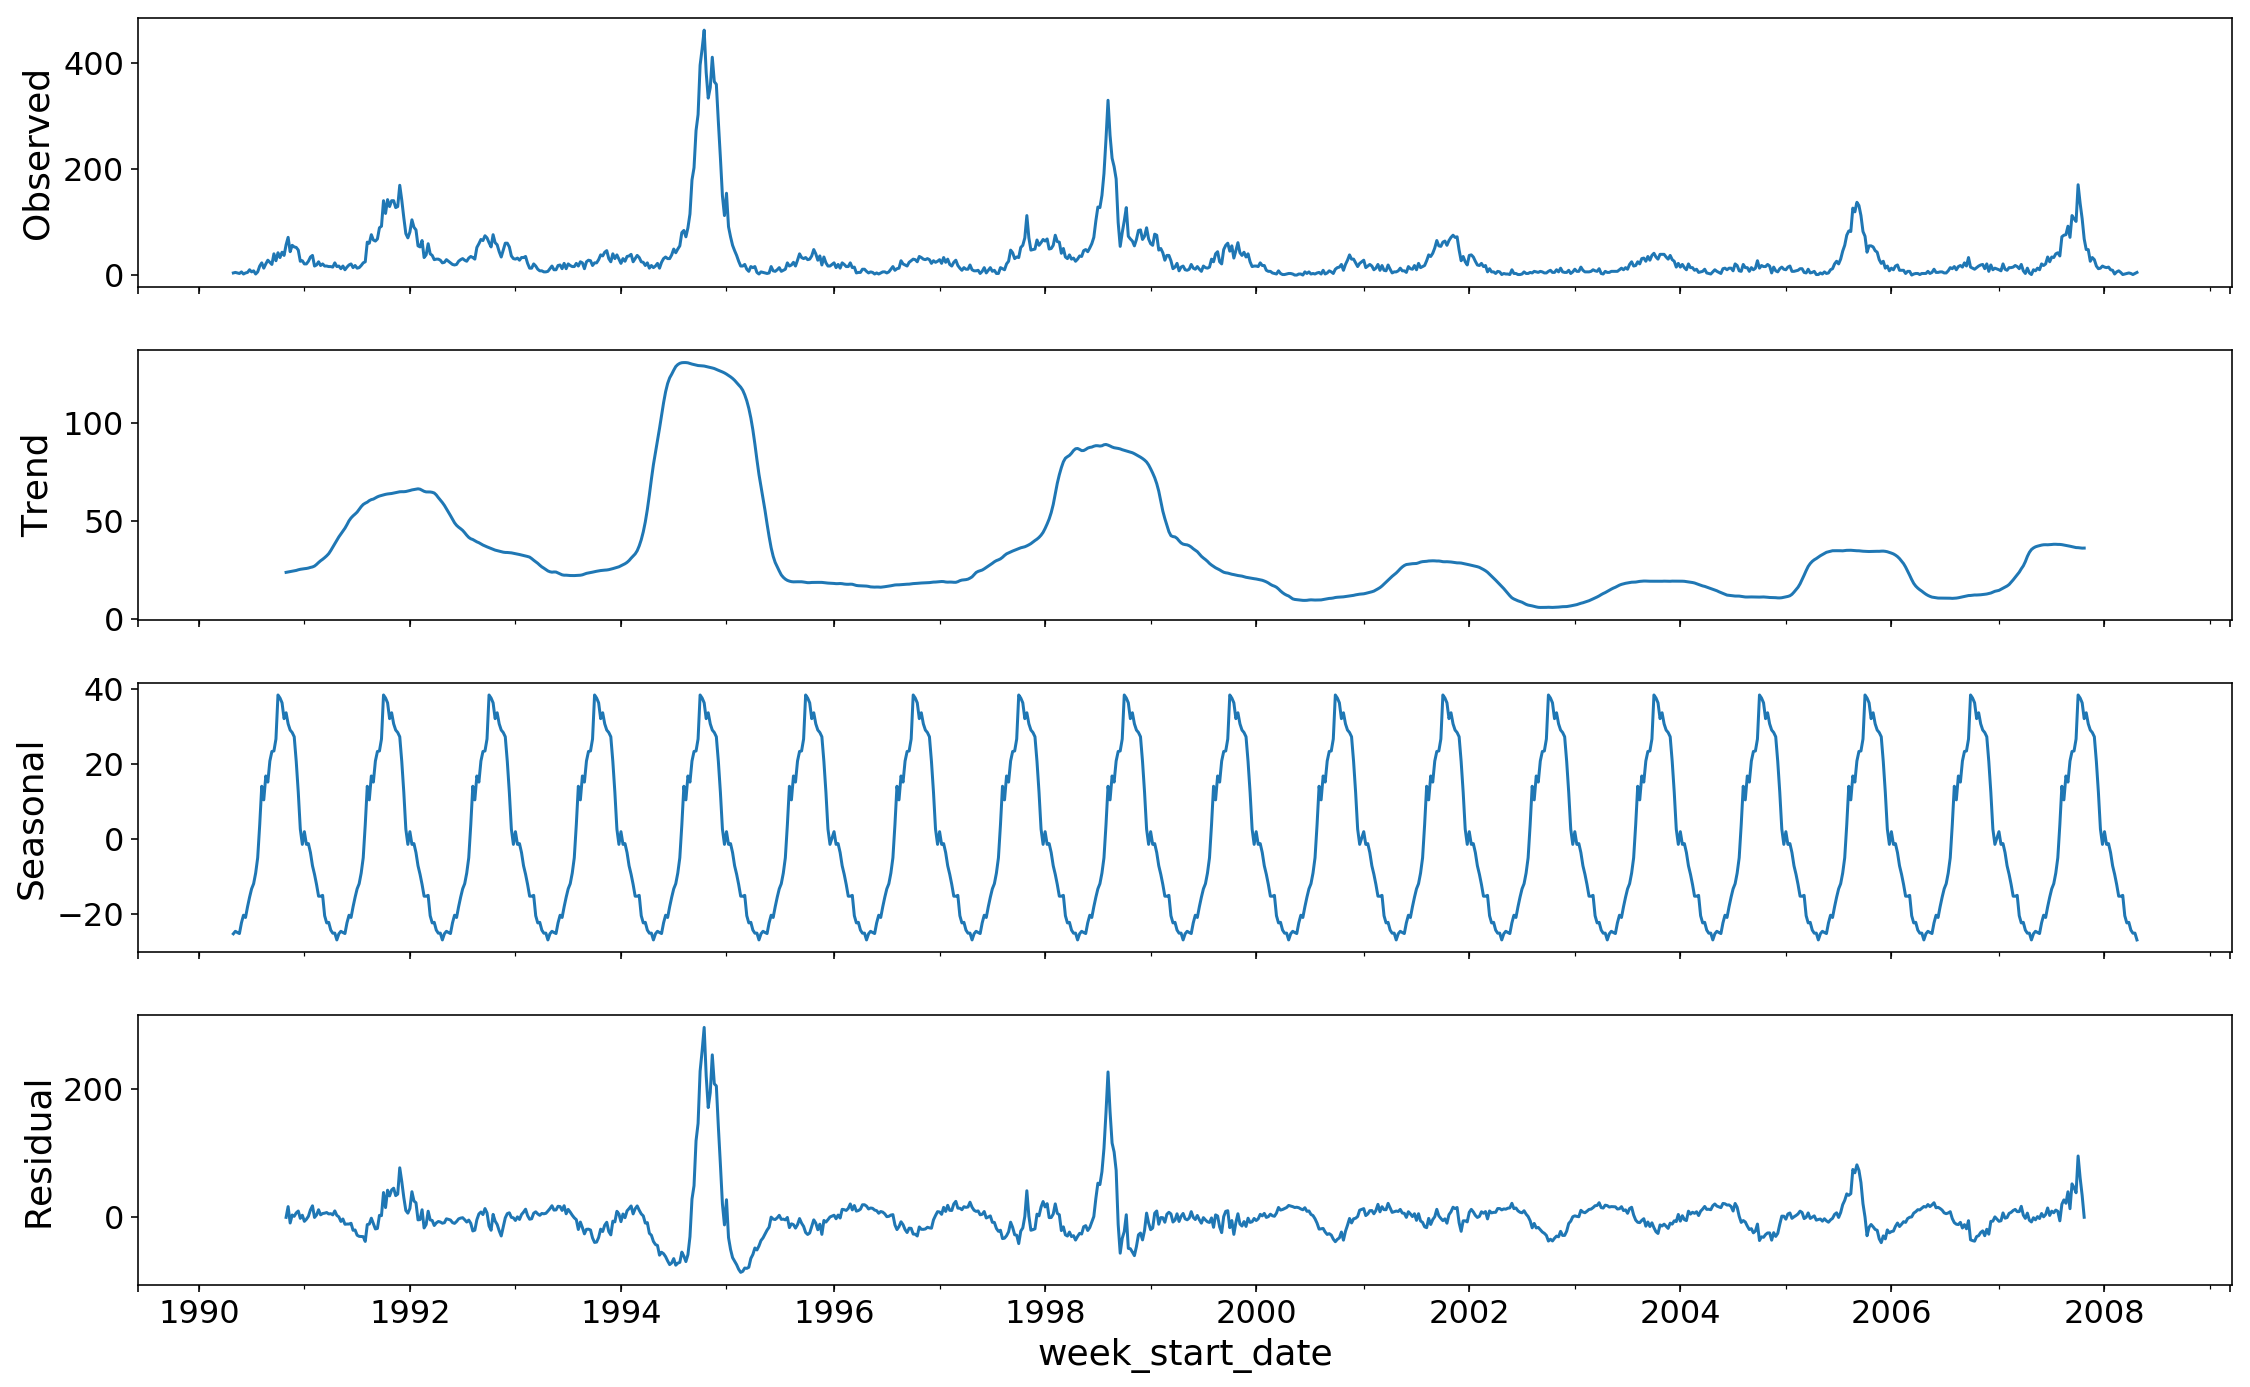

In [86]:
decomposition = sm.tsa.seasonal_decompose(y_given, model='additive', freq=52)
fig = decomposition.plot()
plt.show()

In [ ]:
%%time
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

aic = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        start_time = time.time()

        mod = sm.tsa.statespace.SARIMAX(y_given,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,
                                            enforce_invertibility=False)
        results = mod.fit()
        aic.append(results.aic)
        elapsed_time = time.time() - start_time

        print('ARIMA{}x{}12 - AIC:{}, Time: {}'.format(param, param_seasonal, results.aic, elapsed_time))
    

In [88]:
min(aic)

6773.353606751126

In [183]:
%%time
mod = sm.tsa.statespace.SARIMAX(y_train,
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

pred = results.get_prediction(dynamic=False)
pred_ci = pred.conf_int()

pred_uc = results.get_forecast(steps=234)
pred_ci_2 = pred_uc.conf_int()

C:\Users\19ver\Anaconda2\envs\Py35\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  index_generated = False


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9540      0.006    173.404      0.000       0.943       0.965
ma.L1          0.1720      0.024      7.105      0.000       0.125       0.219
ma.S.L52      -1.0969      0.071    -15.371      0.000      -1.237      -0.957
sigma2       180.7012     16.938     10.668      0.000     147.502     213.900
Wall time: 43.7 s


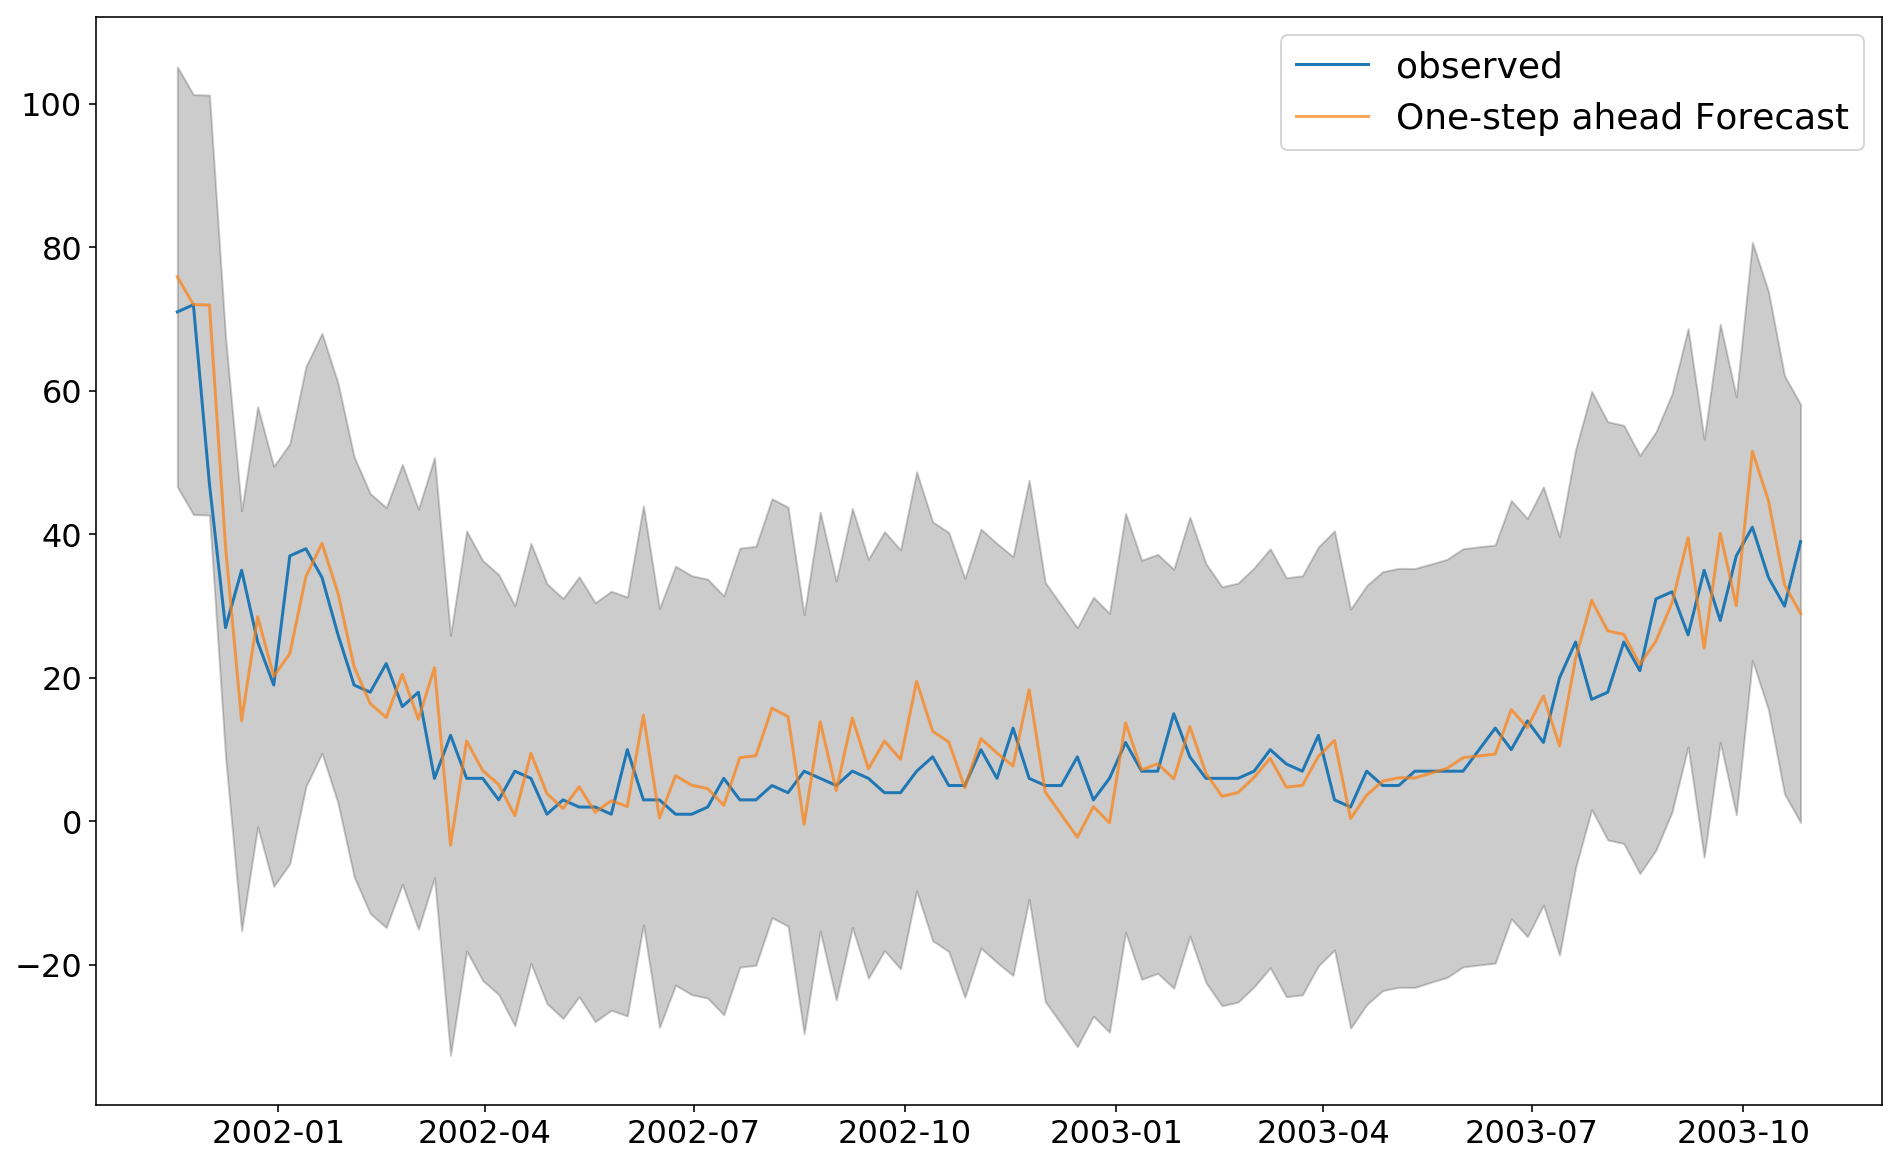

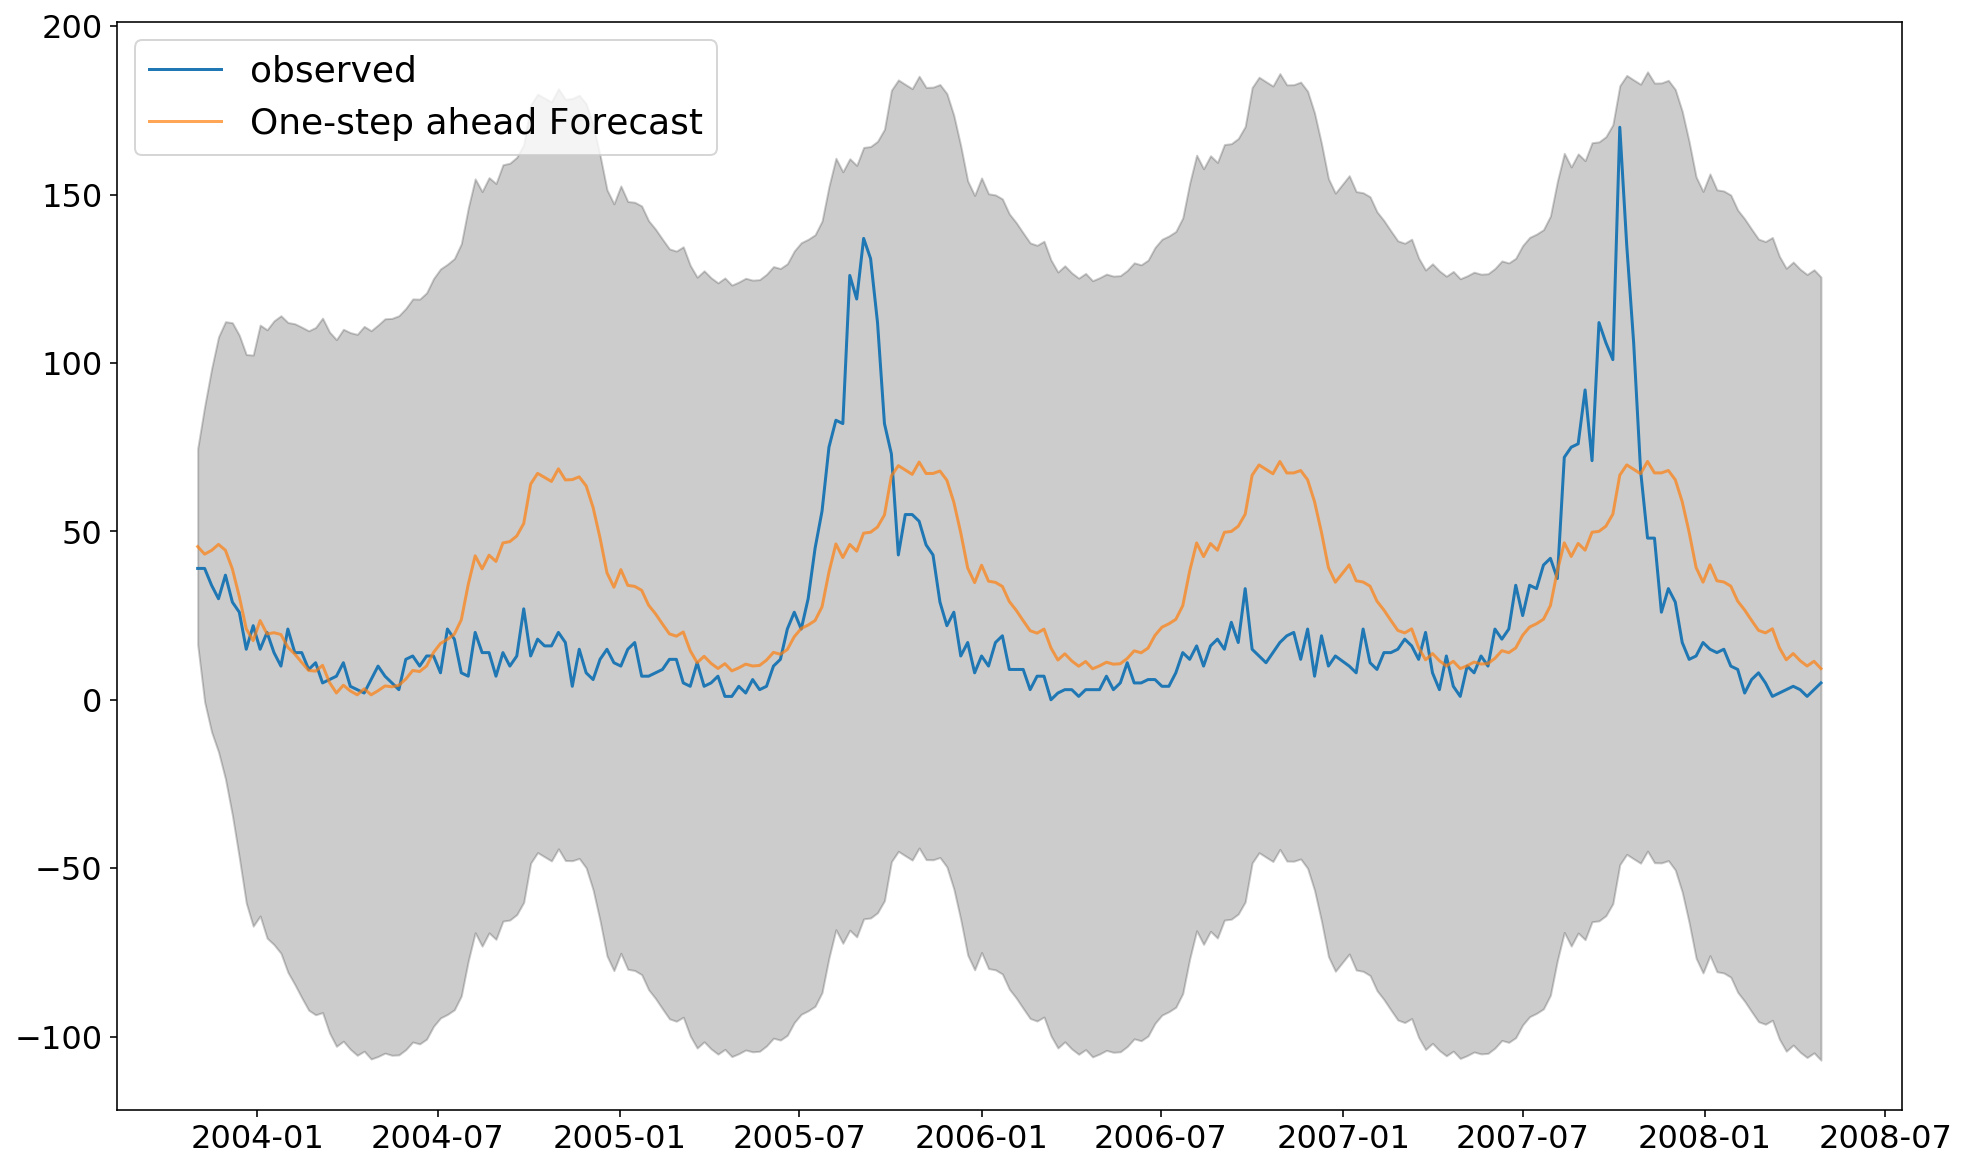

In [222]:
plt.plot(y_train.index[600:],y_train[600:], label='observed')
plt.plot(y_train.index[600:],pred.predicted_mean[600:], label='One-step ahead Forecast', alpha=.7)
plt.fill_between(pred_ci.index[600:],pred_ci.iloc[600:, 0],pred_ci.iloc[600:, 1], color='k', alpha=.2)

ax.set_title("Predicted Train")
ax.set_xlabel('Date')
ax.set_ylabel('Dengue Cases')
plt.legend()
plt.show()

plt.plot(y_test.index[:],y_test[:], label='observed')
plt.plot(y_test.index[:],pred_uc.predicted_mean[:], label='One-step ahead Forecast', alpha=.7)
plt.fill_between(y_test.index[:],pred_ci_2.iloc[:, 0],pred_ci_2.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Dengue Cases')
plt.legend()
plt.show()

In [199]:
mean_absolute_error(np.array(pred_uc.predicted_mean.astype(int)),np.array(y_test))

20.44871794871795

In [225]:
%%time
mod_sj = sm.tsa.statespace.SARIMAX(y_all,
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_sj = mod_sj.fit()
print(results_sj.summary().tables[1])

pred_sj = results_sj.get_prediction(dynamic=False)
pred_ci_sj = pred_sj.conf_int()

pred_uc_sj = results_sj.get_forecast(steps=260)
pred_ci_2_sj = pred_uc_sj.conf_int()

C:\Users\19ver\Anaconda2\envs\Py35\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  index_generated = False


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9527      0.005    211.239      0.000       0.944       0.962
ma.L1          0.1276      0.019      6.688      0.000       0.090       0.165
ma.S.L52      -1.0622      0.044    -23.926      0.000      -1.149      -0.975
sigma2       164.6185      9.068     18.154      0.000     146.846     182.391


C:\Users\19ver\Anaconda2\envs\Py35\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ' location related to the index of the data.')


Wall time: 1min 2s


In [236]:
len(y_all_iq)

520

In [245]:
dengue_cases_iq = iq_training_set[['week_start_date','total_cases']]
end_date_iq = dengue_cases_iq['week_start_date'].max()
start_date_iq = dengue_cases_iq['week_start_date'].min()
dengue_cases_iq = dengue_cases_iq.set_index('week_start_date')

y_iq = dengue_cases_iq['total_cases'].resample('1W').mean()
y_all_iq = y_iq[pd.isnull(y_iq) == False]
y_all_iq.index = pd.DatetimeIndex(y_all_iq.index)

y_train_iq = y_all_iq[:390]
y_test_iq = y_all_iq[390:]

In [231]:
%%time
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

aic = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        start_time = time.time()

        mod = sm.tsa.statespace.SARIMAX(y_all_iq,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,
                                            enforce_invertibility=False)
        results = mod.fit()
        aic.append(results.aic)
        elapsed_time = time.time() - start_time

        print('ARIMA{}x{}12 - AIC:{}, Time: {}'.format(param, param_seasonal, results.aic, elapsed_time))

C:\Users\19ver\Anaconda2\envs\Py35\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


ARIMA(0, 0, 0)x(0, 0, 0, 52)12 - AIC:4150.138575973035, Time: 0.06283164024353027
ARIMA(0, 0, 0)x(0, 0, 1, 52)12 - AIC:3751.7283666525263, Time: 2.1013786792755127
ARIMA(0, 0, 0)x(0, 1, 0, 52)12 - AIC:3898.538509103185, Time: 0.42885255813598633
ARIMA(0, 0, 0)x(0, 1, 1, 52)12 - AIC:3239.6574395875596, Time: 13.764184951782227
ARIMA(0, 0, 0)x(1, 0, 0, 52)12 - AIC:3731.6702854779874, Time: 0.329120397567749
ARIMA(0, 0, 0)x(1, 0, 1, 52)12 - AIC:3634.347087620025, Time: 6.847684383392334
ARIMA(0, 0, 0)x(1, 1, 0, 52)12 - AIC:3302.4539669733895, Time: 1.5538434982299805
ARIMA(0, 0, 0)x(1, 1, 1, 52)12 - AIC:3228.6510685193907, Time: 15.943355321884155
ARIMA(0, 0, 1)x(0, 0, 0, 52)12 - AIC:3800.100950180113, Time: 0.17253875732421875
ARIMA(0, 0, 1)x(0, 0, 1, 52)12 - AIC:3447.748941151269, Time: 3.323111057281494
ARIMA(0, 0, 1)x(0, 1, 0, 52)12 - AIC:3630.234130129076, Time: 1.33443021774292
ARIMA(0, 0, 1)x(0, 1, 1, 52)12 - AIC:3013.0085558680103, Time: 21.208272695541382
ARIMA(0, 0, 1)x(1, 0, 0,

C:\Users\19ver\Anaconda2\envs\Py35\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  return self.hessian(params, *args) / nobs


ARIMA(1, 1, 1)x(1, 1, 0, 52)12 - AIC:2984.071885659209, Time: 81.50500011444092
ARIMA(1, 1, 1)x(1, 1, 1, 52)12 - AIC:2917.182032448214, Time: 42.07549834251404
Wall time: 11min 23s


In [233]:
min(aic)

2894.6320422293416

In [240]:
%%time
mod_2 = sm.tsa.statespace.SARIMAX(y_train_iq,
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_2 = mod_2.fit()
print(results_2.summary().tables[1])

pred_iq_partial = results_2.get_prediction(dynamic=False)
pred_ci_iq_partial = pred_iq_partial.conf_int()

pred_uc_iq_partial = results_2.get_forecast(steps=130)
pred_ci_iq_partial_test = pred_uc_iq_partial.conf_int()

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6960      0.026     26.643      0.000       0.645       0.747
ma.L1          0.0091      0.039      0.231      0.817      -0.068       0.086
ma.S.L52      -1.0000   1598.104     -0.001      1.000   -3133.226    3131.226
sigma2        53.6892   8.58e+04      0.001      1.000   -1.68e+05    1.68e+05
Wall time: 12.5 s


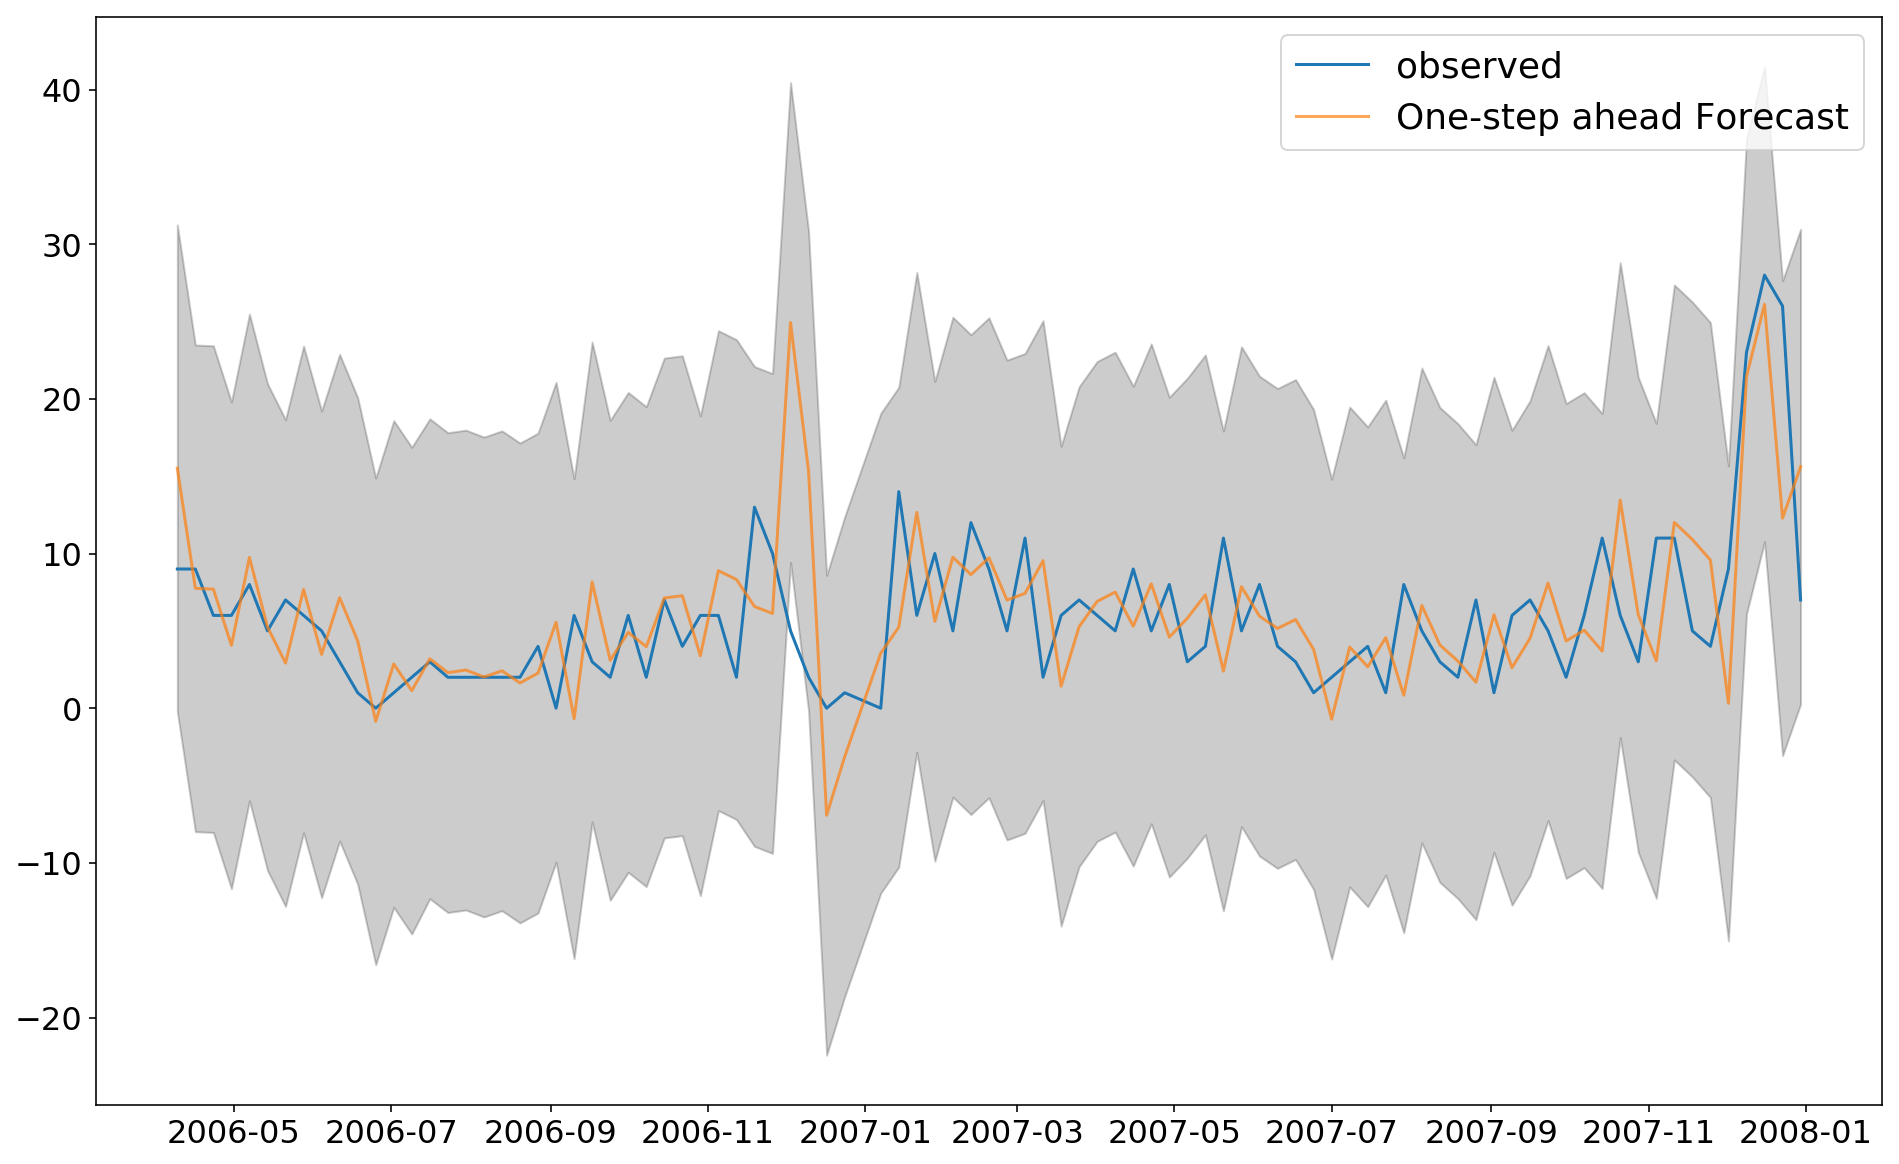

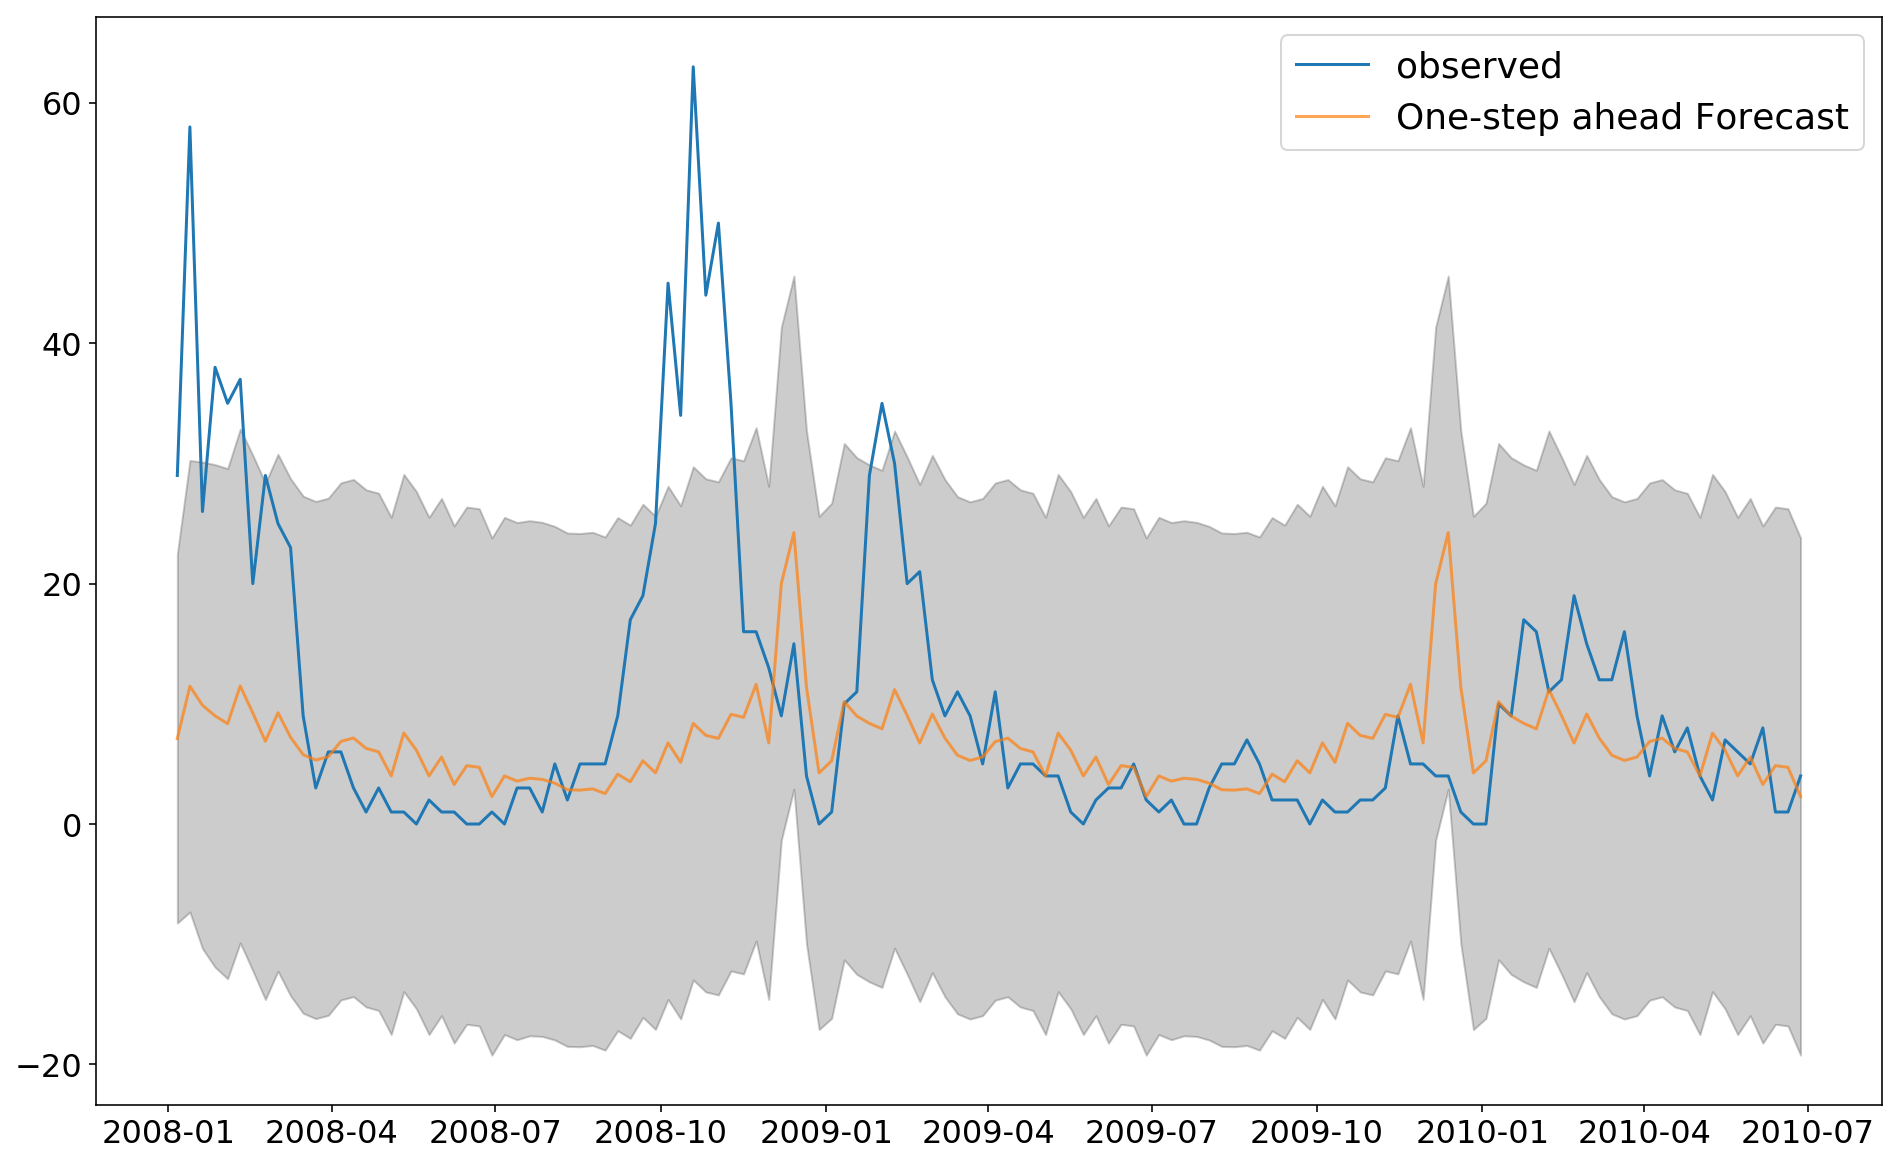

In [248]:
params = {
   'axes.labelsize': 18,# Set to size 8 to start with
   'font.size': 18,# Set to size 8 to start with
   'font.family': 'sans-serif', # Not given initially - only optional
   'font.serif': 'Arial', # Not given initially - only optional
   'legend.fontsize': 18,# Set to size 8 to start with
   'xtick.labelsize': 16,# Set to size 8 to start with
   'ytick.labelsize': 16, # Set to size 8 to start with
   'figure.figsize': [16, 10] # Set to [6,4] to start with 
} 
plt.rcParams.update(params)

plt.plot(y_train_iq.index[300:],y_train_iq[300:], label='observed')
plt.plot(y_train_iq.index[300:],pred_iq_partial.predicted_mean[300:], label='One-step ahead Forecast', alpha=.7)
plt.fill_between(y_train_iq.index[300:],pred_ci_iq_partial.iloc[300:, 0],pred_ci_iq_partial.iloc[300:, 1], color='k', alpha=.2)

ax.set_title("Predicted Train")
ax.set_xlabel('Date')
ax.set_ylabel('Dengue Cases')
plt.legend()
plt.show()

plt.plot(y_test_iq.index[:],y_test_iq[:], label='observed')
plt.plot(y_test_iq.index[:],pred_uc_iq_partial.predicted_mean[:], label='One-step ahead Forecast', alpha=.7)
plt.fill_between(y_test_iq.index[:],pred_ci_iq_partial_test.iloc[:, 0],pred_ci_iq_partial_test.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Dengue Cases')
plt.legend()
plt.show()

In [251]:
mean_absolute_error(np.array(pred_uc_iq_partial.predicted_mean.astype(int)),np.array(y_test_iq))

7.7153846153846155

In [250]:
%%time
mod_iq = sm.tsa.statespace.SARIMAX(y_all_iq,
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_iq = mod_iq.fit()
print(results_iq.summary().tables[1])

pred_iq = results_iq.get_prediction(dynamic=False)
pred_ci_iq = pred_iq.conf_int()

pred_uc_iq = results_iq.get_forecast(steps=156)
pred_ci_iq_sub= pred_uc_iq.conf_int()

C:\Users\19ver\Anaconda2\envs\Py35\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  index_generated = False


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8125      0.017     48.737      0.000       0.780       0.845
ma.L1         -0.1526      0.026     -5.762      0.000      -0.204      -0.101
ma.S.L52      -1.0000   3482.106     -0.000      1.000   -6825.801    6823.801
sigma2        51.0599   1.78e+05      0.000      1.000   -3.48e+05    3.49e+05


C:\Users\19ver\Anaconda2\envs\Py35\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ' location related to the index of the data.')


Wall time: 17 s


In [256]:
np.concatenate((np.array(pred_uc_sj.predicted_mean.astype(int)), np.array(pred_uc_iq.predicted_mean.astype(int))),axis=None)

array([ 7,  8,  7,  7, 10, 12, 12, 15, 17, 19, 21, 23, 27, 36, 46, 42, 49,
       48, 52, 55, 55, 57, 69, 67, 65, 61, 62, 59, 56, 56, 54, 47, 40, 32,
       29, 32, 29, 30, 27, 24, 22, 20, 17, 17, 17, 12, 11, 11,  9,  9,  9,
        7,  9, 10, 10,  9, 12, 14, 13, 16, 19, 20, 22, 25, 29, 37, 47, 44,
       50, 49, 53, 56, 56, 58, 70, 67, 66, 61, 62, 60, 56, 56, 55, 48, 41,
       33, 30, 32, 29, 30, 27, 24, 22, 20, 18, 17, 17, 13, 11, 11,  9,  9,
        9,  8,  9, 10, 10,  9, 12, 14, 13, 16, 19, 20, 22, 25, 29, 37, 47,
       44, 50, 49, 53, 56, 56, 58, 70, 67, 66, 61, 62, 60, 56, 56, 55, 48,
       41, 33, 30, 32, 29, 30, 27, 24, 22, 20, 18, 18, 17, 13, 11, 11,  9,
        9,  9,  8,  9, 10, 10,  9, 12, 14, 13, 16, 19, 20, 22, 25, 29, 37,
       47, 44, 50, 49, 53, 56, 56, 58, 70, 67, 66, 61, 62, 60, 56, 56, 55,
       48, 41, 33, 30, 32, 29, 30, 27, 24, 22, 20, 18, 18, 17, 13, 11, 12,
        9,  9,  9,  8,  9, 10, 10,  9, 12, 14, 13, 16, 19, 21, 22, 25, 29,
       37, 47, 44, 50, 49

In [257]:
results_format['total_cases'] = np.concatenate((np.array(pred_uc_sj.predicted_mean.astype(int)), np.array(pred_uc_iq.predicted_mean.astype(int))),axis=None)

#date_today = datetime.now().strftime("%Y-%m-%d")
counter += 1

results_format.to_csv('Dengue_results_for_submittion_time_series_pred ' + date_today + " attempt " + str(counter) , index=False)

# Fully Connected Neural Net

The Ranom Forest, Negative Binomial or Time-series Forecasting clearly do not have enough complexity to understand the data. They can pick up on the sesanality of the number of cases but not on the outbreak nature it has and what can trigger those outbreaks. 

Total MAE on the submittion set: 25.72

In [384]:
from torch.autograd import Variable

def transform_data(arr, seq_len):
    x, y = [], []
    for i in range(len(arr) - seq_len):
        x_i = arr[i : i + seq_len]
        y_i = arr[i + 1 : i + seq_len + 1]
        x.append(x_i)
        y.append(y_i)
    x_arr = np.array(x).reshape(-1)
    y_arr = np.array(y).reshape(-1)
    #x_var = Variable(torch.from_numpy(x_arr).float())
    #y_var = Variable(torch.from_numpy(y_arr).float())
    return x_arr, y_arr

class Fully_Connected_Net(nn.Module):
    def __init__(self, input_size, hidden_layer_1,hidden_layer_2, hidden_layer_3, output_size ):
        super(Fully_Connected_Net, self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(input_size, hidden_layer_1), nn.ReLU(inplace=True))
        self.fc2 = nn.Sequential(nn.Linear(hidden_layer_1, hidden_layer_2), nn.ReLU(inplace=True))
        self.fc3 = nn.Sequential(nn.Linear(hidden_layer_2, hidden_layer_3), nn.ReLU(inplace=True))
        self.fc4 = nn.Linear(hidden_layer_3, output_size)

    def forward(self, input):
        #print ('1d: {}'.format(output.size()))
        output = self.fc1(input)
        output = self.fc2(output)
        output = self.fc3(output)
        output = self.fc4(output)
        
        return output

In [477]:
sc_sj = MinMaxScaler()
sc_sj_labels = MinMaxScaler()
sc_iq = MinMaxScaler()
sc_iq_labels = MinMaxScaler()

# Scailing the features for training
non_transformed_features = 2
time_lag = 1
X_sj_transformed = pd.DataFrame(sc_sj.fit_transform(X_sj.iloc[:-time_lag,:-non_transformed_features])).join(X_sj.iloc[:-time_lag,-non_transformed_features:])
sj_test_transformed = pd.DataFrame(sc_sj.transform(sj_test.iloc[:,:-non_transformed_features])).join(sj_test.iloc[:,-non_transformed_features:])

X_iq_transformed = pd.DataFrame(sc_iq.fit_transform(X_iq.iloc[:-time_lag,:-non_transformed_features]))
X_iq_transformed['sin_weekofyear'] = np.array(X_iq.iloc[:-1,-2])
X_iq_transformed['cos_weekofyear'] = np.array(X_iq.iloc[:-1,-1])
iq_test_transformed = pd.DataFrame(sc_iq.transform(iq_test.iloc[:,:-non_transformed_features]))
iq_test_transformed['sin_weekofyear'] = np.array(iq_test.iloc[:,-2])
iq_test_transformed['cos_weekofyear'] = np.array(iq_test.iloc[:,-1])

# getting an additional feature that has takes the number of features this week in order to predict the number of cases next week
Y_sj_original, Y_sj_next_week = transform_data(sc_sj_labels.fit_transform(Y_sj.reshape(-1,1)).reshape(-1),time_lag)
X_sj_transformed['this_week_cases'] = np.array(Y_sj_original)
X_sj_final = np.array(X_sj_transformed)
Y_sj_final = np.array(Y_sj_next_week)

sj_test_transformed['projected_cases'] = np.array(pred_uc_sj.predicted_mean)
sj_test_transformed_full = np.array(sj_test_transformed)

Y_iq_original, Y_iq_next_week = transform_data(sc_iq_labels.fit_transform(Y_iq.reshape(-1,1)).reshape(-1), time_lag)
X_iq_transformed['this_week_cases'] = np.array(Y_iq_original)
X_iq_final = np.array(X_iq_transformed)
Y_iq_final = np.array(Y_iq_next_week)

iq_test_transformed['projected_cases'] = np.array(pred_uc_iq.predicted_mean)
iq_test_transformed_full = np.array(iq_test_transformed)

In [479]:
X_train_sj, X_test_sj = train_test_split(X_sj_final,test_size=0.25,shuffle=False)
Y_train_sj, Y_test_sj = train_test_split(Y_sj_final,test_size=0.25,shuffle=False)
print("San Juan")
print ("Shape Train X: {}, Shape Test X: {}".format(X_train_sj.shape, X_test_sj.shape))
print("Shape Train Y: {}, Shape Test Y: {}".format(Y_train_sj.shape, Y_test_sj.shape))

X_train_iq, X_test_iq = train_test_split(X_iq_final,test_size=0.25,shuffle=False)
Y_train_iq, Y_test_iq = train_test_split(Y_iq_final,test_size=0.25,shuffle=False)
print("Iquitos")
print ("Shape Train X: {}, Shape Test X: {}".format(X_train_iq.shape, X_test_iq.shape))
print("Shape Train Y: {}, Shape Test Y: {}".format(Y_train_iq.shape, Y_test_iq.shape))

San Juan
Shape Train X: (701, 23), Shape Test X: (234, 23)
Shape Train Y: (701,), Shape Test Y: (234,)
Iquitos
Shape Train X: (389, 23), Shape Test X: (130, 23)
Shape Train Y: (389,), Shape Test Y: (130,)


In [480]:
X_train_sj_torch = torch.tensor(X_train_sj, dtype=torch.float)
Y_train_sj_torch = torch.tensor(Y_train_sj,dtype=torch.float)

X_test_sj_torch = torch.tensor(X_test_sj, dtype=torch.float)
Y_test_sj_torch = torch.tensor(Y_test_sj,dtype=torch.float)

train_sj = torch.utils.data.TensorDataset(X_train_sj_torch, Y_train_sj_torch)
test_sj = torch.utils.data.TensorDataset(X_test_sj_torch, Y_test_sj_torch)
submission_test_sj = torch.utils.data.TensorDataset(torch.tensor(sj_test_transformed_full, dtype=torch.float))

X_train_iq_torch = torch.tensor(X_train_iq, dtype=torch.float)
Y_train_iq_torch = torch.tensor(Y_train_iq,dtype=torch.float)

X_test_iq_torch = torch.tensor(X_test_iq, dtype=torch.float)
Y_test_iq_torch = torch.tensor(Y_test_iq,dtype=torch.float)

train_iq = torch.utils.data.TensorDataset(X_train_iq_torch, Y_train_iq_torch)
test_iq = torch.utils.data.TensorDataset(X_test_iq_torch, Y_test_iq_torch)
submission_test_iq = torch.utils.data.TensorDataset(torch.tensor(iq_test_transformed_full, dtype=torch.float))

In [436]:
%%time
number_of_epoch = 100
learning_rate = 1e-6
b_size = 52
h1 = 5000
h2 = 5000
h3=2500
output_dim = 1
input_size = X_test_sj.shape[1]

full_net = Fully_Connected_Net(input_size, h1,h2,h3, output_dim)

criterion = torch.nn.MSELoss(size_average=False) 

optimizer = torch.optim.Adam(full_net.parameters(), lr=learning_rate)

train_loader = torch.utils.data.DataLoader(train_, batch_size=b_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=b_size, shuffle=False) 
submittion_loader = torch.utils.data.DataLoader(submission_test,batch_size=b_size, shuffle=False)

loss_epoch = []
mae_epoch = []
for t in range(number_of_epoch):
    start_time = time.time()
    
    total_pred_train = []

    running_loss_train = 0.0
    aver_running_loss_train = 0.0
    
    for i, (x_batch, y_batch) in enumerate(train_loader): # i is the batch number
        outputs = full_net(x_batch) #y_pred

        #print(y_batch.unsqueeze(1).shape)
        
        loss = criterion(outputs, y_batch.unsqueeze(1))
        loss_batch.append(loss)

        # zero the parameter gradients
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()           
        
        #print(outputs.data.numpy())
        pred_train = outputs.data.numpy()
        #pred_train = outputs.data.max(1)[1]
        total_pred_train = np.concatenate((total_pred_train,np.array(pred_train)), axis=None)
        #total_labels_train = np.concatenate((total_labels_train, np.array(y_batch)), axis=None)

        # print statistics
        running_loss_train += loss.item()
        aver_running_loss_train += loss.item()/len(train_loader)
    
    mae_epoch.append(mean_absolute_error(np.array(total_pred_train),np.array(Y_train_sj)))
    loss_epoch.append(running_loss_train)
    elapsed_time = time.time() - start_time
    print ('Epoch %d/%2d \t av_loss=%.3f \t loss=%.3f \t MAE=%.2f \t time=%.2f s' %(t+1, number_of_epoch, aver_running_loss_train,running_loss_train, mean_absolute_error(np.array(total_pred_train),np.array(Y_train_sj)) , elapsed_time))
    

C:\Users\19ver\Anaconda2\envs\Py35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 1/100 	 av_loss=61.972 	 loss=867.608 	 MAE=0.55 	 time=9.84 s
Epoch 2/100 	 av_loss=59.937 	 loss=839.114 	 MAE=0.54 	 time=8.66 s
Epoch 3/100 	 av_loss=58.198 	 loss=814.766 	 MAE=0.53 	 time=9.44 s
Epoch 4/100 	 av_loss=56.540 	 loss=791.556 	 MAE=0.52 	 time=9.76 s
Epoch 5/100 	 av_loss=54.929 	 loss=769.003 	 MAE=0.51 	 time=10.19 s
Epoch 6/100 	 av_loss=53.348 	 loss=746.875 	 MAE=0.50 	 time=8.79 s
Epoch 7/100 	 av_loss=51.790 	 loss=725.060 	 MAE=0.50 	 time=8.83 s
Epoch 8/100 	 av_loss=50.249 	 loss=703.488 	 MAE=0.49 	 time=8.92 s
Epoch 9/100 	 av_loss=48.722 	 loss=682.103 	 MAE=0.48 	 time=9.34 s
Epoch 10/100 	 av_loss=47.204 	 loss=660.861 	 MAE=0.47 	 time=9.43 s
Epoch 11/100 	 av_loss=45.695 	 loss=639.729 	 MAE=0.46 	 time=9.28 s
Epoch 12/100 	 av_loss=44.194 	 loss=618.716 	 MAE=0.45 	 time=9.05 s
Epoch 13/100 	 av_loss=42.699 	 loss=597.782 	 MAE=0.44 	 time=9.41 s
Epoch 14/100 	 av_loss=41.214 	 loss=576.996 	 MAE=0.43 	 time=8.96 s
Epoch 15/100 	 av_loss=39.74

In [422]:
total_pred_test = []
for j, (x_batch, y_batch) in enumerate(test_loader):
    outputs_test = full_net(x_batch) #y_pred
        
    pred_test = outputs_test.data.numpy()
    #pred_train = outputs.data.max(1)[1]
    total_pred_test = np.concatenate((total_pred_test,np.array(pred_test)), axis=None)


mean_absolute_error(np.array(total_pred_test), np.array(Y_test_sj))

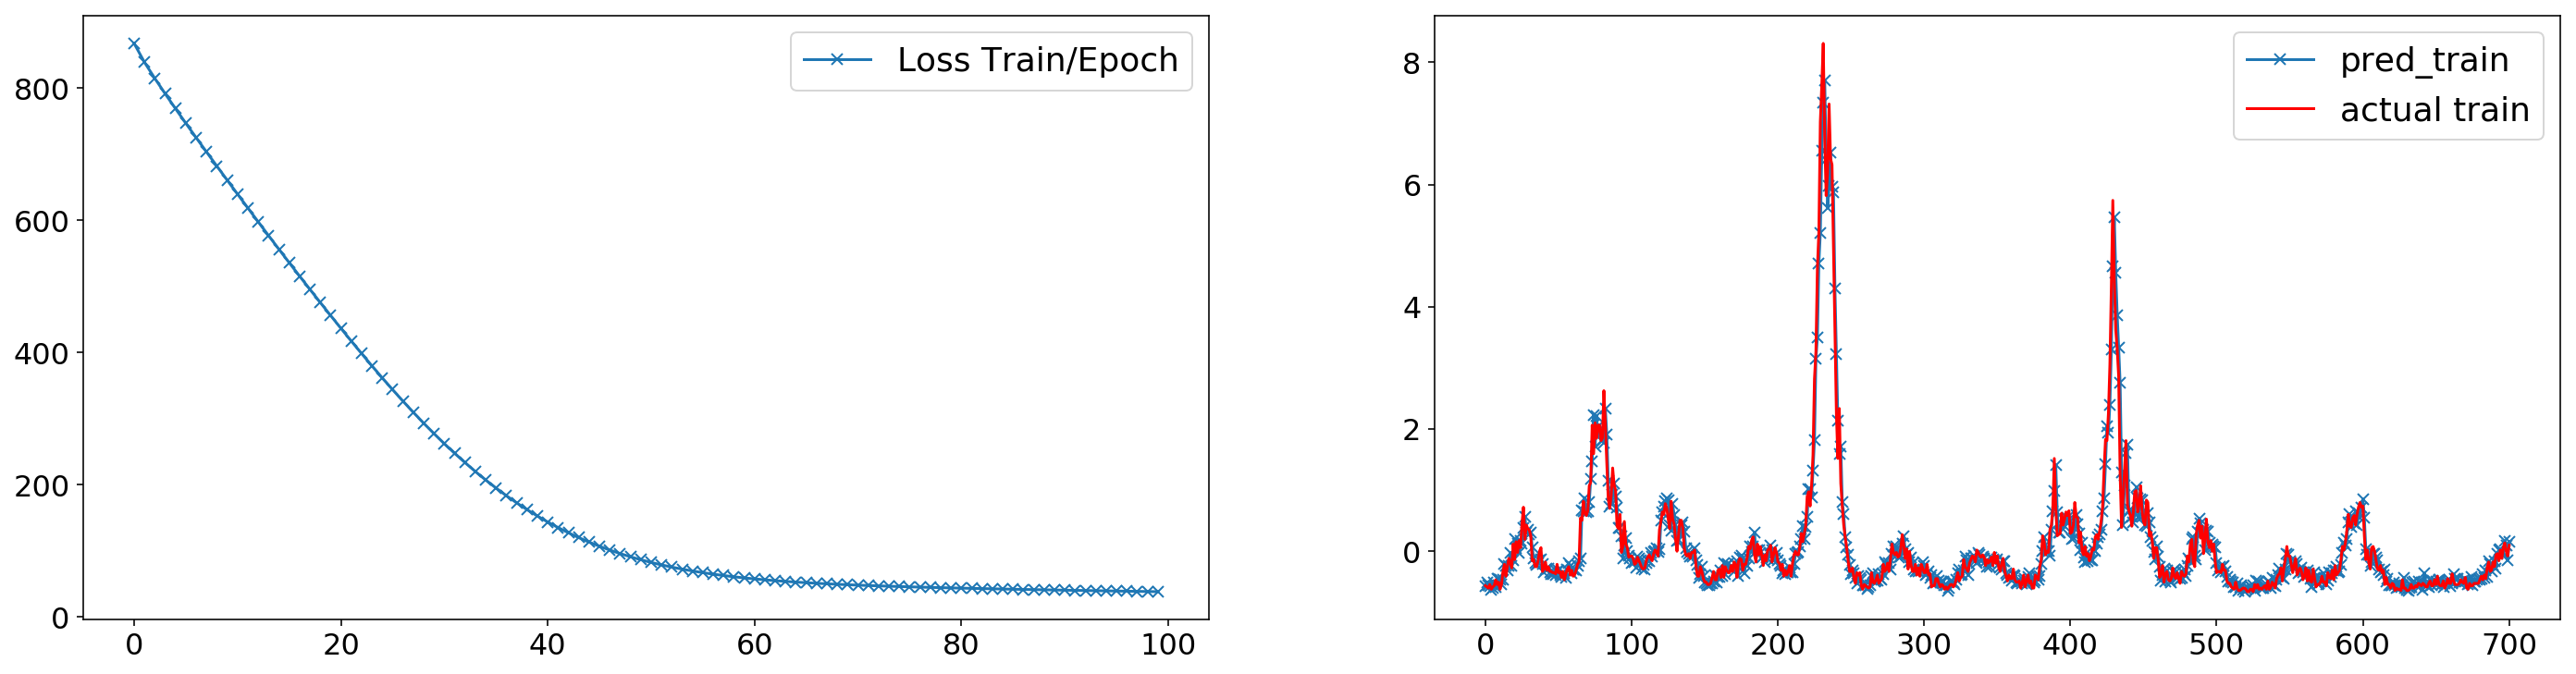

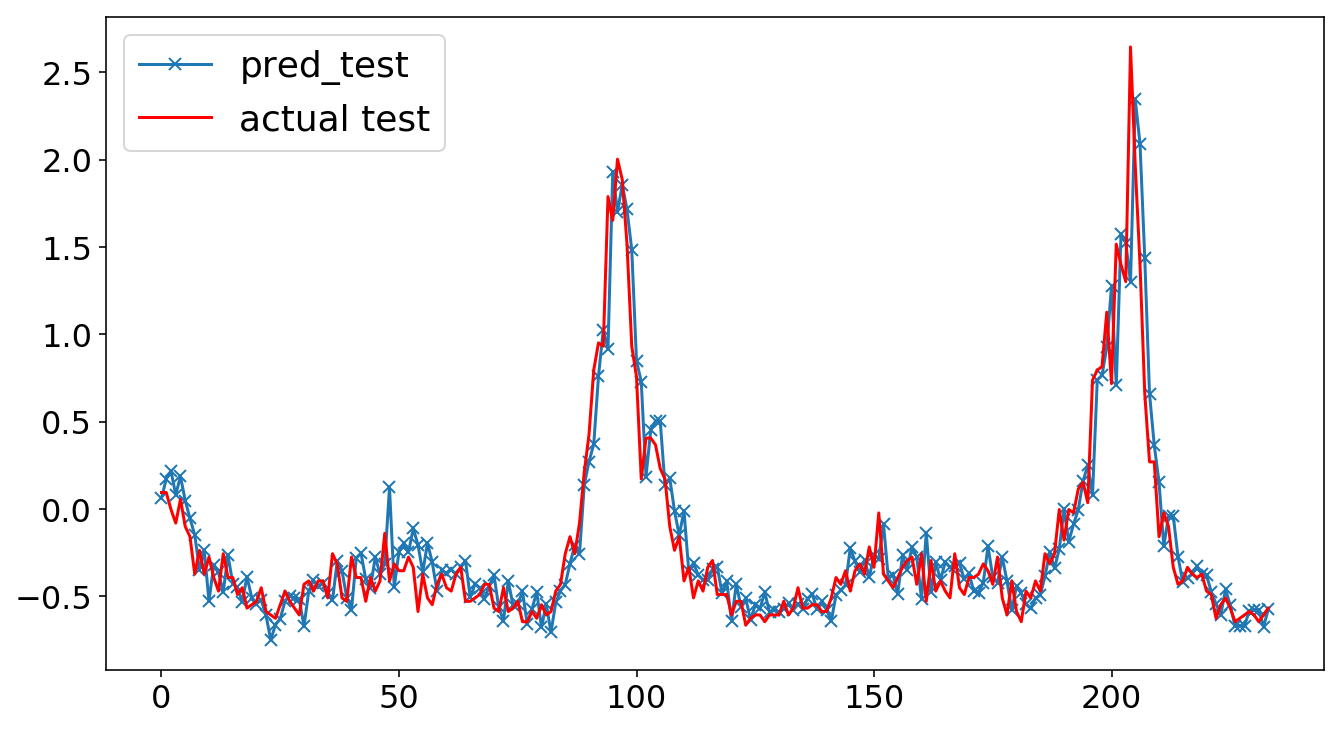

In [437]:
num_of_batches = math.ceil(X_train_sj.shape[0]/b_size)
# plotting loss for training over both epochs and the batches 
epoches = np.arange(0,number_of_epoch)
batches =np.arange(0,number_of_epoch*num_of_batches)
time_train = np.arange(len(X_train_sj))
time_test = np.arange(len(X_test_sj))

fig = plt.figure(figsize=(24,6)) 
ax1 = fig.add_subplot(1,2, 1)
ax1.plot(epoches, loss_epoch, 'x-',label='Loss Train/Epoch')
#ax1.plot(epoches[:],av_losses_epoch_valid[:], 'rx-', label = 'Loss Valid/Batch')
#plt.title("Z500* dtrnd, lat averaged and scaled by " str(anomaly_scale))
ax1.legend(loc='best')
#plt.savefig('/rds/general/user/vu116/home/Blocking/New_idices_daily_mean/images/Loss_plots_' + name + note + date_today + '.png' )

ax2 = fig.add_subplot(1,2, 2) 
ax2.plot(time_train, total_pred_train, 'x-',label='pred_train')
ax2.plot(time_train, Y_train_sj, 'r-', label = 'actual train')
#plt.title("Z500* dtrnd, lat averaged and scaled by " str(anomaly_scale))
ax2.legend(loc='best')
#plt.savefig('/rds/general/user/vu116/home/Blocking/New_idices_daily_mean/images/Loss_plots_' + name + note + date_today + '.png' )
#plt.show()

fig2 = plt.figure(figsize=(24,6)) 
ax1 = fig2.add_subplot(1,2, 1)
ax1.plot(time_test, total_pred_test, 'x-',label='pred_test')
ax1.plot(time_test, Y_test_sj,'r-',label = 'actual test')
#ax1.plot(epoches[:],av_losses_epoch_valid[:], 'rx-', label = 'Loss Valid/Batch')
#plt.title("Z500* dtrnd, lat averaged and scaled by " str(anomaly_scale))
ax1.legend(loc='best')

In [438]:
submittion_loader = torch.utils.data.DataLoader(submission_test,batch_size=b_size, shuffle=False)

total_pred_sub = []
for j, (x_batch,) in enumerate(submittion_loader):
    outputs_submittion = full_net(x_batch) #y_pred
        
    pred_sub = outputs_submittion.data.numpy()
    #pred_train = outputs.data.max(1)[1]
    total_pred_sub = np.concatenate((total_pred_sub,np.array(pred_sub)), axis=None)

fig = plt.figure(figsize=(24,6)) 
ax1 = fig.add_subplot(1,2, 1)
ax1.plot(np.arange(260), total_pred_sub, 'x-',label='nn_sub')
ax1.plot(np.arange(260),pred_uc_sj.predicted_mean, 'rx-', label = 'AMIra pred')
#plt.title("Z500* dtrnd, lat averaged and scaled by " str(anomaly_scale))
ax1.legend(loc='best')

In [486]:
%%time
number_of_epoch = 100
learning_rate = 1e-5
b_size = 52
h1 = 5000
h2 = 5000
h3=2500
output_dim = 1
input_size = X_train_iq.shape[1]

full_net_2 = Fully_Connected_Net(input_size, h1,h2,h3, output_dim)

criterion = torch.nn.MSELoss(size_average=False) 

optimizer = torch.optim.Adam(full_net_2.parameters(), lr=learning_rate)

train_loader_iq = torch.utils.data.DataLoader(train_iq, batch_size=b_size, shuffle=False)
test_loader_iq = torch.utils.data.DataLoader(test_iq, batch_size=b_size, shuffle=False) 
submittion_loader_iq = torch.utils.data.DataLoader(submission_test_iq,batch_size=b_size, shuffle=False)

loss_epoch_iq = []
mae_epoch_iq = []

for t in range(number_of_epoch):
    start_time = time.time()
    
    total_pred_train_iq = []
    loss_batch_iq =[]

    running_loss_train = 0.0
    aver_running_loss_train = 0.0
    
    for i, (x_batch_iq, y_batch_iq) in enumerate(train_loader_iq): # i is the batch number
        outputs_iq = full_net_2(x_batch_iq) #y_pred

        #print(y_batch.unsqueeze(1).shape)
        
        loss_iq = criterion(outputs_iq, y_batch_iq.unsqueeze(1))
        loss_batch_iq.append(loss_iq)

        # zero the parameter gradients
        optimizer.zero_grad()

        loss_iq.backward()
        optimizer.step()           
        
        #print(outputs.data.numpy())
        pred_train_iq = outputs_iq.data.numpy()
        #pred_train = outputs.data.max(1)[1]
        total_pred_train_iq = np.concatenate((total_pred_train_iq,np.array(pred_train_iq)), axis=None)
        #total_labels_train = np.concatenate((total_labels_train, np.array(y_batch)), axis=None)

        # print statistics
        running_loss_train += loss_iq.item()
        aver_running_loss_train += loss_iq.item()/len(train_loader_iq)
    
    mae_epoch_iq.append(mean_absolute_error(np.array(total_pred_train_iq),np.array(Y_train_iq)))
    loss_epoch_iq.append(running_loss_train)
    elapsed_time = time.time() - start_time
    print ('Epoch %d/%2d \t av_loss=%.3f \t loss=%.3f \t MAE=%.2f \t time=%.2f s' %(t+1, number_of_epoch, aver_running_loss_train,running_loss_train, mean_absolute_error(np.array(total_pred_train_iq),np.array(Y_train_iq)) , elapsed_time))
    

C:\Users\19ver\Anaconda2\envs\Py35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 1/100 	 av_loss=43.238 	 loss=345.901 	 MAE=0.53 	 time=4.87 s
Epoch 2/100 	 av_loss=35.459 	 loss=283.673 	 MAE=0.46 	 time=4.92 s
Epoch 3/100 	 av_loss=31.606 	 loss=252.851 	 MAE=0.46 	 time=4.69 s
Epoch 4/100 	 av_loss=28.337 	 loss=226.694 	 MAE=0.43 	 time=4.76 s
Epoch 5/100 	 av_loss=25.175 	 loss=201.401 	 MAE=0.39 	 time=4.95 s
Epoch 6/100 	 av_loss=22.453 	 loss=179.625 	 MAE=0.37 	 time=4.79 s
Epoch 7/100 	 av_loss=20.380 	 loss=163.038 	 MAE=0.35 	 time=4.80 s
Epoch 8/100 	 av_loss=18.776 	 loss=150.207 	 MAE=0.33 	 time=4.78 s
Epoch 9/100 	 av_loss=17.631 	 loss=141.049 	 MAE=0.32 	 time=5.15 s
Epoch 10/100 	 av_loss=16.785 	 loss=134.277 	 MAE=0.30 	 time=4.81 s
Epoch 11/100 	 av_loss=16.082 	 loss=128.657 	 MAE=0.29 	 time=5.11 s
Epoch 12/100 	 av_loss=15.452 	 loss=123.616 	 MAE=0.29 	 time=4.81 s
Epoch 13/100 	 av_loss=14.863 	 loss=118.904 	 MAE=0.28 	 time=5.21 s
Epoch 14/100 	 av_loss=14.299 	 loss=114.393 	 MAE=0.27 	 time=5.01 s
Epoch 15/100 	 av_loss=13.747

In [487]:
total_pred_test_iq = []
for j, (x_batch, y_batch) in enumerate(test_loader_iq):
    outputs_test_iq = full_net_2(x_batch) #y_pred
        
    pred_test = outputs_test_iq.data.numpy()
    #pred_train = outputs.data.max(1)[1]
    total_pred_test_iq = np.concatenate((total_pred_test_iq,np.array(pred_test)), axis=None)


mean_absolute_error(np.array(total_pred_test_iq), np.array(Y_test_iq))

0.5222005125151857

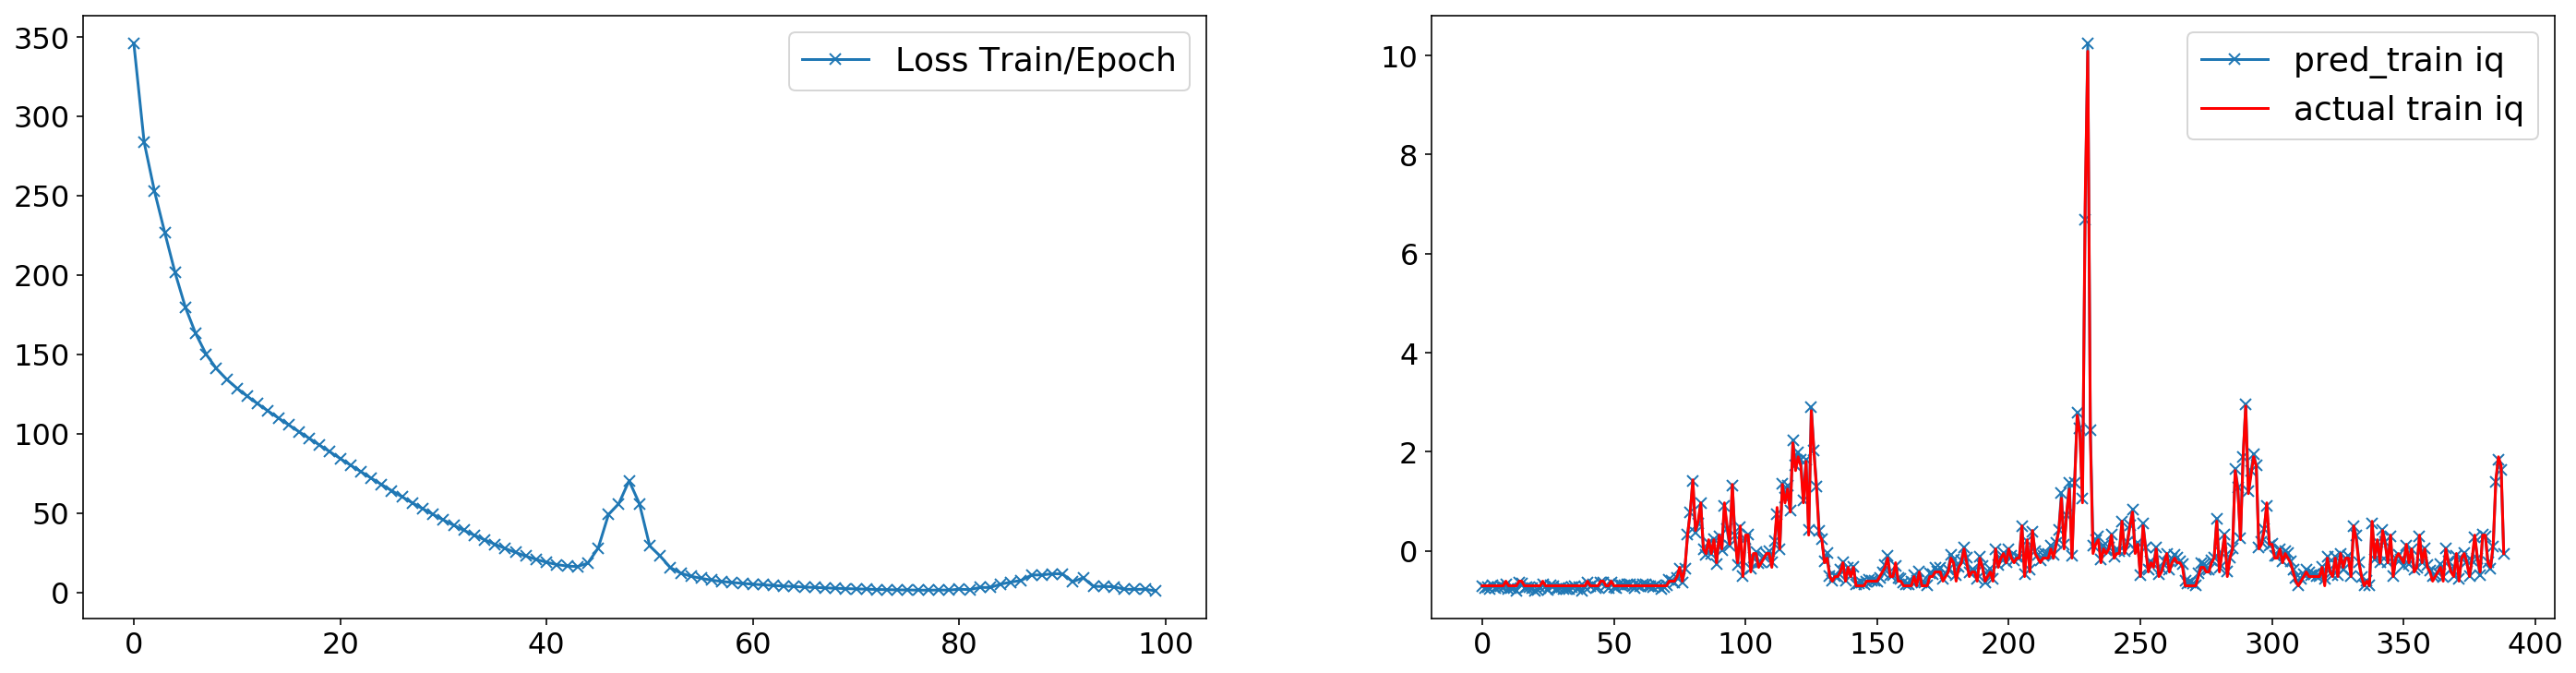

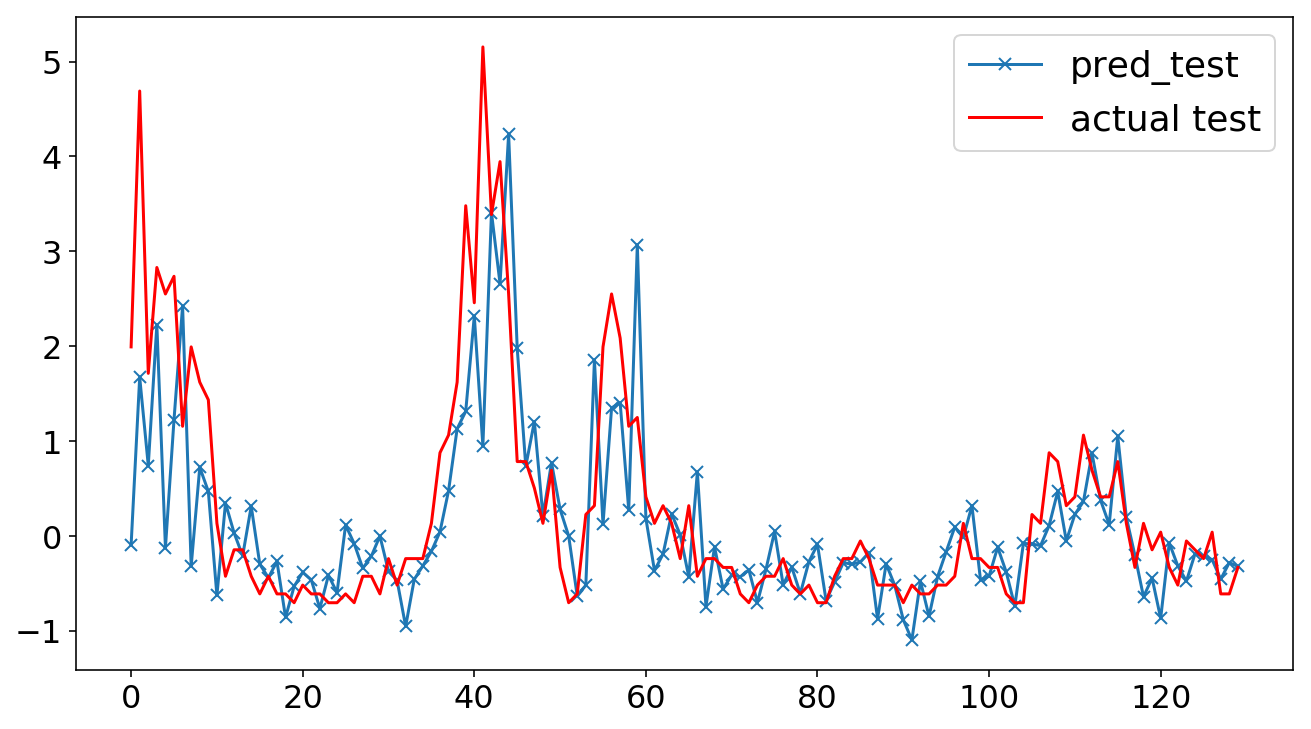

In [488]:
num_of_batches = math.ceil(X_train_iq.shape[0]/b_size)
# plotting loss for training over both epochs and the batches 
epoches = np.arange(0,number_of_epoch)
batches =np.arange(0,number_of_epoch*num_of_batches)
time_train_iq = np.arange(len(X_train_iq))
time_test_iq = np.arange(len(X_test_iq))

fig = plt.figure(figsize=(24,6)) 
ax1 = fig.add_subplot(1,2, 1)
ax1.plot(epoches, loss_epoch_iq, 'x-',label='Loss Train/Epoch')
#ax1.plot(epoches[:],av_losses_epoch_valid[:], 'rx-', label = 'Loss Valid/Batch')
#plt.title("Z500* dtrnd, lat averaged and scaled by " str(anomaly_scale))
ax1.legend(loc='best')
#plt.savefig('/rds/general/user/vu116/home/Blocking/New_idices_daily_mean/images/Loss_plots_' + name + note + date_today + '.png' )

ax2 = fig.add_subplot(1,2, 2) 
ax2.plot(time_train_iq, total_pred_train_iq, 'x-',label='pred_train iq')
ax2.plot(time_train_iq, Y_train_iq, 'r-', label = 'actual train iq')
#plt.title("Z500* dtrnd, lat averaged and scaled by " str(anomaly_scale))
ax2.legend(loc='best')
#plt.savefig('/rds/general/user/vu116/home/Blocking/New_idices_daily_mean/images/Loss_plots_' + name + note + date_today + '.png' )
#plt.show()

fig2 = plt.figure(figsize=(24,6)) 
ax1 = fig2.add_subplot(1,2, 1)
ax1.plot(time_test_iq, total_pred_test_iq, 'x-',label='pred_test')
ax1.plot(time_test_iq, Y_test_iq,'r-',label = 'actual test')
#ax1.plot(epoches[:],av_losses_epoch_valid[:], 'rx-', label = 'Loss Valid/Batch')
#plt.title("Z500* dtrnd, lat averaged and scaled by " str(anomaly_scale))
ax1.legend(loc='best')

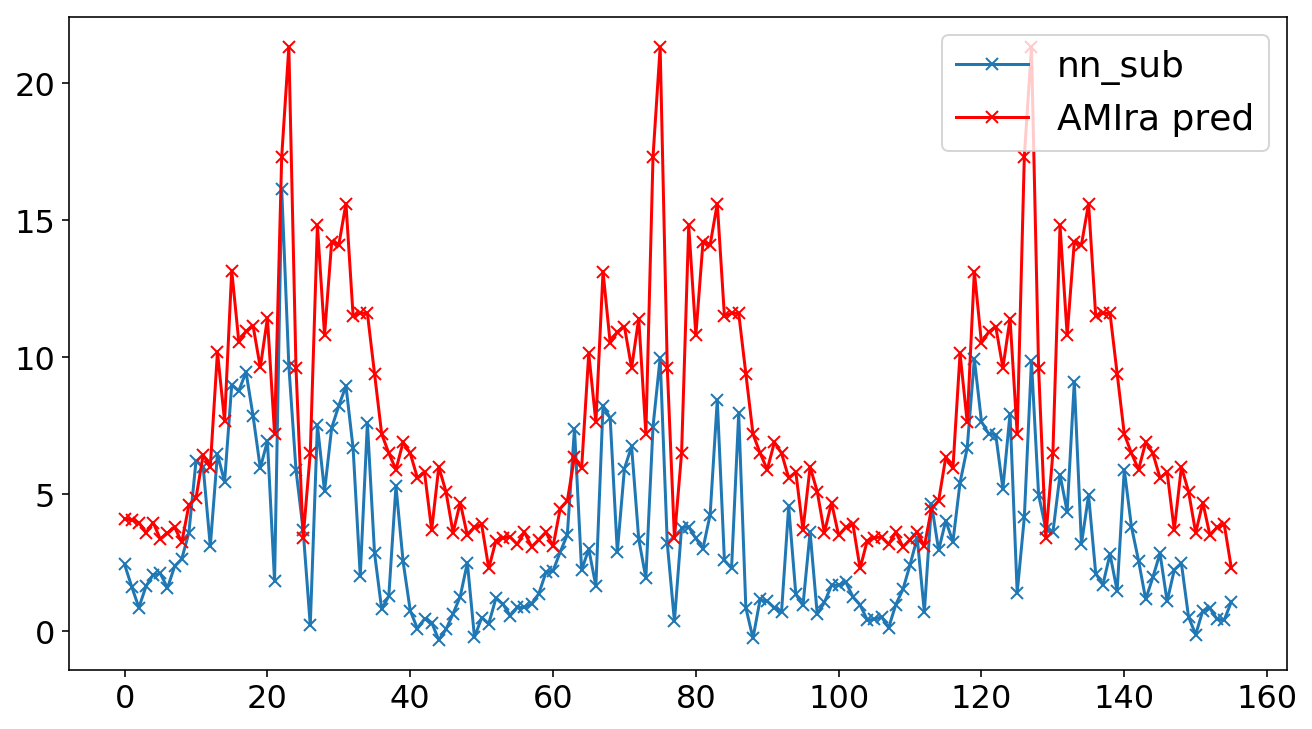

In [490]:
submittion_loader_iq = torch.utils.data.DataLoader(submission_test_iq,batch_size=b_size, shuffle=False)

total_pred_sub_iq = []
for j, (x_batch,) in enumerate(submittion_loader_iq):
    outputs_submittion_iq = full_net_2(x_batch) #y_pred
        
    pred_sub_iq = outputs_submittion_iq.data.numpy()
    #pred_train = outputs.data.max(1)[1]
    total_pred_sub_iq = np.concatenate((total_pred_sub_iq,np.array(pred_sub_iq)), axis=None)

fig = plt.figure(figsize=(24,6)) 
ax1 = fig.add_subplot(1,2, 1)
ax1.plot(np.arange(156), total_pred_sub_iq, 'x-',label='nn_sub')
ax1.plot(np.arange(156),pred_uc_iq.predicted_mean, 'rx-', label = 'AMIra pred')
#plt.title("Z500* dtrnd, lat averaged and scaled by " str(anomaly_scale))
ax1.legend(loc='best')

In [492]:
results_format['total_cases'] = np.concatenate((np.array(total_pred_sub.astype(int)), np.array(pred_uc_iq.predicted_mean.astype(int))),axis=None)

#date_today = datetime.now().strftime("%Y-%m-%d")
counter += 1

results_format.to_csv('Dengue_results_for_submittion_nn_mix ' + date_today + " attempt " + str(counter) , index=False)

In [ ]:
results_format['total_cases'] = np.concatenate((np.array(pred_uc_sj.predicted_mean.astype(int)), np.array(pred_uc_iq.predicted_mean.astype(int))),axis=None)

#date_today = datetime.now().strftime("%Y-%m-%d")
counter += 1

results_format.to_csv('Dengue_results_for_submittion_time_series_pred ' + date_today + " attempt " + str(counter) , index=False)